In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgbm
from sklearn.metrics import *
import math
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import math
from pathlib import Path
from warnings import filterwarnings
import joblib
filterwarnings('ignore')

/home/arma/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
#inputFile = Path(HERE).resolve().parents[0] /"Selectivity/input"
HDAC6 = Path(HERE).resolve().parents[0] / "BioactivityModels/HDAC6"
HDAC1 = Path(HERE).resolve().parents[0] / "BioactivityModels/HDAC1"
HDAC1and6 = Path(HERE).resolve().parents[0] / "SelectivityModels"

In [3]:
hdac1and6 = pd.read_pickle(HDAC1and6/"input/HDAC1and6_SemiSel_1024B.csv")
hdac1and6.reset_index(inplace=True)
hdac1and6.drop('index', axis=1, inplace=True)
hdac1and6.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow
0,CHEMBL4098975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2770663, 83582, 137380, 5467685, 28861, 20399...",2.89
1,CHEMBL3912061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 4142580, 576166, 5215404, 6...",3.56
2,CHEMBL4243347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 3821889, 137380, 4236434, 7332227, 2...",1.00
3,CHEMBL4247128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[3808044, 3821889, 137380, 2385390, 6940687, 2...",2.52
4,CHEMBL4126811,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[4928228, 22758228, 8033062, 10725227, 1087409...",3.12


In [4]:
hdac1and6_labeled = pd.read_csv(HDAC1and6/"input/HDAC1and6_SemiSel_dataset.csv",)
hdac1and6_labeled.rename({"ChEMBL ID": "molecule_chembl_id"}, axis=1, inplace=True)
hdac1and6_labeled.rename({"pChEMBL_HDAC1": "pActivity_HDAC1"}, axis=1, inplace=True)
hdac1and6_labeled.rename({"pChEMBL_HDAC6": "pActivity_HDAC6"}, axis=1, inplace=True)
hdac1and6_labeled = hdac1and6_labeled[['molecule_chembl_id','pActivity_HDAC1', 'pActivity_HDAC6', 'label' ]]
hdac1and6_labeled.head(5)

,molecule_chembl_id,pActivity_HDAC1,pActivity_HDAC6,label
0,CHEMBL4098975,6.96,9.85,HDAC6-selective
1,CHEMBL3912061,6.21,9.77,HDAC6-selective
2,CHEMBL4243347,8.70,9.70,Dual-binder
3,CHEMBL4247128,7.08,9.60,HDAC6-selective
4,CHEMBL4126811,6.36,9.48,HDAC6-selective


In [5]:
hdac1and6 = pd.merge(hdac1and6, hdac1and6_labeled, on="molecule_chembl_id",)
hdac1and6.head(5)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow,pActivity_HDAC1,pActivity_HDAC6,label
0,CHEMBL4098975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2770663, 83582, 137380, 5467685, 28861, 20399...",2.89,6.96,9.85,HDAC6-selective
1,CHEMBL3912061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 4142580, 576166, 5215404, 6...",3.56,6.21,9.77,HDAC6-selective
2,CHEMBL4243347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 3821889, 137380, 4236434, 7332227, 2...",1.00,8.70,9.70,Dual-binder
3,CHEMBL4247128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[3808044, 3821889, 137380, 2385390, 6940687, 2...",2.52,7.08,9.60,HDAC6-selective
4,CHEMBL4126811,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[4928228, 22758228, 8033062, 10725227, 1087409...",3.12,6.36,9.48,HDAC6-selective


In [6]:
hdac1and6['Class'] = np.zeros(len(hdac1and6))

hdac1and6.loc[hdac1and6[hdac1and6.label == 'HDAC1-selective'].index, "Class"] = 1.0
hdac1and6.loc[hdac1and6[hdac1and6.label == 'HDAC6-selective'].index, "Class"] = 2.0
hdac1and6.loc[hdac1and6[hdac1and6.label == 'Dual-binder'].index, "Class"] = 3.0
hdac1and6.loc[hdac1and6[hdac1and6.label == 'Non-binder'].index, "Class"] = 4.0
hdac1and6.loc[hdac1and6[hdac1and6.label == 'Semi-selective'].index, "Class"] = 5.0

hdac1and6.head(4)

,molecule_chembl_id,fp_MACCS,fp_Morgan3,fp_MorganF,fp_MAP4,SelectivityWindow,pActivity_HDAC1,pActivity_HDAC6,label,Class
0,CHEMBL4098975,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, ...","[2770663, 83582, 137380, 5467685, 28861, 20399...",2.89,6.96,9.85,HDAC6-selective,2.0
1,CHEMBL3912061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5976924, 3913535, 4142580, 576166, 5215404, 6...",3.56,6.21,9.77,HDAC6-selective,2.0
2,CHEMBL4243347,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[6411541, 3821889, 137380, 4236434, 7332227, 2...",1.00,8.70,9.70,Dual-binder,3.0
3,CHEMBL4247128,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, ...","[3808044, 3821889, 137380, 2385390, 6940687, 2...",2.52,7.08,9.60,HDAC6-selective,2.0


In [7]:
hdac1and6[hdac1and6['label'] == 'Dual-binder']['SelectivityWindow'].min()

-1.0

## HDAC1 Regression Models

In [8]:
# Add a column for activity against HDAC6

hdac1and6["HDAC1activity"] = np.zeros(len(hdac1and6))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
hdac1and6.loc[hdac1and6[hdac1and6.pActivity_HDAC1 >= 6.6].index, "HDAC1activity"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(hdac1and6.HDAC1activity.sum()))
print("Number of inactive compounds:", len(hdac1and6) - int(hdac1and6.HDAC1activity.sum()))

Number of active compounds: 894
Number of inactive compounds: 1016


In [9]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_hdac1_reg = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_hdac1_reg = hdac1and6["pActivity_HDAC1"].values
y_hdac1_reg_cat = hdac1and6["HDAC1activity"].values
y_hdac1_reg_class = hdac1and6["Class"].values

In [10]:
#change to fit into these X values 


TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_rf.joblib")
        optimizedCV_rf.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_hdac1_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
rf_hdac1_run0.reset_index(inplace=True, drop=True)
rf_hdac1_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
rf_hdac1_run1.reset_index(inplace=True, drop=True)
rf_hdac1_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
rf_hdac1_run2.reset_index(inplace=True, drop=True)
rf_hdac1_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
rf_hdac1_run3.reset_index(inplace=True, drop=True)
rf_hdac1_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
rf_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
rf_5preds_hdac1 = pd.concat([chembl_id, rf_hdac1_run0, rf_hdac1_run1, rf_hdac1_run2, rf_hdac1_run3, rf_hdac1_run4], axis=1)
rf_5preds_hdac1 = rf_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds_hdac1['y_pred_rf_ave'] = rf_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds_hdac1['y_pred_rf_std'] = rf_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)



In [11]:
mat_met_optimized_rf

,Metric,Value (average),Value (std)
0,R2,0.671146,0.044490
1,Accuracy,0.842618,0.024771
2,Precision,0.830436,0.029420
3,Sensitivity,0.835189,0.043097
4,Specificity,0.849370,0.030100
5,F1 score,0.832083,0.027201
6,F1 score (weighted),0.842564,0.024839
7,F1 score (macro),0.841784,0.024863
8,Balanced Accuracy,0.842278,0.025249
9,MCC,0.684890,0.049842


In [12]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_lgbm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_lgbm.joblib")
        optimizedCV_lgbm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
        
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_hdac1_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_hdac1_run0.reset_index(inplace=True, drop=True)
lgbm_hdac1_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_hdac1_run1.reset_index(inplace=True, drop=True)
lgbm_hdac1_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_hdac1_run2.reset_index(inplace=True, drop=True)
lgbm_hdac1_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_hdac1_run3.reset_index(inplace=True, drop=True)
lgbm_hdac1_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
lgbm_5preds_hdac1 = pd.concat([chembl_id, lgbm_hdac1_run0, lgbm_hdac1_run1, lgbm_hdac1_run2, lgbm_hdac1_run3, lgbm_hdac1_run4], axis=1)
lgbm_5preds_hdac1 = lgbm_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds_hdac1['y_pred_lgbm_ave'] = lgbm_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds_hdac1['y_pred_lgbm_std'] = lgbm_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)


In [13]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_xgb=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_xgb.joblib")
        optimizedCV_xgb.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_hdac1_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_hdac1_run0.reset_index(inplace=True, drop=True)
xgb_hdac1_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_hdac1_run1.reset_index(inplace=True, drop=True)
xgb_hdac1_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_hdac1_run2.reset_index(inplace=True, drop=True)
xgb_hdac1_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_hdac1_run3.reset_index(inplace=True, drop=True)
xgb_hdac1_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
xgb_5preds_hdac1 = pd.concat([chembl_id, xgb_hdac1_run0, xgb_hdac1_run1, xgb_hdac1_run2, xgb_hdac1_run3, xgb_hdac1_run4], axis=1)
xgb_5preds_hdac1 = xgb_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds_hdac1['y_pred_xgb_ave'] = xgb_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds_hdac1['y_pred_xgb_std'] = xgb_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)


In [14]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_hdac1_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
knn_hdac1_run0.reset_index(inplace=True, drop=True)
knn_hdac1_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
knn_hdac1_run1.reset_index(inplace=True, drop=True)
knn_hdac1_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
knn_hdac1_run2.reset_index(inplace=True, drop=True)
knn_hdac1_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
knn_hdac1_run3.reset_index(inplace=True, drop=True)
knn_hdac1_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
knn_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_hdac1 = pd.concat([chembl_id, knn_hdac1_run0, knn_hdac1_run1, knn_hdac1_run2, knn_hdac1_run3, knn_hdac1_run4], axis=1)
knn_5preds_hdac1 = knn_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_hdac1['y_pred_knn_ave'] = knn_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_hdac1['y_pred_knn_std'] = knn_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds_hdac1

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL4098975,0,6.96,7.231190,6.902681,6.382987,6.902681,6.487506,6.811174,0.289659
1,CHEMBL3912061,1,6.21,5.137736,5.101447,5.137736,5.137736,5.137736,5.310399,0.402532
2,CHEMBL4243347,2,8.70,6.932805,6.916073,6.850921,7.202069,6.932805,7.255779,0.655311
3,CHEMBL4247128,3,7.08,7.019694,7.019694,7.019694,7.019694,6.741491,6.983378,0.110394
4,CHEMBL4126811,4,6.36,6.450490,6.855335,6.400936,6.207433,6.400936,6.445855,0.198304
...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1905,5.39,7.051955,6.671119,7.070697,7.051955,6.971688,6.701236,0.602204
1906,CHEMBL4282471,1906,5.47,6.570629,6.629602,6.570629,6.570629,6.671863,6.413892,0.423814
1907,CHEMBL470843,1907,5.20,5.707608,5.707608,5.707608,5.806467,5.707608,5.639483,0.199830
1908,CHEMBL3215861,1908,7.55,7.660000,7.660000,7.660000,7.660000,7.660000,7.641667,0.040995


In [15]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_svm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_svm.joblib")
        optimizedCV_svm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_hdac1_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
svm_hdac1_run0.reset_index(inplace=True, drop=True)
svm_hdac1_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
svm_hdac1_run1.reset_index(inplace=True, drop=True)
svm_hdac1_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
svm_hdac1_run2.reset_index(inplace=True, drop=True)
svm_hdac1_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
svm_hdac1_run3.reset_index(inplace=True, drop=True)
svm_hdac1_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
svm_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
svm_5preds_hdac1 = pd.concat([chembl_id, svm_hdac1_run0, svm_hdac1_run1, svm_hdac1_run2, svm_hdac1_run3, svm_hdac1_run4], axis=1)
svm_5preds_hdac1 = svm_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds_hdac1['y_pred_svm_ave'] = svm_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds_hdac1['y_pred_svm_std'] = svm_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
svm_5preds_hdac1

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_svm0,y_pred_svm1,y_pred_svm2,y_pred_svm3,y_pred_svm4,y_pred_svm_ave,y_pred_svm_std
0,CHEMBL4098975,0,6.96,7.045363,6.855860,6.455408,6.814804,6.570463,6.783649,0.207754
1,CHEMBL3912061,1,6.21,5.852310,5.778673,5.756265,5.684321,5.782002,5.843928,0.170944
2,CHEMBL4243347,2,8.70,6.888557,6.946187,6.822061,6.878640,6.865127,7.183429,0.679218
3,CHEMBL4247128,3,7.08,7.273608,7.098272,7.253341,7.240847,7.166451,7.185420,0.075862
4,CHEMBL4126811,4,6.36,6.334559,6.646927,6.459543,6.230499,6.376160,6.401281,0.128899
...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1905,5.39,7.046042,6.994869,7.058991,7.114715,7.058783,6.777233,0.621368
1906,CHEMBL4282471,1906,5.47,5.736189,5.548990,5.642307,5.568210,5.694106,5.609967,0.090471
1907,CHEMBL470843,1907,5.20,6.047199,6.023108,6.114745,6.025895,6.133699,5.924108,0.326577
1908,CHEMBL3215861,1908,7.55,7.559840,7.560089,7.559851,7.559843,7.559952,7.558262,0.003696


In [16]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1_reg, y_hdac1_reg_class)):
        X_train, X_test = X_hdac1_reg[train_idx], X_hdac1_reg[test_idx]
        y_train, y_test = y_hdac1_reg[train_idx], y_hdac1_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC1/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_hdac1_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_hdac1_run0.sort_values(by='y_test_idx0', inplace=True)
knn_hdac1_run0.reset_index(inplace=True, drop=True)
knn_hdac1_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_hdac1_run1.sort_values(by='y_test_idx1', inplace=True)
knn_hdac1_run1.reset_index(inplace=True, drop=True)
knn_hdac1_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_hdac1_run2.sort_values(by='y_test_idx2', inplace=True)
knn_hdac1_run2.reset_index(inplace=True, drop=True)
knn_hdac1_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_hdac1_run3.sort_values(by='y_test_idx3', inplace=True)
knn_hdac1_run3.reset_index(inplace=True, drop=True)
knn_hdac1_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_hdac1_run4.sort_values(by='y_test_idx4', inplace=True)
knn_hdac1_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_hdac1 = pd.concat([chembl_id, knn_hdac1_run0, knn_hdac1_run1, knn_hdac1_run2, knn_hdac1_run3, knn_hdac1_run4], axis=1)
knn_5preds_hdac1 = knn_5preds_hdac1[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_hdac1['y_pred_knn_ave'] = knn_5preds_hdac1.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_hdac1['y_pred_knn_std'] = knn_5preds_hdac1.iloc[:,2:].std(axis='columns', numeric_only=True)
# maybe also calculate the std for each value
knn_5preds_hdac1

,molecule_chembl_id,y_test_idx0,y_test0,y_pred_knn0,y_pred_knn1,y_pred_knn2,y_pred_knn3,y_pred_knn4,y_pred_knn_ave,y_pred_knn_std
0,CHEMBL4098975,0,6.96,7.231190,6.902681,6.382987,6.902681,6.487506,6.811174,0.289659
1,CHEMBL3912061,1,6.21,5.137736,5.101447,5.137736,5.137736,5.137736,5.310399,0.402532
2,CHEMBL4243347,2,8.70,6.932805,6.916073,6.850921,7.202069,6.932805,7.255779,0.655311
3,CHEMBL4247128,3,7.08,7.019694,7.019694,7.019694,7.019694,6.741491,6.983378,0.110394
4,CHEMBL4126811,4,6.36,6.450490,6.855335,6.400936,6.207433,6.400936,6.445855,0.198304
...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1905,5.39,7.051955,6.671119,7.070697,7.051955,6.971688,6.701236,0.602204
1906,CHEMBL4282471,1906,5.47,6.570629,6.629602,6.570629,6.570629,6.671863,6.413892,0.423814
1907,CHEMBL470843,1907,5.20,5.707608,5.707608,5.707608,5.806467,5.707608,5.639483,0.199830
1908,CHEMBL3215861,1908,7.55,7.660000,7.660000,7.660000,7.660000,7.660000,7.641667,0.040995


## HDAC6 Regression Models

In [17]:
# Add a column for activity against HDAC6

hdac1and6["HDAC6activity"] = np.zeros(len(hdac1and6))

# Mark every molecule as active with an pIC50 of >= 6.6, 0 otherwise
hdac1and6.loc[hdac1and6[hdac1and6.pActivity_HDAC6 >= 6.6].index, "HDAC6activity"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(hdac1and6.HDAC6activity.sum()))
print("Number of inactive compounds:", len(hdac1and6) - int(hdac1and6.HDAC6activity.sum()))

Number of active compounds: 1274
Number of inactive compounds: 636


In [18]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_hdac6_reg = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_hdac6_reg = hdac1and6["pActivity_HDAC6"].values
y_hdac6_reg_cat = hdac1and6["HDAC6activity"].values
y_hdac6_reg_class = hdac1and6["Class"].values

In [19]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_rf.joblib")
        optimizedCV_rf.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_rf_cat = np.where((y_pred_optimized_rf >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_hdac6_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
rf_hdac6_run0.reset_index(inplace=True, drop=True)
rf_hdac6_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
rf_hdac6_run1.reset_index(inplace=True, drop=True)
rf_hdac6_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
rf_hdac6_run2.reset_index(inplace=True, drop=True)
rf_hdac6_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
rf_hdac6_run3.reset_index(inplace=True, drop=True)
rf_hdac6_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
rf_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
rf_5preds_hdac6 = pd.concat([chembl_id, rf_hdac6_run0, rf_hdac6_run1, rf_hdac6_run2, rf_hdac6_run3, rf_hdac6_run4], axis=1)
rf_5preds_hdac6 = rf_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds_hdac6['y_pred_rf_ave'] = rf_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds_hdac6['y_pred_rf_std'] = rf_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [20]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_lgbm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_lgbm.joblib")
        optimizedCV_lgbm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where((y_pred_optimized_lgbm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_hdac6_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_hdac6_run0.reset_index(inplace=True, drop=True)
lgbm_hdac6_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_hdac6_run1.reset_index(inplace=True, drop=True)
lgbm_hdac6_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_hdac6_run2.reset_index(inplace=True, drop=True)
lgbm_hdac6_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_hdac6_run3.reset_index(inplace=True, drop=True)
lgbm_hdac6_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
lgbm_5preds_hdac6 = pd.concat([chembl_id, lgbm_hdac6_run0, lgbm_hdac6_run1, lgbm_hdac6_run2, lgbm_hdac6_run3, lgbm_hdac6_run4], axis=1)
lgbm_5preds_hdac6 = lgbm_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds_hdac6['y_pred_lgbm_ave'] = lgbm_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds_hdac6['y_pred_lgbm_std'] = lgbm_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [21]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_xgb=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_xgb.joblib")
        optimizedCV_xgb.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_xgb_cat = np.where((y_pred_optimized_xgb >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_hdac6_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_hdac6_run0.reset_index(inplace=True, drop=True)
xgb_hdac6_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_hdac6_run1.reset_index(inplace=True, drop=True)
xgb_hdac6_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_hdac6_run2.reset_index(inplace=True, drop=True)
xgb_hdac6_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_hdac6_run3.reset_index(inplace=True, drop=True)
xgb_hdac6_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
xgb_5preds_hdac6 = pd.concat([chembl_id, xgb_hdac6_run0, xgb_hdac6_run1, xgb_hdac6_run2, xgb_hdac6_run3, xgb_hdac6_run4], axis=1)
xgb_5preds_hdac6 = xgb_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds_hdac6['y_pred_xgb_ave'] = xgb_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds_hdac6['y_pred_xgb_std'] = xgb_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [22]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_knn_cat = np.where((y_pred_optimized_knn >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_hdac6_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
knn_hdac6_run0.reset_index(inplace=True, drop=True)
knn_hdac6_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
knn_hdac6_run1.reset_index(inplace=True, drop=True)
knn_hdac6_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
knn_hdac6_run2.reset_index(inplace=True, drop=True)
knn_hdac6_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
knn_hdac6_run3.reset_index(inplace=True, drop=True)
knn_hdac6_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
knn_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_hdac6 = pd.concat([chembl_id, knn_hdac6_run0, knn_hdac6_run1, knn_hdac6_run2, knn_hdac6_run3, knn_hdac6_run4], axis=1)
knn_5preds_hdac6 = knn_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_hdac6['y_pred_knn_ave'] = knn_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_hdac6['y_pred_knn_std'] = knn_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [23]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_svm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac6_reg, y_hdac6_reg_class)):
        X_train, X_test = X_hdac6_reg[train_idx], X_hdac6_reg[test_idx]
        y_train, y_test = y_hdac6_reg[train_idx], y_hdac6_reg[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = joblib.load(HDAC6/"models/Numeric/OUTPUT/optimizedCV_svm.joblib")
        optimizedCV_svm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where((y_test>=6.6), 1, 0) 
        y_pred_optimized_svm_cat = np.where((y_pred_optimized_svm >= 6.6), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_hdac6_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_hdac6_run0.sort_values(by='y_test_idx0', inplace=True)
svm_hdac6_run0.reset_index(inplace=True, drop=True)
svm_hdac6_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_hdac6_run1.sort_values(by='y_test_idx1', inplace=True)
svm_hdac6_run1.reset_index(inplace=True, drop=True)
svm_hdac6_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_hdac6_run2.sort_values(by='y_test_idx2', inplace=True)
svm_hdac6_run2.reset_index(inplace=True, drop=True)
svm_hdac6_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_hdac6_run3.sort_values(by='y_test_idx3', inplace=True)
svm_hdac6_run3.reset_index(inplace=True, drop=True)
svm_hdac6_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_hdac6_run4.sort_values(by='y_test_idx4', inplace=True)
svm_hdac6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
svm_5preds_hdac6 = pd.concat([chembl_id, svm_hdac6_run0, svm_hdac6_run1, svm_hdac6_run2, svm_hdac6_run3, svm_hdac6_run4], axis=1)
svm_5preds_hdac6 = svm_5preds_hdac6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds_hdac6['y_pred_svm_ave'] = svm_5preds_hdac6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds_hdac6['y_pred_svm_std'] = svm_5preds_hdac6.iloc[:,2:].std(axis='columns', numeric_only=True)


## Two Step Selectivity Prediction with Regression Models - i.e. Selectivity Profiling Approach

In [24]:
# Add column for activity
hdac1and6["selectivity"] = np.zeros(len(hdac1and6))

# Mark every molecule as selective if SelectivityWindow is >=2 or >=-2, 0 otherwise
hdac1and6.loc[hdac1and6[hdac1and6['SelectivityWindow'] >= 2.0].index, "selectivity"] = 1.0
hdac1and6.loc[hdac1and6[hdac1and6['SelectivityWindow'] <= -2.0].index, "selectivity"] = 1.0
# NBVAL_CHECK_OUTPUT
print("Number of selective compounds:", int(hdac1and6.selectivity.sum()))
print("Number of nonselective compounds:", len(hdac1and6) - int(hdac1and6.selectivity.sum()))

Number of selective compounds: 334
Number of nonselective compounds: 1576


In [25]:
rf_5preds_hdac1.rename({'y_test0': 'hdac1_rf_activity', 'y_pred_rf0':'hdac1_rf_test0', 'y_pred_rf1':'hdac1_rf_test1',
                       'y_pred_rf2':'hdac1_rf_test2', 'y_pred_rf3':'hdac1_rf_test3', 'y_pred_rf4':'hdac1_rf_test4',
                        'y_pred_rf_ave': 'hdac1_rf_test_ave', 'y_pred_rf_std': 'hdac1_rf_test_std' },axis=1, inplace=True)
rf_5preds_hdac6.rename({'y_test0': 'hdac6_rf_activity', 'y_pred_rf0':'hdac6_rf_test0', 'y_pred_rf1':'hdac6_rf_test1',
                       'y_pred_rf2':'hdac6_rf_test2', 'y_pred_rf3':'hdac6_rf_test3', 'y_pred_rf4':'hdac6_rf_test4',
                        'y_pred_rf_ave': 'hdac6_rf_test_ave', 'y_pred_rf_std': 'hdac6_rf_test_std' },axis=1, inplace=True)


In [26]:
lgbm_5preds_hdac1.rename({'y_test0': 'hdac1_lgbm_activity', 'y_pred_lgbm0':'hdac1_lgbm_test0', 'y_pred_lgbm1':'hdac1_lgbm_test1',
                       'y_pred_lgbm2':'hdac1_lgbm_test2', 'y_pred_lgbm3':'hdac1_lgbm_test3', 'y_pred_lgbm4':'hdac1_lgbm_test4',
                        'y_pred_lgbm_ave': 'hdac1_lgbm_test_ave', 'y_pred_lgbm_std': 'hdac1_lgbm_test_std' },axis=1, inplace=True)
lgbm_5preds_hdac6.rename({'y_test0': 'hdac6_lgbm_activity', 'y_pred_lgbm0':'hdac6_lgbm_test0', 'y_pred_lgbm1':'hdac6_lgbm_test1',
                       'y_pred_lgbm2':'hdac6_lgbm_test2', 'y_pred_lgbm3':'hdac6_lgbm_test3', 'y_pred_lgbm4':'hdac6_lgbm_test4',
                        'y_pred_lgbm_ave': 'hdac6_lgbm_test_ave', 'y_pred_lgbm_std': 'hdac6_lgbm_test_std' },axis=1, inplace=True)


In [27]:
xgb_5preds_hdac1.rename({'y_test0': 'hdac1_xgb_activity', 'y_pred_xgb0':'hdac1_xgb_test0', 'y_pred_xgb1':'hdac1_xgb_test1',
                       'y_pred_xgb2':'hdac1_xgb_test2', 'y_pred_xgb3':'hdac1_xgb_test3', 'y_pred_xgb4':'hdac1_xgb_test4',
                        'y_pred_xgb_ave': 'hdac1_xgb_test_ave', 'y_pred_xgb_std': 'hdac1_xgb_test_std' },axis=1, inplace=True)
xgb_5preds_hdac6.rename({'y_test0': 'hdac6_xgb_activity', 'y_pred_xgb0':'hdac6_xgb_test0', 'y_pred_xgb1':'hdac6_xgb_test1',
                       'y_pred_xgb2':'hdac6_xgb_test2', 'y_pred_xgb3':'hdac6_xgb_test3', 'y_pred_xgb4':'hdac6_xgb_test4',
                        'y_pred_xgb_ave': 'hdac6_xgb_test_ave', 'y_pred_xgb_std': 'hdac6_xgb_test_std' },axis=1, inplace=True)


In [28]:
knn_5preds_hdac1.rename({'y_test0': 'hdac1_knn_activity', 'y_pred_knn0':'hdac1_knn_test0', 'y_pred_knn1':'hdac1_knn_test1',
                       'y_pred_knn2':'hdac1_knn_test2', 'y_pred_knn3':'hdac1_knn_test3', 'y_pred_knn4':'hdac1_knn_test4',
                        'y_pred_knn_ave': 'hdac1_knn_test_ave', 'y_pred_knn_std': 'hdac1_knn_test_std' },axis=1, inplace=True)
knn_5preds_hdac6.rename({'y_test0': 'hdac6_knn_activity', 'y_pred_knn0':'hdac6_knn_test0', 'y_pred_knn1':'hdac6_knn_test1',
                       'y_pred_knn2':'hdac6_knn_test2', 'y_pred_knn3':'hdac6_knn_test3', 'y_pred_knn4':'hdac6_knn_test4',
                        'y_pred_knn_ave': 'hdac6_knn_test_ave', 'y_pred_knn_std': 'hdac6_knn_test_std' },axis=1, inplace=True)


In [29]:
svm_5preds_hdac1.rename({'y_test0': 'hdac1_svm_activity', 'y_pred_svm0':'hdac1_svm_test0', 'y_pred_svm1':'hdac1_svm_test1',
                       'y_pred_svm2':'hdac1_svm_test2', 'y_pred_svm3':'hdac1_svm_test3', 'y_pred_svm4':'hdac1_svm_test4',
                        'y_pred_svm_ave': 'hdac1_svm_test_ave', 'y_pred_svm_std': 'hdac1_svm_test_std' },axis=1, inplace=True)
svm_5preds_hdac6.rename({'y_test0': 'hdac6_svm_activity', 'y_pred_svm0':'hdac6_svm_test0', 'y_pred_svm1':'hdac6_svm_test1',
                       'y_pred_svm2':'hdac6_svm_test2', 'y_pred_svm3':'hdac6_svm_test3', 'y_pred_svm4':'hdac6_svm_test4',
                        'y_pred_svm_ave': 'hdac6_svm_test_ave', 'y_pred_svm_std': 'hdac6_svm_test_std' },axis=1, inplace=True)


In [30]:
SelProf_rf = pd.DataFrame()
SelProf_rf = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_rf['rf_test0'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test0']
SelProf_rf['rf_test1'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test1']
SelProf_rf['rf_test2'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test2']
SelProf_rf['rf_test3'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test3']
SelProf_rf['rf_test4'] = rf_5preds_hdac6['hdac6_rf_test0'] - rf_5preds_hdac1['hdac1_rf_test4']
SelProf_rf['rf_test_ave'] = rf_5preds_hdac6['hdac6_rf_test_ave'] - rf_5preds_hdac1['hdac1_rf_test_ave']


In [31]:
SelProf_lgbm = pd.DataFrame()
SelProf_lgbm = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_lgbm['lgbm_test0'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test0']
SelProf_lgbm['lgbm_test1'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test1']
SelProf_lgbm['lgbm_test2'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test2']
SelProf_lgbm['lgbm_test3'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test3']
SelProf_lgbm['lgbm_test4'] = lgbm_5preds_hdac6['hdac6_lgbm_test0'] - lgbm_5preds_hdac1['hdac1_lgbm_test4']
SelProf_lgbm['lgbm_test_ave'] = lgbm_5preds_hdac6['hdac6_lgbm_test_ave'] - lgbm_5preds_hdac1['hdac1_lgbm_test_ave']


In [32]:
SelProf_xgb = pd.DataFrame()
SelProf_xgb = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_xgb['xgb_test0'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test0']
SelProf_xgb['xgb_test1'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test1']
SelProf_xgb['xgb_test2'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test2']
SelProf_xgb['xgb_test3'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test3']
SelProf_xgb['xgb_test4'] = xgb_5preds_hdac6['hdac6_xgb_test0'] - xgb_5preds_hdac1['hdac1_xgb_test4']
SelProf_xgb['xgb_test_ave'] = xgb_5preds_hdac6['hdac6_xgb_test_ave'] - xgb_5preds_hdac1['hdac1_xgb_test_ave']


In [33]:
SelProf_knn = pd.DataFrame()
SelProf_knn = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_knn['knn_test0'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test0']
SelProf_knn['knn_test1'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test1']
SelProf_knn['knn_test2'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test2']
SelProf_knn['knn_test3'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test3']
SelProf_knn['knn_test4'] = knn_5preds_hdac6['hdac6_knn_test0'] - knn_5preds_hdac1['hdac1_knn_test4']
SelProf_knn['knn_test_ave'] = knn_5preds_hdac6['hdac6_knn_test_ave'] - knn_5preds_hdac1['hdac1_knn_test_ave']


In [34]:
SelProf_svm = pd.DataFrame()
SelProf_svm = hdac1and6[['molecule_chembl_id', 'SelectivityWindow', 'selectivity', 'label']]
SelProf_svm['svm_test0'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test0']
SelProf_svm['svm_test1'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test1']
SelProf_svm['svm_test2'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test2']
SelProf_svm['svm_test3'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test3']
SelProf_svm['svm_test4'] = svm_5preds_hdac6['hdac6_svm_test0'] - svm_5preds_hdac1['hdac1_svm_test4']
SelProf_svm['svm_test_ave'] = svm_5preds_hdac6['hdac6_svm_test_ave'] - svm_5preds_hdac1['hdac1_svm_test_ave']


In [35]:
selectivity_profile_reg = pd.concat([SelProf_rf[['molecule_chembl_id', 'SelectivityWindow', 'selectivity','label', 'rf_test_ave']], SelProf_lgbm['lgbm_test_ave'], SelProf_xgb['xgb_test_ave'], SelProf_knn['knn_test_ave'],
                                     SelProf_svm['svm_test_ave']], axis=1)

selectivity_profile_reg['all_ave'] = (selectivity_profile_reg['rf_test_ave'] +
                                      selectivity_profile_reg['lgbm_test_ave']+
                                     selectivity_profile_reg['xgb_test_ave']+
                                     selectivity_profile_reg['knn_test_ave']+
                                     selectivity_profile_reg['svm_test_ave'])/5
selectivity_profile_reg

,molecule_chembl_id,SelectivityWindow,selectivity,label,rf_test_ave,lgbm_test_ave,xgb_test_ave,knn_test_ave,svm_test_ave,all_ave
0,CHEMBL4098975,2.89,1.0,HDAC6-selective,1.679769,2.028981,1.910480,1.787200,1.756435,1.832573
1,CHEMBL3912061,3.56,1.0,HDAC6-selective,2.420654,2.457707,2.465356,2.854343,2.380169,2.515646
2,CHEMBL4243347,1.00,0.0,Dual-binder,1.565292,1.470650,2.120026,1.709968,1.576829,1.688553
3,CHEMBL4247128,2.52,1.0,HDAC6-selective,1.669591,1.921428,1.939874,1.853854,1.789723,1.834894
4,CHEMBL4126811,3.12,1.0,HDAC6-selective,1.819814,2.062410,2.379418,1.718668,1.762602,1.948582
...,...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,0.0,Semi-selective,1.094965,1.274496,1.161957,1.594209,1.214875,1.268100
1906,CHEMBL4282471,1.46,0.0,Semi-selective,1.863438,2.237489,2.523591,2.636159,3.065750,2.465286
1907,CHEMBL470843,1.56,0.0,Semi-selective,0.746864,0.283572,0.676431,1.302146,0.648079,0.731418
1908,CHEMBL3215861,-0.94,0.0,Dual-binder,-0.740930,-0.913774,-0.973924,-1.031667,-0.864823,-0.905024


In [36]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelProf_Results.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    SelProf_rf.to_excel(writer, sheet_name="RF", )
    SelProf_lgbm.to_excel(writer, sheet_name="LGBM", )
    SelProf_xgb.to_excel(writer, sheet_name="XGB", )
    SelProf_knn.to_excel(writer, sheet_name="KNN", )
    SelProf_svm.to_excel(writer, sheet_name="SVM", )
    selectivity_profile_reg.to_excel(writer, sheet_name="AVERAGE", )

In [37]:
SP_reg_hdac1Sel = selectivity_profile_reg[selectivity_profile_reg['label'] == 'HDAC1-selective']
SP_reg_hdac6Sel = selectivity_profile_reg[selectivity_profile_reg['label'] == 'HDAC6-selective']
SP_reg_dual = selectivity_profile_reg[selectivity_profile_reg['label'] == 'Dual-binder']


In [38]:
SP_reg_hdac1Sel['Marker']=0
SP_reg_hdac6Sel['Marker']=1
SP_reg_dual['Marker']=2

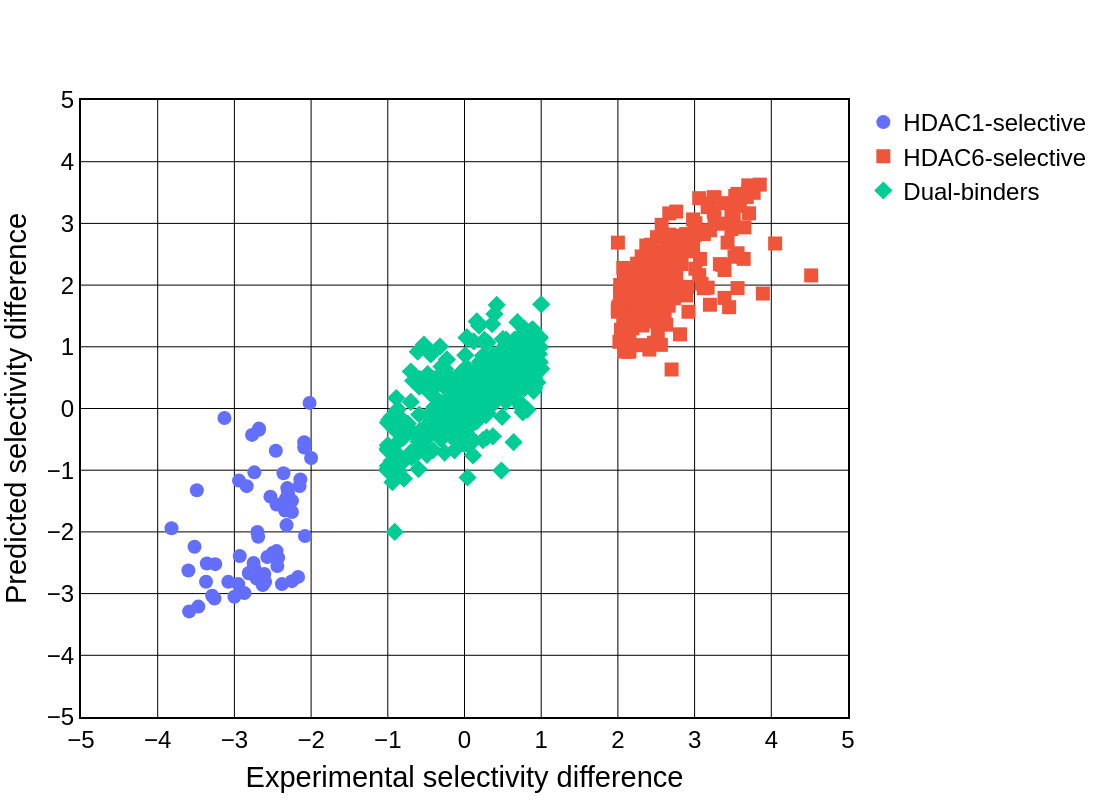

In [39]:
# plot hdac1-selective, hdac6-selective and dual selective compounds in predicted vs experimental plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


#fig = px.scatter(df=HDAC1and6_ref_pred_DF_hdac1Sel, x="SelectivityWindow", y="RF", )
#fig.show() 

dfs = {"HDAC1-selective" : SP_reg_hdac1Sel, "HDAC6-selective": SP_reg_hdac6Sel, "Dual-binders" : SP_reg_dual}



# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["SelectivityWindow"],
                                   y = dfs[i]["all_ave"], 
                                   name = i,mode="markers",marker=dict(size=14, symbol = dfs[i]['Marker']) ), )

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    xaxis_title="Experimental selectivity difference",
    yaxis_title="Predicted selectivity difference",
    template= "plotly_white",
    
    font=dict(
        #family="Courier New, monospace",
        size=24,
        color="Black"
    )
) 
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])

#fig.add_shape( # add a horizontal "target" line
#    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#    x0=-4, x1=5, y0=2, y1=2, )

#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#})

fig.show()

#### Evaluate the Selectivity Profiling approach in terms of its ability to distinguih selective and dual binders from others

In [40]:
SelProf_rf_DualSel = SelProf_rf.copy()
SelProf_rf_DualSel['selectivity'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_DualSel['Dual_sel_rf_test0'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test0'] >= -1)  & (SelProf_rf_DualSel['rf_test0'] <= 1)].index, 'Dual_sel_rf_test0'] =1
SelProf_rf_DualSel['Dual_sel_rf_test1'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test1'] >= -1)  & (SelProf_rf_DualSel['rf_test1'] <= 1)].index, 'Dual_sel_rf_test1'] =1
SelProf_rf_DualSel['Dual_sel_rf_test2'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test2'] >= -1)  & (SelProf_rf_DualSel['rf_test2'] <= 1)].index, 'Dual_sel_rf_test2'] =1
SelProf_rf_DualSel['Dual_sel_rf_test3'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test3'] >= -1)  & (SelProf_rf_DualSel['rf_test3'] <= 1)].index, 'Dual_sel_rf_test3'] =1
SelProf_rf_DualSel['Dual_sel_rf_test4'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test4'] >= -1)  & (SelProf_rf_DualSel['rf_test4'] <= 1)].index, 'Dual_sel_rf_test4'] =1


SP_DualSel = SelProf_rf_DualSel['selectivity']
SP_DualSel_rf_test0 = SelProf_rf_DualSel['Dual_sel_rf_test0']
SP_DualSel_rf_test1 = SelProf_rf_DualSel['Dual_sel_rf_test1']
SP_DualSel_rf_test2 = SelProf_rf_DualSel['Dual_sel_rf_test2']
SP_DualSel_rf_test3 = SelProf_rf_DualSel['Dual_sel_rf_test3']
SP_DualSel_rf_test4 = SelProf_rf_DualSel['Dual_sel_rf_test4']
list_rf = [SP_DualSel_rf_test0, SP_DualSel_rf_test1, SP_DualSel_rf_test2, SP_DualSel_rf_test3, SP_DualSel_rf_test4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SP_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelProf_rf_HDAC1Sel = SelProf_rf.copy()
SelProf_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test0'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test0'] <= -2)].index, 'HDAC1_sel_rf_test0'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test1'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[ (SelProf_rf_HDAC1Sel['rf_test1'] <= -2)].index, 'HDAC1_sel_rf_test1'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test2'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[ (SelProf_rf_HDAC1Sel['rf_test2'] <= -2)].index, 'HDAC1_sel_rf_test2'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test3'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test3'] <= -2)].index, 'HDAC1_sel_rf_test3'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test4'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test4'] <= -2)].index, 'HDAC1_sel_rf_test4'] =1


SP_HDAC1Sel = SelProf_rf_HDAC1Sel['selectivity']
SP_HDAC1Sel_rf_test0 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test0']
SP_HDAC1Sel_rf_test1 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test1']
SP_HDAC1Sel_rf_test2 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test2']
SP_HDAC1Sel_rf_test3 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test3']
SP_HDAC1Sel_rf_test4 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test4']
list_rf = [SP_HDAC1Sel_rf_test0, SP_HDAC1Sel_rf_test1, SP_HDAC1Sel_rf_test2, SP_HDAC1Sel_rf_test3, SP_HDAC1Sel_rf_test4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SP_rf = mat_met_SP_rf.merge(HDAC1_SP_rf_ave, on='Metric')
SelProf_rf_HDAC6Sel = SelProf_rf.copy()
SelProf_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test0'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test0'] >= 2)].index, 'HDAC6_sel_rf_test0'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test1'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[ (SelProf_rf_HDAC6Sel['rf_test1'] >= 2)].index, 'HDAC6_sel_rf_test1'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test2'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[ (SelProf_rf_HDAC6Sel['rf_test2'] >= 2)].index, 'HDAC6_sel_rf_test2'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test3'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test3'] >= 2)].index, 'HDAC6_sel_rf_test3'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test4'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test4'] >= 2)].index, 'HDAC6_sel_rf_test4'] =1


SP_HDAC6Sel = SelProf_rf_HDAC6Sel['selectivity']
SP_HDAC6Sel_rf_test0 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test0']
SP_HDAC6Sel_rf_test1 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test1']
SP_HDAC6Sel_rf_test2 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test2']
SP_HDAC6Sel_rf_test3 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test3']
SP_HDAC6Sel_rf_test4 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test4']
list_rf = [SP_HDAC6Sel_rf_test0, SP_HDAC6Sel_rf_test1, SP_HDAC6Sel_rf_test2, SP_HDAC6Sel_rf_test3, SP_HDAC6Sel_rf_test4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SP_rf = mat_met_SP_rf.merge(HDAC6_SP_rf_ave, on='Metric')
mat_met_SP_rf


,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,473.400000,3.577709,29.800000,1.643168,139.200000,2.683282
1,TN,662.800000,3.768289,1846.000000,0.707107,1614.000000,1.581139
2,FP,715.200000,3.768289,3.000000,0.707107,29.000000,1.581139
3,FN,58.600000,3.577709,31.200000,1.643168,127.800000,2.683282
4,Accuracy,0.594869,0.001588,0.982094,0.001194,0.917906,0.002075
5,Precision,0.398282,0.001360,0.908088,0.023505,0.827554,0.009886
6,Sensitivity,0.889850,0.006725,0.488525,0.026937,0.521348,0.010050
7,Specificity,0.480960,0.002737,0.998380,0.000390,0.982340,0.000996
8,F1 score,0.550268,0.002143,0.635156,0.025075,0.639680,0.009075
9,F1 score (macro),0.590842,0.001440,0.812989,0.012809,0.796678,0.005049


In [41]:
SelProf_lgbm_DualSel = SelProf_lgbm.copy()
SelProf_lgbm_DualSel['selectivity'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test0'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test0'] <= 1)].index, 'Dual_sel_lgbm_test0'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test1'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test1'] <= 1)].index, 'Dual_sel_lgbm_test1'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test2'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test2'] <= 1)].index, 'Dual_sel_lgbm_test2'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test3'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test3'] <= 1)].index, 'Dual_sel_lgbm_test3'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test4'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test4'] <= 1)].index, 'Dual_sel_lgbm_test4'] =1


SP_DualSel = SelProf_lgbm_DualSel['selectivity']
SP_DualSel_lgbm_test0 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test0']
SP_DualSel_lgbm_test1 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test1']
SP_DualSel_lgbm_test2 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test2']
SP_DualSel_lgbm_test3 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test3']
SP_DualSel_lgbm_test4 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test4']
list_lgbm = [SP_DualSel_lgbm_test0, SP_DualSel_lgbm_test1, SP_DualSel_lgbm_test2, SP_DualSel_lgbm_test3, SP_DualSel_lgbm_test4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SP_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelProf_lgbm_HDAC1Sel = SelProf_lgbm.copy()
SelProf_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test0'] <= -2)].index, 'HDAC1_sel_lgbm_test0'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[ (SelProf_lgbm_HDAC1Sel['lgbm_test1'] <= -2)].index, 'HDAC1_sel_lgbm_test1'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[ (SelProf_lgbm_HDAC1Sel['lgbm_test2'] <= -2)].index, 'HDAC1_sel_lgbm_test2'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test3'] <= -2)].index, 'HDAC1_sel_lgbm_test3'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test4'] <= -2)].index, 'HDAC1_sel_lgbm_test4'] =1


SP_HDAC1Sel = SelProf_lgbm_HDAC1Sel['selectivity']
SP_HDAC1Sel_lgbm_test0 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test0']
SP_HDAC1Sel_lgbm_test1 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test1']
SP_HDAC1Sel_lgbm_test2 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test2']
SP_HDAC1Sel_lgbm_test3 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test3']
SP_HDAC1Sel_lgbm_test4 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test4']
list_lgbm = [SP_HDAC1Sel_lgbm_test0, SP_HDAC1Sel_lgbm_test1, SP_HDAC1Sel_lgbm_test2, SP_HDAC1Sel_lgbm_test3, SP_HDAC1Sel_lgbm_test4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC1_SP_lgbm_ave, on='Metric')
SelProf_lgbm_HDAC6Sel = SelProf_lgbm.copy()
SelProf_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test0'] >= 2)].index, 'HDAC6_sel_lgbm_test0'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[ (SelProf_lgbm_HDAC6Sel['lgbm_test1'] >= 2)].index, 'HDAC6_sel_lgbm_test1'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[ (SelProf_lgbm_HDAC6Sel['lgbm_test2'] >= 2)].index, 'HDAC6_sel_lgbm_test2'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test3'] >= 2)].index, 'HDAC6_sel_lgbm_test3'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test4'] >= 2)].index, 'HDAC6_sel_lgbm_test4'] =1


SP_HDAC6Sel = SelProf_lgbm_HDAC6Sel['selectivity']
SP_HDAC6Sel_lgbm_test0 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test0']
SP_HDAC6Sel_lgbm_test1 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test1']
SP_HDAC6Sel_lgbm_test2 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test2']
SP_HDAC6Sel_lgbm_test3 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test3']
SP_HDAC6Sel_lgbm_test4 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test4']
list_lgbm = [SP_HDAC6Sel_lgbm_test0, SP_HDAC6Sel_lgbm_test1, SP_HDAC6Sel_lgbm_test2, SP_HDAC6Sel_lgbm_test3, SP_HDAC6Sel_lgbm_test4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC6_SP_lgbm_ave, on='Metric')
mat_met_SP_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,444.600000,5.029911,33.000000,1.000000,153.800000,3.420526
1,TN,730.000000,4.949747,1842.800000,1.303840,1599.600000,2.607681
2,FP,648.000000,4.949747,6.200000,1.303840,43.400000,2.607681
3,FN,87.400000,5.029911,28.000000,1.000000,113.200000,3.420526
4,Accuracy,0.614974,0.004149,0.982094,0.000683,0.918010,0.002834
5,Precision,0.406917,0.003673,0.842665,0.026453,0.779913,0.012921
6,Sensitivity,0.835714,0.009455,0.540984,0.016393,0.576030,0.012811
7,Specificity,0.529760,0.003576,0.996660,0.000702,0.973580,0.001597
8,F1 score,0.547329,0.004643,0.658638,0.011484,0.662618,0.011133
9,F1 score (macro),0.606177,0.003817,0.824722,0.005879,0.807976,0.006273


In [42]:
SelProf_xgb_DualSel = SelProf_xgb.copy()
SelProf_xgb_DualSel['selectivity'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test0'] >= -1)  & (SelProf_xgb_DualSel['xgb_test0'] <= 1)].index, 'Dual_sel_xgb_test0'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test1'] >= -1)  & (SelProf_xgb_DualSel['xgb_test1'] <= 1)].index, 'Dual_sel_xgb_test1'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test2'] >= -1)  & (SelProf_xgb_DualSel['xgb_test2'] <= 1)].index, 'Dual_sel_xgb_test2'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test3'] >= -1)  & (SelProf_xgb_DualSel['xgb_test3'] <= 1)].index, 'Dual_sel_xgb_test3'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test4'] >= -1)  & (SelProf_xgb_DualSel['xgb_test4'] <= 1)].index, 'Dual_sel_xgb_test4'] =1


SP_DualSel = SelProf_xgb_DualSel['selectivity']
SP_DualSel_xgb_test0 = SelProf_xgb_DualSel['Dual_sel_xgb_test0']
SP_DualSel_xgb_test1 = SelProf_xgb_DualSel['Dual_sel_xgb_test1']
SP_DualSel_xgb_test2 = SelProf_xgb_DualSel['Dual_sel_xgb_test2']
SP_DualSel_xgb_test3 = SelProf_xgb_DualSel['Dual_sel_xgb_test3']
SP_DualSel_xgb_test4 = SelProf_xgb_DualSel['Dual_sel_xgb_test4']
list_xgb = [SP_DualSel_xgb_test0, SP_DualSel_xgb_test1, SP_DualSel_xgb_test2, SP_DualSel_xgb_test3, SP_DualSel_xgb_test4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SP_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelProf_xgb_HDAC1Sel = SelProf_xgb.copy()
SelProf_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test0'] <= -2)].index, 'HDAC1_sel_xgb_test0'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[ (SelProf_xgb_HDAC1Sel['xgb_test1'] <= -2)].index, 'HDAC1_sel_xgb_test1'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[ (SelProf_xgb_HDAC1Sel['xgb_test2'] <= -2)].index, 'HDAC1_sel_xgb_test2'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test3'] <= -2)].index, 'HDAC1_sel_xgb_test3'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test4'] <= -2)].index, 'HDAC1_sel_xgb_test4'] =1


SP_HDAC1Sel = SelProf_xgb_HDAC1Sel['selectivity']
SP_HDAC1Sel_xgb_test0 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test0']
SP_HDAC1Sel_xgb_test1 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test1']
SP_HDAC1Sel_xgb_test2 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test2']
SP_HDAC1Sel_xgb_test3 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test3']
SP_HDAC1Sel_xgb_test4 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test4']
list_xgb = [SP_HDAC1Sel_xgb_test0, SP_HDAC1Sel_xgb_test1, SP_HDAC1Sel_xgb_test2, SP_HDAC1Sel_xgb_test3, SP_HDAC1Sel_xgb_test4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC1_SP_xgb_ave, on='Metric')
SelProf_xgb_HDAC6Sel = SelProf_xgb.copy()
SelProf_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test0'] >= 2)].index, 'HDAC6_sel_xgb_test0'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[ (SelProf_xgb_HDAC6Sel['xgb_test1'] >= 2)].index, 'HDAC6_sel_xgb_test1'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[ (SelProf_xgb_HDAC6Sel['xgb_test2'] >= 2)].index, 'HDAC6_sel_xgb_test2'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test3'] >= 2)].index, 'HDAC6_sel_xgb_test3'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test4'] >= 2)].index, 'HDAC6_sel_xgb_test4'] =1


SP_HDAC6Sel = SelProf_xgb_HDAC6Sel['selectivity']
SP_HDAC6Sel_xgb_test0 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test0']
SP_HDAC6Sel_xgb_test1 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test1']
SP_HDAC6Sel_xgb_test2 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test2']
SP_HDAC6Sel_xgb_test3 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test3']
SP_HDAC6Sel_xgb_test4 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test4']
list_xgb = [SP_HDAC6Sel_xgb_test0, SP_HDAC6Sel_xgb_test1, SP_HDAC6Sel_xgb_test2, SP_HDAC6Sel_xgb_test3, SP_HDAC6Sel_xgb_test4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC6_SP_xgb_ave, on='Metric')
mat_met_SP_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,455.000000,4.301163,34.800000,0.836660,139.800000,1.303840
1,TN,729.400000,4.615192,1843.600000,0.547723,1604.400000,3.646917
2,FP,648.600000,4.615192,5.400000,0.547723,38.600000,3.646917
3,FN,77.000000,4.301163,26.200000,0.836660,127.200000,1.303840
4,Accuracy,0.620105,0.001721,0.983455,0.000287,0.913194,0.002264
5,Precision,0.412284,0.001561,0.865878,0.009732,0.783862,0.016924
6,Sensitivity,0.855263,0.008085,0.570492,0.013716,0.523596,0.004883
7,Specificity,0.529320,0.003362,0.997100,0.000274,0.976500,0.002228
8,F1 score,0.556362,0.002548,0.687675,0.007454,0.627780,0.006863
9,F1 score (macro),0.612092,0.001585,0.839589,0.003786,0.789324,0.004007


In [43]:
SelProf_knn_DualSel = SelProf_knn.copy()
SelProf_knn_DualSel['selectivity'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_DualSel['Dual_sel_knn_test0'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test0'] >= -1)  & (SelProf_knn_DualSel['knn_test0'] <= 1)].index, 'Dual_sel_knn_test0'] =1
SelProf_knn_DualSel['Dual_sel_knn_test1'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test1'] >= -1)  & (SelProf_knn_DualSel['knn_test1'] <= 1)].index, 'Dual_sel_knn_test1'] =1
SelProf_knn_DualSel['Dual_sel_knn_test2'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test2'] >= -1)  & (SelProf_knn_DualSel['knn_test2'] <= 1)].index, 'Dual_sel_knn_test2'] =1
SelProf_knn_DualSel['Dual_sel_knn_test3'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test3'] >= -1)  & (SelProf_knn_DualSel['knn_test3'] <= 1)].index, 'Dual_sel_knn_test3'] =1
SelProf_knn_DualSel['Dual_sel_knn_test4'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test4'] >= -1)  & (SelProf_knn_DualSel['knn_test4'] <= 1)].index, 'Dual_sel_knn_test4'] =1


SP_DualSel = SelProf_knn_DualSel['selectivity']
SP_DualSel_knn_test0 = SelProf_knn_DualSel['Dual_sel_knn_test0']
SP_DualSel_knn_test1 = SelProf_knn_DualSel['Dual_sel_knn_test1']
SP_DualSel_knn_test2 = SelProf_knn_DualSel['Dual_sel_knn_test2']
SP_DualSel_knn_test3 = SelProf_knn_DualSel['Dual_sel_knn_test3']
SP_DualSel_knn_test4 = SelProf_knn_DualSel['Dual_sel_knn_test4']
list_knn = [SP_DualSel_knn_test0, SP_DualSel_knn_test1, SP_DualSel_knn_test2, SP_DualSel_knn_test3, SP_DualSel_knn_test4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SP_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelProf_knn_HDAC1Sel = SelProf_knn.copy()
SelProf_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test0'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test0'] <= -2)].index, 'HDAC1_sel_knn_test0'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test1'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[ (SelProf_knn_HDAC1Sel['knn_test1'] <= -2)].index, 'HDAC1_sel_knn_test1'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test2'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[ (SelProf_knn_HDAC1Sel['knn_test2'] <= -2)].index, 'HDAC1_sel_knn_test2'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test3'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test3'] <= -2)].index, 'HDAC1_sel_knn_test3'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test4'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test4'] <= -2)].index, 'HDAC1_sel_knn_test4'] =1


SP_HDAC1Sel = SelProf_knn_HDAC1Sel['selectivity']
SP_HDAC1Sel_knn_test0 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test0']
SP_HDAC1Sel_knn_test1 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test1']
SP_HDAC1Sel_knn_test2 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test2']
SP_HDAC1Sel_knn_test3 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test3']
SP_HDAC1Sel_knn_test4 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test4']
list_knn = [SP_HDAC1Sel_knn_test0, SP_HDAC1Sel_knn_test1, SP_HDAC1Sel_knn_test2, SP_HDAC1Sel_knn_test3, SP_HDAC1Sel_knn_test4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SP_knn = mat_met_SP_knn.merge(HDAC1_SP_knn_ave, on='Metric')
SelProf_knn_HDAC6Sel = SelProf_knn.copy()
SelProf_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test0'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test0'] >= 2)].index, 'HDAC6_sel_knn_test0'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test1'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[ (SelProf_knn_HDAC6Sel['knn_test1'] >= 2)].index, 'HDAC6_sel_knn_test1'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test2'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[ (SelProf_knn_HDAC6Sel['knn_test2'] >= 2)].index, 'HDAC6_sel_knn_test2'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test3'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test3'] >= 2)].index, 'HDAC6_sel_knn_test3'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test4'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test4'] >= 2)].index, 'HDAC6_sel_knn_test4'] =1


SP_HDAC6Sel = SelProf_knn_HDAC6Sel['selectivity']
SP_HDAC6Sel_knn_test0 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test0']
SP_HDAC6Sel_knn_test1 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test1']
SP_HDAC6Sel_knn_test2 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test2']
SP_HDAC6Sel_knn_test3 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test3']
SP_HDAC6Sel_knn_test4 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test4']
list_knn = [SP_HDAC6Sel_knn_test0, SP_HDAC6Sel_knn_test1, SP_HDAC6Sel_knn_test2, SP_HDAC6Sel_knn_test3, SP_HDAC6Sel_knn_test4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SP_knn = mat_met_SP_knn.merge(HDAC6_SP_knn_ave, on='Metric')
mat_met_SP_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.000000,3.391165,34.400000,1.140175,175.000000,4.000000
1,TN,778.600000,6.985700,1846.200000,0.836660,1592.400000,2.073644
2,FP,599.400000,6.985700,2.800000,0.836660,50.600000,2.073644
3,FN,85.000000,3.391165,26.600000,1.140175,92.000000,4.000000
4,Accuracy,0.641675,0.003324,0.984607,0.000468,0.925340,0.002554
5,Precision,0.427188,0.002662,0.925328,0.019079,0.775691,0.008904
6,Sensitivity,0.840226,0.006374,0.563934,0.018691,0.655431,0.014981
7,Specificity,0.565020,0.005076,0.998480,0.000455,0.969220,0.001274
8,F1 score,0.566397,0.002709,0.700482,0.010953,0.710461,0.010261
9,F1 score (macro),0.630535,0.002730,0.846292,0.005573,0.833803,0.005761


In [44]:
SelProf_svm_DualSel = SelProf_svm.copy()
SelProf_svm_DualSel['selectivity'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_DualSel['Dual_sel_svm_test0'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test0'] >= -1)  & (SelProf_svm_DualSel['svm_test0'] <= 1)].index, 'Dual_sel_svm_test0'] =1
SelProf_svm_DualSel['Dual_sel_svm_test1'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test1'] >= -1)  & (SelProf_svm_DualSel['svm_test1'] <= 1)].index, 'Dual_sel_svm_test1'] =1
SelProf_svm_DualSel['Dual_sel_svm_test2'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test2'] >= -1)  & (SelProf_svm_DualSel['svm_test2'] <= 1)].index, 'Dual_sel_svm_test2'] =1
SelProf_svm_DualSel['Dual_sel_svm_test3'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test3'] >= -1)  & (SelProf_svm_DualSel['svm_test3'] <= 1)].index, 'Dual_sel_svm_test3'] =1
SelProf_svm_DualSel['Dual_sel_svm_test4'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test4'] >= -1)  & (SelProf_svm_DualSel['svm_test4'] <= 1)].index, 'Dual_sel_svm_test4'] =1


SP_DualSel = SelProf_svm_DualSel['selectivity']
SP_DualSel_svm_test0 = SelProf_svm_DualSel['Dual_sel_svm_test0']
SP_DualSel_svm_test1 = SelProf_svm_DualSel['Dual_sel_svm_test1']
SP_DualSel_svm_test2 = SelProf_svm_DualSel['Dual_sel_svm_test2']
SP_DualSel_svm_test3 = SelProf_svm_DualSel['Dual_sel_svm_test3']
SP_DualSel_svm_test4 = SelProf_svm_DualSel['Dual_sel_svm_test4']
list_svm = [SP_DualSel_svm_test0, SP_DualSel_svm_test1, SP_DualSel_svm_test2, SP_DualSel_svm_test3, SP_DualSel_svm_test4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SP_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelProf_svm_HDAC1Sel = SelProf_svm.copy()
SelProf_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test0'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test0'] <= -2)].index, 'HDAC1_sel_svm_test0'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test1'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[ (SelProf_svm_HDAC1Sel['svm_test1'] <= -2)].index, 'HDAC1_sel_svm_test1'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test2'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[ (SelProf_svm_HDAC1Sel['svm_test2'] <= -2)].index, 'HDAC1_sel_svm_test2'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test3'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test3'] <= -2)].index, 'HDAC1_sel_svm_test3'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test4'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test4'] <= -2)].index, 'HDAC1_sel_svm_test4'] =1


SP_HDAC1Sel = SelProf_svm_HDAC1Sel['selectivity']
SP_HDAC1Sel_svm_test0 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test0']
SP_HDAC1Sel_svm_test1 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test1']
SP_HDAC1Sel_svm_test2 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test2']
SP_HDAC1Sel_svm_test3 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test3']
SP_HDAC1Sel_svm_test4 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test4']
list_svm = [SP_HDAC1Sel_svm_test0, SP_HDAC1Sel_svm_test1, SP_HDAC1Sel_svm_test2, SP_HDAC1Sel_svm_test3, SP_HDAC1Sel_svm_test4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SP_svm = mat_met_SP_svm.merge(HDAC1_SP_svm_ave, on='Metric')
SelProf_svm_HDAC6Sel = SelProf_svm.copy()
SelProf_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test0'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test0'] >= 2)].index, 'HDAC6_sel_svm_test0'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test1'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[ (SelProf_svm_HDAC6Sel['svm_test1'] >= 2)].index, 'HDAC6_sel_svm_test1'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test2'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[ (SelProf_svm_HDAC6Sel['svm_test2'] >= 2)].index, 'HDAC6_sel_svm_test2'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test3'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test3'] >= 2)].index, 'HDAC6_sel_svm_test3'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test4'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test4'] >= 2)].index, 'HDAC6_sel_svm_test4'] =1


SP_HDAC6Sel = SelProf_svm_HDAC6Sel['selectivity']
SP_HDAC6Sel_svm_test0 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test0']
SP_HDAC6Sel_svm_test1 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test1']
SP_HDAC6Sel_svm_test2 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test2']
SP_HDAC6Sel_svm_test3 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test3']
SP_HDAC6Sel_svm_test4 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test4']
list_svm = [SP_HDAC6Sel_svm_test0, SP_HDAC6Sel_svm_test1, SP_HDAC6Sel_svm_test2, SP_HDAC6Sel_svm_test3, SP_HDAC6Sel_svm_test4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SP_svm = mat_met_SP_svm.merge(HDAC6_SP_svm_ave, on='Metric')
mat_met_SP_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,464.000000,2.449490,32.600000,0.894427,140.600000,3.507136
1,TN,712.800000,7.726578,1844.600000,0.547723,1610.200000,3.033150
2,FP,665.200000,7.726578,4.400000,0.547723,32.800000,3.033150
3,FN,68.000000,2.449490,28.400000,0.894427,126.400000,3.507136
4,Accuracy,0.616126,0.004079,0.982827,0.000438,0.916649,0.002756
5,Precision,0.410923,0.002918,0.881268,0.011996,0.810929,0.015929
6,Sensitivity,0.872180,0.004604,0.534426,0.014663,0.526592,0.013135
7,Specificity,0.517280,0.005600,0.997600,0.000274,0.980040,0.001860
8,F1 score,0.558639,0.002798,0.665221,0.010160,0.638476,0.011444
9,F1 score (macro),0.609496,0.003389,0.828204,0.005174,0.795685,0.006392


In [45]:
SelProf_ave_DualSel = selectivity_profile_reg.copy()
SelProf_ave_DualSel['selectivity'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['rf_test_ave'] >= -1)  & (SelProf_ave_DualSel['rf_test_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelProf_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['lgbm_test_ave'] >= -1)  & (SelProf_ave_DualSel['lgbm_test_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelProf_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['xgb_test_ave'] >= -1)  & (SelProf_ave_DualSel['xgb_test_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelProf_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['knn_test_ave'] >= -1)  & (SelProf_ave_DualSel['knn_test_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelProf_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['svm_test_ave'] >= -1)  & (SelProf_ave_DualSel['svm_test_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SP_DualSel = SelProf_ave_DualSel['selectivity']
SP_DualSel_ave_rf = SelProf_ave_DualSel['Dual_sel_ave_rf']
SP_DualSel_ave_lgbm = SelProf_ave_DualSel['Dual_sel_ave_lgbm']
SP_DualSel_ave_xgb = SelProf_ave_DualSel['Dual_sel_ave_xgb']
SP_DualSel_ave_knn = SelProf_ave_DualSel['Dual_sel_ave_knn']
SP_DualSel_ave_svm = SelProf_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SP_DualSel_ave_rf, SP_DualSel_ave_lgbm, SP_DualSel_ave_xgb, SP_DualSel_ave_knn, SP_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SP_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelProf_ave_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['rf_test_ave'] <= -2)].index, 'HDAC1_sel_ave_rf'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[ (SelProf_ave_HDAC1Sel['lgbm_test_ave'] <= -2)].index, 'HDAC1_sel_ave_lgbm'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[ (SelProf_ave_HDAC1Sel['xgb_test_ave'] <= -2)].index, 'HDAC1_sel_ave_xgb'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['knn_test_ave'] <= -2)].index, 'HDAC1_sel_ave_knn'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['svm_test_ave'] <= -2)].index, 'HDAC1_sel_ave_svm'] =1


SP_HDAC1Sel = SelProf_ave_HDAC1Sel['selectivity']
SP_HDAC1Sel_ave_rf = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SP_HDAC1Sel_ave_lgbm = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SP_HDAC1Sel_ave_xgb = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SP_HDAC1Sel_ave_knn = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SP_HDAC1Sel_ave_svm = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SP_HDAC1Sel_ave_rf, SP_HDAC1Sel_ave_lgbm, SP_HDAC1Sel_ave_xgb, SP_HDAC1Sel_ave_knn, SP_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SP_ave = mat_met_SP_ave.merge(HDAC1_SP_ave, on='Metric')

SelProf_ave_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['rf_test_ave'] >= 2)].index, 'HDAC6_sel_ave_rf'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[ (SelProf_ave_HDAC6Sel['lgbm_test_ave'] >= 2)].index, 'HDAC6_sel_ave_lgbm'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[ (SelProf_ave_HDAC6Sel['xgb_test_ave'] >= 2)].index, 'HDAC6_sel_ave_xgb'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['knn_test_ave'] >= 2)].index, 'HDAC6_sel_ave_knn'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['svm_test_ave'] >= 2)].index, 'HDAC6_sel_ave_svm'] =1


SP_HDAC6Sel = SelProf_ave_HDAC6Sel['selectivity']
SP_HDAC6Sel_ave_rf = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SP_HDAC6Sel_ave_lgbm = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SP_HDAC6Sel_ave_xgb = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SP_HDAC6Sel_ave_knn = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SP_HDAC6Sel_ave_svm = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SP_HDAC6Sel_ave_rf, SP_HDAC6Sel_ave_lgbm, SP_HDAC6Sel_ave_xgb, SP_HDAC6Sel_ave_knn, SP_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SP_ave = mat_met_SP_ave.merge(HDAC6_SP_ave, on='Metric')
mat_met_SP_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,479.200000,9.959920,34.200000,1.923538,161.200000,13.754999
1,TN,734.800000,31.051570,1846.600000,0.894427,1617.600000,5.176872
2,FP,643.200000,31.051570,2.400000,0.894427,25.400000,5.176872
3,FN,52.800000,9.959920,26.800000,1.923538,105.800000,13.754999
4,Accuracy,0.635602,0.012685,0.984712,0.001007,0.931309,0.004600
5,Precision,0.427144,0.008543,0.934933,0.022361,0.864887,0.013478
6,Sensitivity,0.900752,0.018722,0.560656,0.031533,0.603745,0.051517
7,Specificity,0.533260,0.022545,0.998720,0.000487,0.984540,0.003148
8,F1 score,0.579367,0.006247,0.700434,0.022757,0.709773,0.026723
9,F1 score (macro),0.628872,0.009932,0.846295,0.011602,0.835405,0.014436


In [46]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelProf_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SP_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SP_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SP_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SP_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SP_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SP_ave.to_excel(writer, sheet_name="AVERAGE", )

# Testing Selectivity Window Regression Models with NoSemiSel   models

In [47]:
#By using Morgan fingerprints with radius of 3 and 1025 bits
X_hdac1and6_SW = np.array(list((hdac1and6['fp_Morgan3']))).astype(float)
#X.shape
y_hdac1and6_SW = hdac1and6["SelectivityWindow"].values
y_hdac1and6_SW_cat = hdac1and6["selectivity"].values
y_hdac1and6_SW_class = hdac1and6["Class"].values

In [48]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_rf.joblib")
        optimizedCV_rf.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_rf_cat = np.where(((y_pred_optimized_rf >= 2.0) | (y_pred_optimized_rf <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_HDAC1and6_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
rf_HDAC1and6_run0.reset_index(inplace=True, drop=True)
rf_HDAC1and6_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
rf_HDAC1and6_run1.reset_index(inplace=True, drop=True)
rf_HDAC1and6_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
rf_HDAC1and6_run2.reset_index(inplace=True, drop=True)
rf_HDAC1and6_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
rf_HDAC1and6_run3.reset_index(inplace=True, drop=True)
rf_HDAC1and6_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
rf_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
rf_5preds_HDAC1and6 = pd.concat([chembl_id, rf_HDAC1and6_run0, rf_HDAC1and6_run1, rf_HDAC1and6_run2, rf_HDAC1and6_run3, rf_HDAC1and6_run4], axis=1)
rf_5preds_HDAC1and6 = rf_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds_HDAC1and6['y_pred_rf_ave'] = rf_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds_HDAC1and6['y_pred_rf_std'] = rf_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [49]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_lgbm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_lgbm.joblib")
        optimizedCV_lgbm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where(((y_pred_optimized_lgbm >= 2.0) | (y_pred_optimized_lgbm <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_HDAC1and6_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_HDAC1and6_run0.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_HDAC1and6_run1.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_HDAC1and6_run2.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_HDAC1and6_run3.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
lgbm_5preds_HDAC1and6 = pd.concat([chembl_id, lgbm_HDAC1and6_run0, lgbm_HDAC1and6_run1, lgbm_HDAC1and6_run2, lgbm_HDAC1and6_run3, lgbm_HDAC1and6_run4], axis=1)
lgbm_5preds_HDAC1and6 = lgbm_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds_HDAC1and6['y_pred_lgbm_ave'] = lgbm_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds_HDAC1and6['y_pred_lgbm_std'] = lgbm_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [50]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_xgb=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_xgb.joblib")
        optimizedCV_xgb.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_xgb_cat = np.where(((y_pred_optimized_xgb >= 2.0) | (y_pred_optimized_xgb <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_HDAC1and6_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_HDAC1and6_run0.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_HDAC1and6_run1.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_HDAC1and6_run2.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_HDAC1and6_run3.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
xgb_5preds_HDAC1and6 = pd.concat([chembl_id, xgb_HDAC1and6_run0, xgb_HDAC1and6_run1, xgb_HDAC1and6_run2, xgb_HDAC1and6_run3, xgb_HDAC1and6_run4], axis=1)
xgb_5preds_HDAC1and6 = xgb_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds_HDAC1and6['y_pred_xgb_ave'] = xgb_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds_HDAC1and6['y_pred_xgb_std'] = xgb_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [51]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_knn.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_knn_cat = np.where(((y_pred_optimized_knn >= 2.0) | (y_pred_optimized_knn <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_HDAC1and6_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
knn_HDAC1and6_run0.reset_index(inplace=True, drop=True)
knn_HDAC1and6_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
knn_HDAC1and6_run1.reset_index(inplace=True, drop=True)
knn_HDAC1and6_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
knn_HDAC1and6_run2.reset_index(inplace=True, drop=True)
knn_HDAC1and6_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
knn_HDAC1and6_run3.reset_index(inplace=True, drop=True)
knn_HDAC1and6_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
knn_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_HDAC1and6 = pd.concat([chembl_id, knn_HDAC1and6_run0, knn_HDAC1and6_run1, knn_HDAC1and6_run2, knn_HDAC1and6_run3, knn_HDAC1and6_run4], axis=1)
knn_5preds_HDAC1and6 = knn_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_HDAC1and6['y_pred_knn_ave'] = knn_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_HDAC1and6['y_pred_knn_std'] = knn_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [52]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_svm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_svm.joblib")
        optimizedCV_svm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_svm_cat = np.where(((y_pred_optimized_svm >= 2.0) | (y_pred_optimized_svm <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_HDAC1and6_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_HDAC1and6_run0.sort_values(by='y_test_idx0', inplace=True)
svm_HDAC1and6_run0.reset_index(inplace=True, drop=True)
svm_HDAC1and6_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_HDAC1and6_run1.sort_values(by='y_test_idx1', inplace=True)
svm_HDAC1and6_run1.reset_index(inplace=True, drop=True)
svm_HDAC1and6_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_HDAC1and6_run2.sort_values(by='y_test_idx2', inplace=True)
svm_HDAC1and6_run2.reset_index(inplace=True, drop=True)
svm_HDAC1and6_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_HDAC1and6_run3.sort_values(by='y_test_idx3', inplace=True)
svm_HDAC1and6_run3.reset_index(inplace=True, drop=True)
svm_HDAC1and6_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_HDAC1and6_run4.sort_values(by='y_test_idx4', inplace=True)
svm_HDAC1and6_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
svm_5preds_HDAC1and6 = pd.concat([chembl_id, svm_HDAC1and6_run0, svm_HDAC1and6_run1, svm_HDAC1and6_run2, svm_HDAC1and6_run3, svm_HDAC1and6_run4], axis=1)
svm_5preds_HDAC1and6 = svm_5preds_HDAC1and6[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds_HDAC1and6['y_pred_svm_ave'] = svm_5preds_HDAC1and6.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds_HDAC1and6['y_pred_svm_std'] = svm_5preds_HDAC1and6.iloc[:,2:].std(axis='columns', numeric_only=True)


In [53]:
SelWin_rf = rf_5preds_HDAC1and6.copy()
SelWin_rf = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_rf, on=['molecule_chembl_id', ], how='inner')
SelWin_rf.drop(['y_test_idx0', 'y_pred_rf_std'], axis=1, inplace=True)

SelWin_lgbm = lgbm_5preds_HDAC1and6.copy()
SelWin_lgbm = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_lgbm, on=['molecule_chembl_id', ], how='inner')
SelWin_lgbm.drop(['y_test_idx0', 'y_pred_lgbm_std'], axis=1, inplace=True)

SelWin_xgb = xgb_5preds_HDAC1and6.copy()
SelWin_xgb = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_xgb, on=['molecule_chembl_id', ], how='inner')
SelWin_xgb.drop(['y_test_idx0', 'y_pred_xgb_std'], axis=1, inplace=True)

SelWin_knn = knn_5preds_HDAC1and6.copy()
SelWin_knn = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_knn, on=['molecule_chembl_id', ], how='inner')
SelWin_knn.drop(['y_test_idx0', 'y_pred_knn_std'], axis=1, inplace=True)

SelWin_svm = svm_5preds_HDAC1and6.copy()
SelWin_svm = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_svm, on=['molecule_chembl_id', ], how='inner')
SelWin_svm.drop(['y_test_idx0', 'y_pred_svm_std'], axis=1, inplace=True)


In [54]:
selectivity_window_reg = pd.concat([SelWin_rf[['molecule_chembl_id', 'SelectivityWindow', 'label', 'y_pred_rf_ave']], SelWin_lgbm['y_pred_lgbm_ave'], 
                                    SelWin_xgb['y_pred_xgb_ave'], SelWin_knn['y_pred_knn_ave'],
                                     SelWin_svm['y_pred_svm_ave']], axis=1)

selectivity_window_reg['all_ave'] = (selectivity_window_reg['y_pred_rf_ave'] +
                                      selectivity_window_reg['y_pred_lgbm_ave']+
                                     selectivity_window_reg['y_pred_xgb_ave']+
                                     selectivity_window_reg['y_pred_knn_ave']+
                                     selectivity_window_reg['y_pred_svm_ave'])/5

selectivity_window_reg

,molecule_chembl_id,SelectivityWindow,label,y_pred_rf_ave,y_pred_lgbm_ave,y_pred_xgb_ave,y_pred_knn_ave,y_pred_svm_ave,all_ave
0,CHEMBL4098975,2.89,HDAC6-selective,1.675628,1.742808,1.951421,1.787200,1.770571,1.785525
1,CHEMBL3912061,3.56,HDAC6-selective,2.624069,2.661901,2.666755,2.854343,2.374889,2.636391
2,CHEMBL4243347,1.00,Dual-binder,1.859619,1.667380,1.792596,1.709968,1.545253,1.714963
3,CHEMBL4247128,2.52,HDAC6-selective,1.951621,1.904935,2.074571,1.853854,1.777693,1.912535
4,CHEMBL4126811,3.12,HDAC6-selective,1.410947,1.592150,1.509901,1.718668,1.803004,1.606934
...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.216401,1.520980,1.510701,1.594209,1.223835,1.413225
1906,CHEMBL4282471,1.46,Semi-selective,2.559065,2.225103,2.302362,2.636159,2.528525,2.450243
1907,CHEMBL470843,1.56,Semi-selective,0.661263,0.603617,0.787392,1.302146,0.636670,0.798218
1908,CHEMBL3215861,-0.94,Dual-binder,-0.838281,-0.863074,-0.928906,-1.031667,-0.948437,-0.922073


In [55]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_Results.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    SelWin_rf.to_excel(writer, sheet_name="RF", )
    SelWin_lgbm.to_excel(writer, sheet_name="LGBM", )
    SelWin_xgb.to_excel(writer, sheet_name="XGB", )
    SelWin_knn.to_excel(writer, sheet_name="KNN", )
    SelWin_svm.to_excel(writer, sheet_name="SVM", )
    selectivity_profile_reg.to_excel(writer, sheet_name="AVERAGE", )

In [56]:
SW_reg_hdac1Sel = selectivity_window_reg[selectivity_window_reg['label'] =='HDAC1-selective']
SW_reg_hdac6Sel = selectivity_window_reg[selectivity_window_reg['label'] =='HDAC6-selective']
SW_reg_dual = selectivity_window_reg[selectivity_window_reg['label'] =='Dual-binder']

In [57]:
SW_reg_hdac1Sel['Marker']=0
SW_reg_hdac6Sel['Marker']=1
SW_reg_dual['Marker']=2

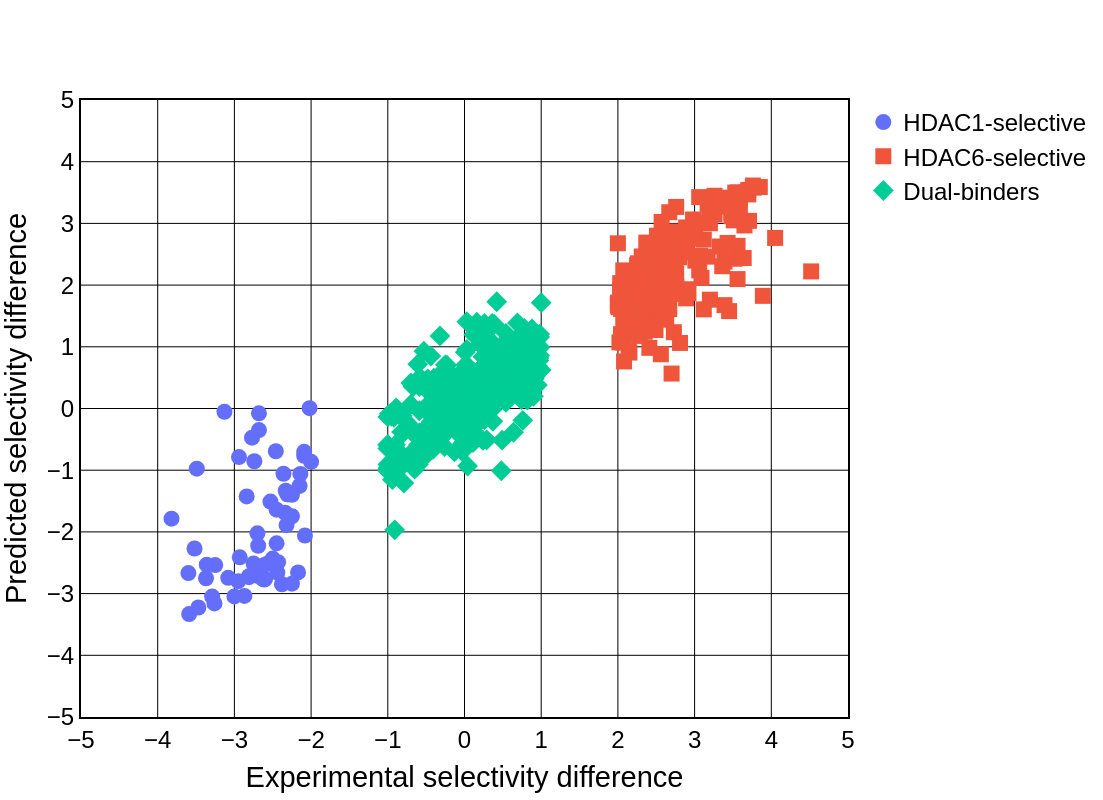

In [58]:
# plot hdac1-selective, hdac6-selective and dual selective compounds in predicted vs experimental plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


#fig = px.scatter(df=HDAC1and6_ref_pred_DF_hdac1Sel, x="SelectivityWindow", y="RF", )
#fig.show() 

dfs = {"HDAC1-selective" : SW_reg_hdac1Sel, "HDAC6-selective": SW_reg_hdac6Sel, "Dual-binders" : SW_reg_dual}




# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["SelectivityWindow"],
                                   y = dfs[i]["all_ave"], 
                                   name = i,mode="markers",marker=dict(size=16, symbol = dfs[i]['Marker']) ), )

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    xaxis_title="Experimental selectivity difference",
    yaxis_title="Predicted selectivity difference",
    template= "plotly_white",
    
    font=dict(
        #family="Courier New, monospace",
        size=24,
        color="Black"
    )
) 
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])

#fig.add_shape( # add a horizontal "target" line
#    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#    x0=-4, x1=5, y0=2, y1=2, )

#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#})

fig.show()

In [59]:
SelWin_rf_DualSel = SelWin_rf.copy()
SelWin_rf_DualSel['selectivity'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf0'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf0'] <= 1)].index, 'Dual_sel_y_pred_rf0'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf1'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf1'] <= 1)].index, 'Dual_sel_y_pred_rf1'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf2'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf2'] <= 1)].index, 'Dual_sel_y_pred_rf2'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf3'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf3'] <= 1)].index, 'Dual_sel_y_pred_rf3'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf4'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf4'] <= 1)].index, 'Dual_sel_y_pred_rf4'] =1


SW_DualSel = SelWin_rf_DualSel['selectivity']
SW_DualSel_y_pred_rf0 = SelWin_rf_DualSel['Dual_sel_y_pred_rf0']
SW_DualSel_y_pred_rf1 = SelWin_rf_DualSel['Dual_sel_y_pred_rf1']
SW_DualSel_y_pred_rf2 = SelWin_rf_DualSel['Dual_sel_y_pred_rf2']
SW_DualSel_y_pred_rf3 = SelWin_rf_DualSel['Dual_sel_y_pred_rf3']
SW_DualSel_y_pred_rf4 = SelWin_rf_DualSel['Dual_sel_y_pred_rf4']
list_rf = [SW_DualSel_y_pred_rf0, SW_DualSel_y_pred_rf1, SW_DualSel_y_pred_rf2, SW_DualSel_y_pred_rf3, SW_DualSel_y_pred_rf4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SW_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelWin_rf_HDAC1Sel = SelWin_rf.copy()
SelWin_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf0'] <= -2)].index, 'HDAC1_sel_y_pred_rf0'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[ (SelWin_rf_HDAC1Sel['y_pred_rf1'] <= -2)].index, 'HDAC1_sel_y_pred_rf1'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[ (SelWin_rf_HDAC1Sel['y_pred_rf2'] <= -2)].index, 'HDAC1_sel_y_pred_rf2'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf3'] <= -2)].index, 'HDAC1_sel_y_pred_rf3'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf4'] <= -2)].index, 'HDAC1_sel_y_pred_rf4'] =1


SW_HDAC1Sel = SelWin_rf_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_rf0 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0']
SW_HDAC1Sel_y_pred_rf1 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1']
SW_HDAC1Sel_y_pred_rf2 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2']
SW_HDAC1Sel_y_pred_rf3 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3']
SW_HDAC1Sel_y_pred_rf4 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4']
list_rf = [SW_HDAC1Sel_y_pred_rf0, SW_HDAC1Sel_y_pred_rf1, SW_HDAC1Sel_y_pred_rf2, SW_HDAC1Sel_y_pred_rf3, SW_HDAC1Sel_y_pred_rf4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_rf = mat_met_SW_rf.merge(HDAC1_SW_rf_ave, on='Metric')
SelWin_rf_HDAC6Sel = SelWin_rf.copy()
SelWin_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf0'] >= 2)].index, 'HDAC6_sel_y_pred_rf0'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[ (SelWin_rf_HDAC6Sel['y_pred_rf1'] >= 2)].index, 'HDAC6_sel_y_pred_rf1'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[ (SelWin_rf_HDAC6Sel['y_pred_rf2'] >= 2)].index, 'HDAC6_sel_y_pred_rf2'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf3'] >= 2)].index, 'HDAC6_sel_y_pred_rf3'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf4'] >= 2)].index, 'HDAC6_sel_y_pred_rf4'] =1


SW_HDAC6Sel = SelWin_rf_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_rf0 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0']
SW_HDAC6Sel_y_pred_rf1 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1']
SW_HDAC6Sel_y_pred_rf2 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2']
SW_HDAC6Sel_y_pred_rf3 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3']
SW_HDAC6Sel_y_pred_rf4 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4']
list_rf = [SW_HDAC6Sel_y_pred_rf0, SW_HDAC6Sel_y_pred_rf1, SW_HDAC6Sel_y_pred_rf2, SW_HDAC6Sel_y_pred_rf3, SW_HDAC6Sel_y_pred_rf4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_rf = mat_met_SW_rf.merge(HDAC6_SW_rf_ave, on='Metric')
mat_met_SW_rf


,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.200000,0.447214,31.400000,1.816590,137.800000,1.788854
1,TN,642.000000,4.062019,1846.000000,0.000000,1616.800000,2.167948
2,FP,736.000000,4.062019,3.000000,0.000000,26.200000,2.167948
3,FN,57.800000,0.447214,29.600000,1.816590,129.200000,1.788854
4,Accuracy,0.584398,0.002203,0.982932,0.000951,0.918639,0.001597
5,Precision,0.391840,0.001389,0.912592,0.004705,0.840332,0.011617
6,Sensitivity,0.891353,0.000841,0.514754,0.029780,0.516105,0.006700
7,Specificity,0.465880,0.002948,0.998400,0.000000,0.984080,0.001301
8,F1 score,0.544372,0.001266,0.657889,0.023010,0.639440,0.006254
9,F1 score (macro),0.581164,0.001852,0.824568,0.011721,0.796793,0.003512


In [60]:
SelWin_lgbm_DualSel = SelWin_lgbm.copy()
SelWin_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm0'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm0'] <= 1)].index, 'Dual_sel_y_pred_lgbm0'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm1'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm1'] <= 1)].index, 'Dual_sel_y_pred_lgbm1'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm2'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm2'] <= 1)].index, 'Dual_sel_y_pred_lgbm2'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm3'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm3'] <= 1)].index, 'Dual_sel_y_pred_lgbm3'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm4'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm4'] <= 1)].index, 'Dual_sel_y_pred_lgbm4'] =1


SW_DualSel = SelWin_lgbm_DualSel['selectivity']
SW_DualSel_y_pred_lgbm0 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm0']
SW_DualSel_y_pred_lgbm1 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm1']
SW_DualSel_y_pred_lgbm2 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm2']
SW_DualSel_y_pred_lgbm3 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm3']
SW_DualSel_y_pred_lgbm4 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm4']
list_lgbm = [SW_DualSel_y_pred_lgbm0, SW_DualSel_y_pred_lgbm1, SW_DualSel_y_pred_lgbm2, SW_DualSel_y_pred_lgbm3, SW_DualSel_y_pred_lgbm4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SW_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'LGBM(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'LGBM_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelWin_lgbm_HDAC1Sel = SelWin_lgbm.copy()
SelWin_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm0'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm0'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[ (SelWin_lgbm_HDAC1Sel['y_pred_lgbm1'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm1'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[ (SelWin_lgbm_HDAC1Sel['y_pred_lgbm2'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm2'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm3'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm3'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm4'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm4'] =1


SW_HDAC1Sel = SelWin_lgbm_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_lgbm0 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0']
SW_HDAC1Sel_y_pred_lgbm1 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1']
SW_HDAC1Sel_y_pred_lgbm2 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2']
SW_HDAC1Sel_y_pred_lgbm3 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3']
SW_HDAC1Sel_y_pred_lgbm4 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4']
list_lgbm = [SW_HDAC1Sel_y_pred_lgbm0, SW_HDAC1Sel_y_pred_lgbm1, SW_HDAC1Sel_y_pred_lgbm2, SW_HDAC1Sel_y_pred_lgbm3, SW_HDAC1Sel_y_pred_lgbm4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'LGBM(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'LGBM_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC1_SW_lgbm_ave, on='Metric')
SelWin_lgbm_HDAC6Sel = SelWin_lgbm.copy()
SelWin_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm0'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm0'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[ (SelWin_lgbm_HDAC6Sel['y_pred_lgbm1'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm1'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[ (SelWin_lgbm_HDAC6Sel['y_pred_lgbm2'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm2'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm3'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm3'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm4'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm4'] =1


SW_HDAC6Sel = SelWin_lgbm_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_lgbm0 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0']
SW_HDAC6Sel_y_pred_lgbm1 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1']
SW_HDAC6Sel_y_pred_lgbm2 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2']
SW_HDAC6Sel_y_pred_lgbm3 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3']
SW_HDAC6Sel_y_pred_lgbm4 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4']
list_lgbm = [SW_HDAC6Sel_y_pred_lgbm0, SW_HDAC6Sel_y_pred_lgbm1, SW_HDAC6Sel_y_pred_lgbm2, SW_HDAC6Sel_y_pred_lgbm3, SW_HDAC6Sel_y_pred_lgbm4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'LGBM(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'LGBM_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC6_SW_lgbm_ave, on='Metric')
mat_met_SW_lgbm


,Metric,LGBM(Dual-binder),LGBM_std(Dual-binder),LGBM(HDAC1-binder),LGBM_std(HDAC1-binder),LGBM(HDAC6-binder),LGBM_std(HDAC6-binder)
0,TP,459.400000,6.107373,33.800000,1.923538,148.400000,3.286335
1,TN,733.200000,5.167204,1845.200000,0.836660,1600.200000,5.932959
2,FP,644.800000,5.167204,3.800000,0.836660,42.800000,5.932959
3,FN,72.600000,6.107373,27.200000,1.923538,118.600000,3.286335
4,Accuracy,0.624398,0.002976,0.983770,0.000907,0.915497,0.003946
5,Precision,0.416039,0.002827,0.899357,0.018208,0.776633,0.025145
6,Sensitivity,0.863534,0.011480,0.554098,0.031533,0.555805,0.012308
7,Specificity,0.532080,0.003765,0.997940,0.000467,0.973960,0.003600
8,F1 score,0.561529,0.004256,0.685201,0.021423,0.647797,0.012816
9,F1 score (macro),0.616508,0.002870,0.838436,0.010913,0.799893,0.007394


In [61]:
SelWin_xgb_DualSel = SelWin_xgb.copy()
SelWin_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb0'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb0'] <= 1)].index, 'Dual_sel_y_pred_xgb0'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb1'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb1'] <= 1)].index, 'Dual_sel_y_pred_xgb1'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb2'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb2'] <= 1)].index, 'Dual_sel_y_pred_xgb2'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb3'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb3'] <= 1)].index, 'Dual_sel_y_pred_xgb3'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb4'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb4'] <= 1)].index, 'Dual_sel_y_pred_xgb4'] =1


SW_DualSel = SelWin_xgb_DualSel['selectivity']
SW_DualSel_y_pred_xgb0 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb0']
SW_DualSel_y_pred_xgb1 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb1']
SW_DualSel_y_pred_xgb2 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb2']
SW_DualSel_y_pred_xgb3 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb3']
SW_DualSel_y_pred_xgb4 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb4']
list_xgb = [SW_DualSel_y_pred_xgb0, SW_DualSel_y_pred_xgb1, SW_DualSel_y_pred_xgb2, SW_DualSel_y_pred_xgb3, SW_DualSel_y_pred_xgb4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SW_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'XGB(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'XGB_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelWin_xgb_HDAC1Sel = SelWin_xgb.copy()
SelWin_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb0'] <= -2)].index, 'HDAC1_sel_y_pred_xgb0'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[ (SelWin_xgb_HDAC1Sel['y_pred_xgb1'] <= -2)].index, 'HDAC1_sel_y_pred_xgb1'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[ (SelWin_xgb_HDAC1Sel['y_pred_xgb2'] <= -2)].index, 'HDAC1_sel_y_pred_xgb2'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb3'] <= -2)].index, 'HDAC1_sel_y_pred_xgb3'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb4'] <= -2)].index, 'HDAC1_sel_y_pred_xgb4'] =1


SW_HDAC1Sel = SelWin_xgb_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_xgb0 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0']
SW_HDAC1Sel_y_pred_xgb1 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1']
SW_HDAC1Sel_y_pred_xgb2 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2']
SW_HDAC1Sel_y_pred_xgb3 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3']
SW_HDAC1Sel_y_pred_xgb4 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4']
list_xgb = [SW_HDAC1Sel_y_pred_xgb0, SW_HDAC1Sel_y_pred_xgb1, SW_HDAC1Sel_y_pred_xgb2, SW_HDAC1Sel_y_pred_xgb3, SW_HDAC1Sel_y_pred_xgb4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'XGB(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'XGB_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC1_SW_xgb_ave, on='Metric')
SelWin_xgb_HDAC6Sel = SelWin_xgb.copy()
SelWin_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb0'] >= 2)].index, 'HDAC6_sel_y_pred_xgb0'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[ (SelWin_xgb_HDAC6Sel['y_pred_xgb1'] >= 2)].index, 'HDAC6_sel_y_pred_xgb1'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[ (SelWin_xgb_HDAC6Sel['y_pred_xgb2'] >= 2)].index, 'HDAC6_sel_y_pred_xgb2'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb3'] >= 2)].index, 'HDAC6_sel_y_pred_xgb3'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb4'] >= 2)].index, 'HDAC6_sel_y_pred_xgb4'] =1


SW_HDAC6Sel = SelWin_xgb_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_xgb0 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0']
SW_HDAC6Sel_y_pred_xgb1 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1']
SW_HDAC6Sel_y_pred_xgb2 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2']
SW_HDAC6Sel_y_pred_xgb3 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3']
SW_HDAC6Sel_y_pred_xgb4 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4']
list_xgb = [SW_HDAC6Sel_y_pred_xgb0, SW_HDAC6Sel_y_pred_xgb1, SW_HDAC6Sel_y_pred_xgb2, SW_HDAC6Sel_y_pred_xgb3, SW_HDAC6Sel_y_pred_xgb4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'XGB(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'XGB_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC6_SW_xgb_ave, on='Metric')
mat_met_SW_xgb


,Metric,XGB(Dual-binder),XGB_std(Dual-binder),XGB(HDAC1-binder),XGB_std(HDAC1-binder),XGB(HDAC6-binder),XGB_std(HDAC6-binder)
0,TP,463.600000,3.049590,33.400000,1.949359,151.200000,3.033150
1,TN,726.000000,5.958188,1845.200000,0.836660,1603.600000,2.701851
2,FP,652.000000,5.958188,3.800000,0.836660,39.400000,2.701851
3,FN,68.400000,3.049590,27.600000,1.949359,115.800000,3.033150
4,Accuracy,0.622827,0.001760,0.983560,0.001365,0.918743,0.002324
5,Precision,0.415565,0.000969,0.897431,0.025268,0.793351,0.012417
6,Sensitivity,0.871429,0.005732,0.547541,0.031957,0.566292,0.011360
7,Specificity,0.526860,0.004335,0.997940,0.000467,0.976020,0.001669
8,F1 score,0.562756,0.000992,0.679925,0.027775,0.660815,0.009274
9,F1 score (macro),0.615566,0.001235,0.835744,0.014198,0.807329,0.005202


In [62]:
SelWin_knn_DualSel = SelWin_knn.copy()
SelWin_knn_DualSel['selectivity'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_DualSel = SelWin_knn_DualSel['selectivity']
SW_DualSel_y_pred_knn0 = SelWin_knn_DualSel['Dual_sel_y_pred_knn0']
SW_DualSel_y_pred_knn1 = SelWin_knn_DualSel['Dual_sel_y_pred_knn1']
SW_DualSel_y_pred_knn2 = SelWin_knn_DualSel['Dual_sel_y_pred_knn2']
SW_DualSel_y_pred_knn3 = SelWin_knn_DualSel['Dual_sel_y_pred_knn3']
SW_DualSel_y_pred_knn4 = SelWin_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_DualSel_y_pred_knn0, SW_DualSel_y_pred_knn1, SW_DualSel_y_pred_knn2, SW_DualSel_y_pred_knn3, SW_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_knn_HDAC1Sel = SelWin_knn.copy()
SelWin_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn0'] <= -2)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[ (SelWin_knn_HDAC1Sel['y_pred_knn1'] <= -2)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[ (SelWin_knn_HDAC1Sel['y_pred_knn2'] <= -2)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn3'] <= -2)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn4'] <= -2)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_HDAC1Sel = SelWin_knn_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_knn0 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_HDAC1Sel_y_pred_knn1 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_HDAC1Sel_y_pred_knn2 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_HDAC1Sel_y_pred_knn3 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_HDAC1Sel_y_pred_knn4 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_HDAC1Sel_y_pred_knn0, SW_HDAC1Sel_y_pred_knn1, SW_HDAC1Sel_y_pred_knn2, SW_HDAC1Sel_y_pred_knn3, SW_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_knn = mat_met_SW_knn.merge(HDAC1_SW_knn_ave, on='Metric')
SelWin_knn_HDAC6Sel = SelWin_knn.copy()
SelWin_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn0'] >= 2)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[ (SelWin_knn_HDAC6Sel['y_pred_knn1'] >= 2)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[ (SelWin_knn_HDAC6Sel['y_pred_knn2'] >= 2)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn3'] >= 2)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn4'] >= 2)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_HDAC6Sel = SelWin_knn_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_knn0 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_HDAC6Sel_y_pred_knn1 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_HDAC6Sel_y_pred_knn2 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_HDAC6Sel_y_pred_knn3 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_HDAC6Sel_y_pred_knn4 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_HDAC6Sel_y_pred_knn0, SW_HDAC6Sel_y_pred_knn1, SW_HDAC6Sel_y_pred_knn2, SW_HDAC6Sel_y_pred_knn3, SW_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_knn = mat_met_SW_knn.merge(HDAC6_SW_knn_ave, on='Metric')
mat_met_SW_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,33.400000,2.073644,170.600000,5.856620
1,TN,777.400000,10.454664,1846.200000,0.836660,1592.000000,2.738613
2,FP,600.600000,10.454664,2.800000,0.836660,51.000000,2.738613
3,FN,84.200000,3.346640,27.600000,2.073644,96.400000,5.856620
4,Accuracy,0.641466,0.005656,0.984084,0.001365,0.922827,0.003176
5,Precision,0.427156,0.004568,0.922359,0.023605,0.769842,0.010346
6,Sensitivity,0.841729,0.006291,0.547541,0.033994,0.638951,0.021935
7,Specificity,0.564160,0.007575,0.998480,0.000455,0.968980,0.001680
8,F1 score,0.566706,0.004208,0.686843,0.028605,0.698184,0.013865
9,F1 score (macro),0.630458,0.004671,0.839339,0.014611,0.826970,0.007699


In [63]:
SelWin_svm_DualSel = SelWin_svm.copy()
SelWin_svm_DualSel['selectivity'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm0'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm0'] <= 1)].index, 'Dual_sel_y_pred_svm0'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm1'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm1'] <= 1)].index, 'Dual_sel_y_pred_svm1'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm2'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm2'] <= 1)].index, 'Dual_sel_y_pred_svm2'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm3'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm3'] <= 1)].index, 'Dual_sel_y_pred_svm3'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm4'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm4'] <= 1)].index, 'Dual_sel_y_pred_svm4'] =1


SW_DualSel = SelWin_svm_DualSel['selectivity']
SW_DualSel_y_pred_svm0 = SelWin_svm_DualSel['Dual_sel_y_pred_svm0']
SW_DualSel_y_pred_svm1 = SelWin_svm_DualSel['Dual_sel_y_pred_svm1']
SW_DualSel_y_pred_svm2 = SelWin_svm_DualSel['Dual_sel_y_pred_svm2']
SW_DualSel_y_pred_svm3 = SelWin_svm_DualSel['Dual_sel_y_pred_svm3']
SW_DualSel_y_pred_svm4 = SelWin_svm_DualSel['Dual_sel_y_pred_svm4']
list_svm = [SW_DualSel_y_pred_svm0, SW_DualSel_y_pred_svm1, SW_DualSel_y_pred_svm2, SW_DualSel_y_pred_svm3, SW_DualSel_y_pred_svm4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SW_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelWin_svm_HDAC1Sel = SelWin_svm.copy()
SelWin_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm0'] <= -2)].index, 'HDAC1_sel_y_pred_svm0'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[ (SelWin_svm_HDAC1Sel['y_pred_svm1'] <= -2)].index, 'HDAC1_sel_y_pred_svm1'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[ (SelWin_svm_HDAC1Sel['y_pred_svm2'] <= -2)].index, 'HDAC1_sel_y_pred_svm2'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm3'] <= -2)].index, 'HDAC1_sel_y_pred_svm3'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm4'] <= -2)].index, 'HDAC1_sel_y_pred_svm4'] =1


SW_HDAC1Sel = SelWin_svm_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_svm0 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0']
SW_HDAC1Sel_y_pred_svm1 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1']
SW_HDAC1Sel_y_pred_svm2 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2']
SW_HDAC1Sel_y_pred_svm3 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3']
SW_HDAC1Sel_y_pred_svm4 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4']
list_svm = [SW_HDAC1Sel_y_pred_svm0, SW_HDAC1Sel_y_pred_svm1, SW_HDAC1Sel_y_pred_svm2, SW_HDAC1Sel_y_pred_svm3, SW_HDAC1Sel_y_pred_svm4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_svm = mat_met_SW_svm.merge(HDAC1_SW_svm_ave, on='Metric')
SelWin_svm_HDAC6Sel = SelWin_svm.copy()
SelWin_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm0'] >= 2)].index, 'HDAC6_sel_y_pred_svm0'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[ (SelWin_svm_HDAC6Sel['y_pred_svm1'] >= 2)].index, 'HDAC6_sel_y_pred_svm1'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[ (SelWin_svm_HDAC6Sel['y_pred_svm2'] >= 2)].index, 'HDAC6_sel_y_pred_svm2'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm3'] >= 2)].index, 'HDAC6_sel_y_pred_svm3'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm4'] >= 2)].index, 'HDAC6_sel_y_pred_svm4'] =1


SW_HDAC6Sel = SelWin_svm_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_svm0 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0']
SW_HDAC6Sel_y_pred_svm1 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1']
SW_HDAC6Sel_y_pred_svm2 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2']
SW_HDAC6Sel_y_pred_svm3 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3']
SW_HDAC6Sel_y_pred_svm4 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4']
list_svm = [SW_HDAC6Sel_y_pred_svm0, SW_HDAC6Sel_y_pred_svm1, SW_HDAC6Sel_y_pred_svm2, SW_HDAC6Sel_y_pred_svm3, SW_HDAC6Sel_y_pred_svm4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_svm = mat_met_SW_svm.merge(HDAC6_SW_svm_ave, on='Metric')
mat_met_SW_svm


,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,467.600000,3.911521,31.600000,1.516575,135.600000,2.880972
1,TN,715.800000,10.109402,1845.800000,0.836660,1612.400000,2.073644
2,FP,662.200000,10.109402,3.200000,0.836660,30.600000,2.073644
3,FN,64.400000,3.911521,29.400000,1.516575,131.400000,2.880972
4,Accuracy,0.619581,0.006300,0.982932,0.000794,0.915183,0.001924
5,Precision,0.413901,0.004801,0.908499,0.021016,0.815935,0.010989
6,Sensitivity,0.878947,0.007352,0.518033,0.024862,0.507865,0.010790
7,Specificity,0.519440,0.007314,0.998260,0.000467,0.981360,0.001276
8,F1 score,0.562777,0.005000,0.659454,0.018615,0.626003,0.008799
9,F1 score (macro),0.613044,0.005397,0.825350,0.009481,0.789085,0.004854


In [64]:
SelWin_ave_DualSel = selectivity_window_reg.copy()
SelWin_ave_DualSel['selectivity'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_rf_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_rf_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelWin_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_lgbm_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_lgbm_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelWin_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_xgb_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_xgb_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelWin_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_knn_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_knn_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelWin_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_svm_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_svm_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SW_DualSel = SelWin_ave_DualSel['selectivity']
SW_DualSel_ave_rf = SelWin_ave_DualSel['Dual_sel_ave_rf']
SW_DualSel_ave_lgbm = SelWin_ave_DualSel['Dual_sel_ave_lgbm']
SW_DualSel_ave_xgb = SelWin_ave_DualSel['Dual_sel_ave_xgb']
SW_DualSel_ave_knn = SelWin_ave_DualSel['Dual_sel_ave_knn']
SW_DualSel_ave_svm = SelWin_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SW_DualSel_ave_rf, SW_DualSel_ave_lgbm, SW_DualSel_ave_xgb, SW_DualSel_ave_knn, SW_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SW_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelWin_ave_HDAC1Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_rf_ave'] <= -2)].index, 'HDAC1_sel_ave_rf'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[ (SelWin_ave_HDAC1Sel['y_pred_lgbm_ave'] <= -2)].index, 'HDAC1_sel_ave_lgbm'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[ (SelWin_ave_HDAC1Sel['y_pred_xgb_ave'] <= -2)].index, 'HDAC1_sel_ave_xgb'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_knn_ave'] <= -2)].index, 'HDAC1_sel_ave_knn'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_svm_ave'] <= -2)].index, 'HDAC1_sel_ave_svm'] =1


SW_HDAC1Sel = SelWin_ave_HDAC1Sel['selectivity']
SW_HDAC1Sel_ave_rf = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SW_HDAC1Sel_ave_lgbm = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SW_HDAC1Sel_ave_xgb = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SW_HDAC1Sel_ave_knn = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SW_HDAC1Sel_ave_svm = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SW_HDAC1Sel_ave_rf, SW_HDAC1Sel_ave_lgbm, SW_HDAC1Sel_ave_xgb, SW_HDAC1Sel_ave_knn, SW_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_ave = mat_met_SW_ave.merge(HDAC1_SW_ave_ave, on='Metric')

SelWin_ave_HDAC6Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_rf_ave'] >= 2)].index, 'HDAC6_sel_ave_rf'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[ (SelWin_ave_HDAC6Sel['y_pred_lgbm_ave'] >= 2)].index, 'HDAC6_sel_ave_lgbm'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[ (SelWin_ave_HDAC6Sel['y_pred_xgb_ave'] >= 2)].index, 'HDAC6_sel_ave_xgb'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_knn_ave'] >= 2)].index, 'HDAC6_sel_ave_knn'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_svm_ave'] >= 2)].index, 'HDAC6_sel_ave_svm'] =1


SW_HDAC6Sel = SelWin_ave_HDAC6Sel['selectivity']
SW_HDAC6Sel_ave_rf = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SW_HDAC6Sel_ave_lgbm = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SW_HDAC6Sel_ave_xgb = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SW_HDAC6Sel_ave_knn = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SW_HDAC6Sel_ave_svm = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SW_HDAC6Sel_ave_rf, SW_HDAC6Sel_ave_lgbm, SW_HDAC6Sel_ave_xgb, SW_HDAC6Sel_ave_knn, SW_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_ave = mat_met_SW_ave.merge(HDAC6_SW_ave_ave, on='Metric')
mat_met_SW_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,479.200000,6.220932,34.200000,0.836660,162.400000,16.211107
1,TN,726.400000,38.946117,1847.000000,0.707107,1617.600000,6.985700
2,FP,651.600000,38.946117,2.000000,0.707107,25.400000,6.985700
3,FN,52.800000,6.220932,26.800000,0.836660,104.600000,16.211107
4,Accuracy,0.631204,0.017477,0.984921,0.000683,0.931937,0.005143
5,Precision,0.424131,0.011531,0.944878,0.018888,0.866737,0.022287
6,Sensitivity,0.900752,0.011693,0.560656,0.013716,0.608240,0.060716
7,Specificity,0.527160,0.028268,0.998920,0.000390,0.984540,0.004272
8,F1 score,0.576557,0.007836,0.703669,0.012651,0.712755,0.031652
9,F1 score (macro),0.624826,0.013915,0.847966,0.006479,0.837069,0.017004


In [65]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_ave.to_excel(writer, sheet_name="AVERAGE", )

## Testing Selectivity Window Approach with Semi Sel included model

In [66]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_rf=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_rf = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_rf_withSemiSel.joblib")
        optimizedCV_rf.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_rf = optimizedCV_rf.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_rf': y_pred_optimized_rf } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_rf_cat = np.where(((y_pred_optimized_rf >= 2.0) | (y_pred_optimized_rf <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_rf_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_rf))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_rf_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_rf_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_rf_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_rf_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_rf_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_rf_cat))
    data_rf['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_rf['y_test' + str(i)] = data_inner['y_test']
    data_rf['y_pred_rf' + str(i)] = data_inner['y_pred_rf']
   # data_rf['correct' + str(i)] = correct_value
   # data_rf['pred' + str(i)] = y_pred_optimized_rf

mat_met_optimized_rf = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


rf_HDAC1and6_SemiSel_run0 = data_rf[['y_test_idx0', 'y_test0', 'y_pred_rf0']]
rf_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
rf_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
rf_HDAC1and6_SemiSel_run1 = data_rf[['y_test_idx1', 'y_test1', 'y_pred_rf1']]
rf_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
rf_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
rf_HDAC1and6_SemiSel_run2 = data_rf[['y_test_idx2', 'y_test2', 'y_pred_rf2']]
rf_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
rf_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
rf_HDAC1and6_SemiSel_run3 = data_rf[['y_test_idx3', 'y_test3', 'y_pred_rf3']]
rf_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
rf_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
rf_HDAC1and6_SemiSel_run4 = data_rf[['y_test_idx4', 'y_test4', 'y_pred_rf4']]
rf_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
rf_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
rf_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, rf_HDAC1and6_SemiSel_run0, rf_HDAC1and6_SemiSel_run1, rf_HDAC1and6_SemiSel_run2, rf_HDAC1and6_SemiSel_run3, rf_HDAC1and6_SemiSel_run4], axis=1)
rf_5preds_HDAC1and6_SemiSel = rf_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_rf0', 'y_pred_rf1', 'y_pred_rf2', 'y_pred_rf3', 'y_pred_rf4']]
rf_5preds_HDAC1and6_SemiSel['y_pred_rf_ave'] = rf_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
rf_5preds_HDAC1and6_SemiSel['y_pred_rf_std'] = rf_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [67]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_lgbm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_lgbm = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_lgbm_withSemiSel.joblib")
        optimizedCV_lgbm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_lgbm = optimizedCV_lgbm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_lgbm': y_pred_optimized_lgbm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_lgbm_cat = np.where(((y_pred_optimized_lgbm >= 2.0) | (y_pred_optimized_lgbm <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_lgbm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_lgbm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_lgbm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_lgbm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_lgbm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_lgbm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_lgbm_cat))
    data_lgbm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_lgbm['y_test' + str(i)] = data_inner['y_test']
    data_lgbm['y_pred_lgbm' + str(i)] = data_inner['y_pred_lgbm']
   # data_lgbm['correct' + str(i)] = correct_value
   # data_lgbm['pred' + str(i)] = y_pred_optimized_lgbm

mat_met_optimized_lgbm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


lgbm_HDAC1and6_SemiSel_run0 = data_lgbm[['y_test_idx0', 'y_test0', 'y_pred_lgbm0']]
lgbm_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
lgbm_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_SemiSel_run1 = data_lgbm[['y_test_idx1', 'y_test1', 'y_pred_lgbm1']]
lgbm_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
lgbm_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_SemiSel_run2 = data_lgbm[['y_test_idx2', 'y_test2', 'y_pred_lgbm2']]
lgbm_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
lgbm_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_SemiSel_run3 = data_lgbm[['y_test_idx3', 'y_test3', 'y_pred_lgbm3']]
lgbm_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
lgbm_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
lgbm_HDAC1and6_SemiSel_run4 = data_lgbm[['y_test_idx4', 'y_test4', 'y_pred_lgbm4']]
lgbm_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
lgbm_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
lgbm_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, lgbm_HDAC1and6_SemiSel_run0, lgbm_HDAC1and6_SemiSel_run1, lgbm_HDAC1and6_SemiSel_run2, lgbm_HDAC1and6_SemiSel_run3, lgbm_HDAC1and6_SemiSel_run4], axis=1)
lgbm_5preds_HDAC1and6_SemiSel = lgbm_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_lgbm0', 'y_pred_lgbm1', 'y_pred_lgbm2', 'y_pred_lgbm3', 'y_pred_lgbm4']]
lgbm_5preds_HDAC1and6_SemiSel['y_pred_lgbm_ave'] = lgbm_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
lgbm_5preds_HDAC1and6_SemiSel['y_pred_lgbm_std'] = lgbm_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [68]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_xgb=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_xgb = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_xgb_withSemiSel.joblib")
        optimizedCV_xgb.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_xgb = optimizedCV_xgb.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_xgb': y_pred_optimized_xgb } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_xgb_cat = np.where(((y_pred_optimized_xgb >= 2.0) | (y_pred_optimized_xgb <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_xgb_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_xgb))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_xgb_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_xgb_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_xgb_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_xgb_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_xgb_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_xgb_cat))
    data_xgb['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_xgb['y_test' + str(i)] = data_inner['y_test']
    data_xgb['y_pred_xgb' + str(i)] = data_inner['y_pred_xgb']
   # data_xgb['correct' + str(i)] = correct_value
   # data_xgb['pred' + str(i)] = y_pred_optimized_xgb

mat_met_optimized_xgb = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


xgb_HDAC1and6_SemiSel_run0 = data_xgb[['y_test_idx0', 'y_test0', 'y_pred_xgb0']]
xgb_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
xgb_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_SemiSel_run1 = data_xgb[['y_test_idx1', 'y_test1', 'y_pred_xgb1']]
xgb_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
xgb_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_SemiSel_run2 = data_xgb[['y_test_idx2', 'y_test2', 'y_pred_xgb2']]
xgb_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
xgb_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_SemiSel_run3 = data_xgb[['y_test_idx3', 'y_test3', 'y_pred_xgb3']]
xgb_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
xgb_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
xgb_HDAC1and6_SemiSel_run4 = data_xgb[['y_test_idx4', 'y_test4', 'y_pred_xgb4']]
xgb_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
xgb_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
xgb_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, xgb_HDAC1and6_SemiSel_run0, xgb_HDAC1and6_SemiSel_run1, xgb_HDAC1and6_SemiSel_run2, xgb_HDAC1and6_SemiSel_run3, xgb_HDAC1and6_SemiSel_run4], axis=1)
xgb_5preds_HDAC1and6_SemiSel = xgb_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_xgb0', 'y_pred_xgb1', 'y_pred_xgb2', 'y_pred_xgb3', 'y_pred_xgb4']]
xgb_5preds_HDAC1and6_SemiSel['y_pred_xgb_ave'] = xgb_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
xgb_5preds_HDAC1and6_SemiSel['y_pred_xgb_std'] = xgb_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [69]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_knn=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_knn = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_knn_withSemiSel.joblib")
        optimizedCV_knn.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_knn = optimizedCV_knn.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_knn': y_pred_optimized_knn } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_knn_cat = np.where(((y_pred_optimized_knn >= 2.0) | (y_pred_optimized_knn <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_knn_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_knn))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_knn_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_knn_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_knn_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_knn_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_knn_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_knn_cat))
    data_knn['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_knn['y_test' + str(i)] = data_inner['y_test']
    data_knn['y_pred_knn' + str(i)] = data_inner['y_pred_knn']
   # data_knn['correct' + str(i)] = correct_value
   # data_knn['pred' + str(i)] = y_pred_optimized_knn

mat_met_optimized_knn = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


knn_HDAC1and6_SemiSel_run0 = data_knn[['y_test_idx0', 'y_test0', 'y_pred_knn0']]
knn_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
knn_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
knn_HDAC1and6_SemiSel_run1 = data_knn[['y_test_idx1', 'y_test1', 'y_pred_knn1']]
knn_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
knn_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
knn_HDAC1and6_SemiSel_run2 = data_knn[['y_test_idx2', 'y_test2', 'y_pred_knn2']]
knn_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
knn_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
knn_HDAC1and6_SemiSel_run3 = data_knn[['y_test_idx3', 'y_test3', 'y_pred_knn3']]
knn_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
knn_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
knn_HDAC1and6_SemiSel_run4 = data_knn[['y_test_idx4', 'y_test4', 'y_pred_knn4']]
knn_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
knn_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
knn_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, knn_HDAC1and6_SemiSel_run0, knn_HDAC1and6_SemiSel_run1, knn_HDAC1and6_SemiSel_run2, knn_HDAC1and6_SemiSel_run3, knn_HDAC1and6_SemiSel_run4], axis=1)
knn_5preds_HDAC1and6_SemiSel = knn_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_knn0', 'y_pred_knn1', 'y_pred_knn2', 'y_pred_knn3', 'y_pred_knn4']]
knn_5preds_HDAC1and6_SemiSel['y_pred_knn_ave'] = knn_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
knn_5preds_HDAC1and6_SemiSel['y_pred_knn_std'] = knn_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [70]:
#change to fit into these X values 

import joblib

TP =np.empty(10)
TN = np.empty(10)
FP = np.empty(10)
FN = np.empty(10)


r2_scores_outer = []
Accuracy_outer = []
Precision_outer = [] #Also called Positive Predictive Value(PPV)
Sensitivity_outer = [] # Also called Recall or True Positive Rate (TPR)
Specificity_outer = [] #Also called selectivity or True Negative Rate  (TNR)
f1_scores_outer = []
f1_scores_W_outer = []
f1_scores_M_outer = []
BA_scores_outer = []
MCC_outer = []
NPV_outer = []
ROC_AUC_outer = []
data_svm=pd.DataFrame()

NUM_TRIALS = 5
random_state= [687266, 98656, 56, 280189, 76543] # 

for i in range(NUM_TRIALS):
    cv_change = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state[i])
    data_inner = pd.DataFrame({'y_test_idx': pd.Series(dtype='int'),
                   'y_test': pd.Series(dtype='float'),
                   'y_pred': pd.Series(dtype='float')})
    
    
    for idx, (train_idx, test_idx) in enumerate(cv_change.split(X_hdac1and6_SW, y_hdac1and6_SW_class)):
        X_train, X_test = X_hdac1and6_SW[train_idx], X_hdac1and6_SW[test_idx]
        y_train, y_test = y_hdac1and6_SW[train_idx], y_hdac1and6_SW[test_idx]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        optimizedCV_svm = joblib.load(HDAC1and6/"models/Numeric/OUTPUT/optimizedCV_svm_withSemiSel.joblib")
        optimizedCV_svm.fit(X_train,
                          y_train,)
        #print(test_idx)
        y_pred_optimized_svm = optimizedCV_svm.predict(X_test) 
        data_inner = data_inner.append(pd.DataFrame({'y_test_idx': test_idx, 'y_test': y_test, 'y_pred_svm': y_pred_optimized_svm } ), )
        data_inner.reset_index(inplace=True, drop=True) 
        data_inner.sort_values(by='y_test_idx', inplace=True) 
        
        y_test_cat = np.where(((y_test>=2.0) | (y_test<=-2.0)), 1, 0) 
        y_pred_optimized_svm_cat = np.where(((y_pred_optimized_svm >= 2.0) | (y_pred_optimized_svm <= -2.0)), 1, 0)
        
        conf_matrix = confusion_matrix(y_test_cat, y_pred_optimized_svm_cat)
        TP[idx] = conf_matrix[1][1]
        TN[idx] = conf_matrix[0][0]
        FP[idx] = conf_matrix[0][1] 
        FN[idx] = conf_matrix[1][0]
        
        r2_scores_outer.append(r2_score(y_test, y_pred_optimized_svm))
        Accuracy_outer.append(accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        Precision_outer.append(precision_score(y_test_cat, y_pred_optimized_svm_cat))
        Sensitivity_outer.append(recall_score(y_test_cat, y_pred_optimized_svm_cat))
        Specificity_outer.append(round( TN[idx] / (TN[idx]+FP[idx]),4 ))
        f1_scores_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat))
        f1_scores_W_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="weighted"))
        f1_scores_M_outer.append(f1_score(y_test_cat, y_pred_optimized_svm_cat, average="macro"))
        BA_scores_outer.append(balanced_accuracy_score(y_test_cat, y_pred_optimized_svm_cat))
        MCC_outer.append(matthews_corrcoef(y_test_cat, y_pred_optimized_svm_cat))
        NPV_outer.append(round( TN[idx] / (TN[idx]+FN[idx]),4 ))
        ROC_AUC_outer.append(roc_auc_score(y_test_cat, y_pred_optimized_svm_cat))
    data_svm['y_test_idx' + str(i)] = data_inner['y_test_idx']
    data_svm['y_test' + str(i)] = data_inner['y_test']
    data_svm['y_pred_svm' + str(i)] = data_inner['y_pred_svm']
   # data_svm['correct' + str(i)] = correct_value
   # data_svm['pred' + str(i)] = y_pred_optimized_svm

mat_met_optimized_svm = pd.DataFrame({'Metric':['R2','Accuracy','Precision','Sensitivity','Specificity','F1 score','F1 score (weighted)','F1 score (macro)','Balanced Accuracy','MCC','NPV','ROC_AUC'],     
                        'Value (average)':[np.mean(r2_scores_outer), np.mean(Accuracy_outer),np.mean(Precision_outer),
                                           np.mean(Sensitivity_outer),np.mean(Specificity_outer),np.mean(f1_scores_outer),
                                           np.mean(f1_scores_W_outer), np.mean(f1_scores_M_outer), np.mean(BA_scores_outer), 
                                           np.mean(MCC_outer),np.mean(NPV_outer),np.mean(ROC_AUC_outer)],
                        'Value (std)': [np.std(r2_scores_outer, ddof=1), np.std(Accuracy_outer, ddof=1),np.std(Precision_outer, ddof=1),
                                        np.std(Sensitivity_outer,ddof=1),np.std(Specificity_outer,ddof=1),np.std(f1_scores_outer, ddof=1),
                                        np.std(f1_scores_W_outer, ddof=1),np.std(f1_scores_M_outer, ddof=1), np.std(BA_scores_outer, ddof=1), 
                                        np.std(MCC_outer, ddof=1),np.std(NPV_outer, ddof=1),np.std(ROC_AUC_outer, ddof=1)]
                       }) 


svm_HDAC1and6_SemiSel_run0 = data_svm[['y_test_idx0', 'y_test0', 'y_pred_svm0']]
svm_HDAC1and6_SemiSel_run0.sort_values(by='y_test_idx0', inplace=True)
svm_HDAC1and6_SemiSel_run0.reset_index(inplace=True, drop=True)
svm_HDAC1and6_SemiSel_run1 = data_svm[['y_test_idx1', 'y_test1', 'y_pred_svm1']]
svm_HDAC1and6_SemiSel_run1.sort_values(by='y_test_idx1', inplace=True)
svm_HDAC1and6_SemiSel_run1.reset_index(inplace=True, drop=True)
svm_HDAC1and6_SemiSel_run2 = data_svm[['y_test_idx2', 'y_test2', 'y_pred_svm2']]
svm_HDAC1and6_SemiSel_run2.sort_values(by='y_test_idx2', inplace=True)
svm_HDAC1and6_SemiSel_run2.reset_index(inplace=True, drop=True)
svm_HDAC1and6_SemiSel_run3 = data_svm[['y_test_idx3', 'y_test3', 'y_pred_svm3']]
svm_HDAC1and6_SemiSel_run3.sort_values(by='y_test_idx3', inplace=True)
svm_HDAC1and6_SemiSel_run3.reset_index(inplace=True, drop=True)
svm_HDAC1and6_SemiSel_run4 = data_svm[['y_test_idx4', 'y_test4', 'y_pred_svm4']]
svm_HDAC1and6_SemiSel_run4.sort_values(by='y_test_idx4', inplace=True)
svm_HDAC1and6_SemiSel_run4.reset_index(inplace=True, drop=True)
chembl_id = hdac1and6['molecule_chembl_id']
svm_5preds_HDAC1and6_SemiSel = pd.concat([chembl_id, svm_HDAC1and6_SemiSel_run0, svm_HDAC1and6_SemiSel_run1, svm_HDAC1and6_SemiSel_run2, svm_HDAC1and6_SemiSel_run3, svm_HDAC1and6_SemiSel_run4], axis=1)
svm_5preds_HDAC1and6_SemiSel = svm_5preds_HDAC1and6_SemiSel[['molecule_chembl_id', 'y_test_idx0', 'y_test0', 'y_pred_svm0', 'y_pred_svm1', 'y_pred_svm2', 'y_pred_svm3', 'y_pred_svm4']]
svm_5preds_HDAC1and6_SemiSel['y_pred_svm_ave'] = svm_5preds_HDAC1and6_SemiSel.iloc[:,2:11].mean(axis='columns', numeric_only=True)
svm_5preds_HDAC1and6_SemiSel['y_pred_svm_std'] = svm_5preds_HDAC1and6_SemiSel.iloc[:,2:].std(axis='columns', numeric_only=True)


In [71]:
SelWin_SemiSel_rf = rf_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_rf = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_rf, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_rf.drop(['y_test_idx0', 'y_pred_rf_std'], axis=1, inplace=True)

SelWin_SemiSel_lgbm = lgbm_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_lgbm = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_lgbm, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_lgbm.drop(['y_test_idx0', 'y_pred_lgbm_std'], axis=1, inplace=True)

SelWin_SemiSel_xgb = xgb_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_xgb = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_xgb, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_xgb.drop(['y_test_idx0', 'y_pred_xgb_std'], axis=1, inplace=True)

SelWin_SemiSel_knn = knn_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_knn = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_knn, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_knn.drop(['y_test_idx0', 'y_pred_knn_std'], axis=1, inplace=True)

SelWin_SemiSel_svm = svm_5preds_HDAC1and6_SemiSel.copy()
SelWin_SemiSel_svm = pd.merge(hdac1and6[['molecule_chembl_id','SelectivityWindow', 'label']],SelWin_SemiSel_svm, on=['molecule_chembl_id', ], how='inner')
SelWin_SemiSel_svm.drop(['y_test_idx0', 'y_pred_svm_std'], axis=1, inplace=True)


In [72]:
selectivity_window_reg_SemiSel = pd.concat([SelWin_SemiSel_rf[['molecule_chembl_id', 'SelectivityWindow', 'label', 'y_pred_rf_ave']], SelWin_SemiSel_lgbm['y_pred_lgbm_ave'], 
                                    SelWin_SemiSel_xgb['y_pred_xgb_ave'], SelWin_SemiSel_knn['y_pred_knn_ave'],
                                     SelWin_SemiSel_svm['y_pred_svm_ave']], axis=1)

selectivity_window_reg_SemiSel['all_ave'] = (selectivity_window_reg_SemiSel['y_pred_rf_ave'] +
                                      selectivity_window_reg_SemiSel['y_pred_lgbm_ave']+
                                     selectivity_window_reg_SemiSel['y_pred_xgb_ave']+
                                     selectivity_window_reg_SemiSel['y_pred_knn_ave']+
                                     selectivity_window_reg_SemiSel['y_pred_svm_ave'])/5


selectivity_window_reg_SemiSel

,molecule_chembl_id,SelectivityWindow,label,y_pred_rf_ave,y_pred_lgbm_ave,y_pred_xgb_ave,y_pred_knn_ave,y_pred_svm_ave,all_ave
0,CHEMBL4098975,2.89,HDAC6-selective,1.681560,1.640853,2.008978,1.787200,1.746387,1.772995
1,CHEMBL3912061,3.56,HDAC6-selective,2.635756,2.567065,2.703681,2.854343,2.351407,2.622450
2,CHEMBL4243347,1.00,Dual-binder,1.854172,1.735263,1.801956,1.709968,1.624941,1.745260
3,CHEMBL4247128,2.52,HDAC6-selective,1.950374,1.755318,2.048842,1.853854,1.807677,1.883213
4,CHEMBL4126811,3.12,HDAC6-selective,1.412502,1.696327,1.601444,1.718668,1.804280,1.646644
...,...,...,...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.206254,1.583031,1.406611,1.594209,1.237778,1.405576
1906,CHEMBL4282471,1.46,Semi-selective,2.560118,2.763717,2.476698,2.636159,3.162695,2.719877
1907,CHEMBL470843,1.56,Semi-selective,0.672684,0.741296,0.768588,1.302146,0.669085,0.830760
1908,CHEMBL3215861,-0.94,Dual-binder,-0.835219,-0.979312,-0.987573,-1.031667,-0.948469,-0.956448


In [73]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_withSemiSel_Results.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    SelWin_SemiSel_rf.to_excel(writer, sheet_name="RF", )
    SelWin_SemiSel_lgbm.to_excel(writer, sheet_name="LGBM", )
    SelWin_SemiSel_xgb.to_excel(writer, sheet_name="XGB", )
    SelWin_SemiSel_knn.to_excel(writer, sheet_name="KNN", )
    SelWin_SemiSel_svm.to_excel(writer, sheet_name="SVM", )
    selectivity_window_reg_SemiSel.to_excel(writer, sheet_name="AVERAGE", )

In [74]:
SW_reg_SemiSel_hdac1Sel = selectivity_window_reg_SemiSel[selectivity_window_reg_SemiSel['label'] =='HDAC1-selective']
SW_reg_SemiSel_hdac6Sel = selectivity_window_reg_SemiSel[selectivity_window_reg_SemiSel['label'] =='HDAC6-selective']
SW_reg_SemiSel_dual = selectivity_window_reg_SemiSel[selectivity_window_reg_SemiSel['label'] =='Dual-binder']

In [75]:
SW_reg_SemiSel_hdac1Sel['Marker']=0
SW_reg_SemiSel_hdac6Sel['Marker']=1
SW_reg_SemiSel_dual['Marker']=2

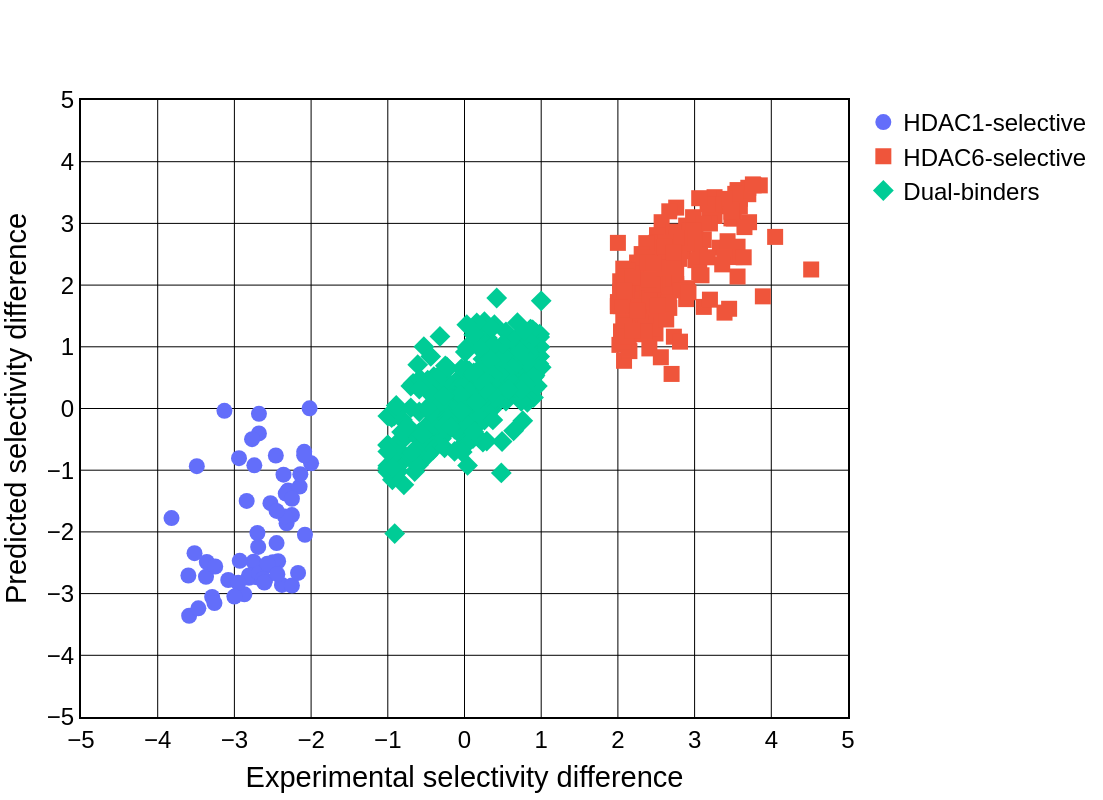

In [76]:
# plot hdac1-selective, hdac6-selective and dual selective compounds in predicted vs experimental plot
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)


#fig = px.scatter(df=HDAC1and6_ref_pred_DF_hdac1Sel, x="SelectivityWindow", y="RF", )
#fig.show() 

dfs = {"HDAC1-selective" : SW_reg_SemiSel_hdac1Sel, "HDAC6-selective": SW_reg_SemiSel_hdac6Sel, "Dual-binders" : SW_reg_SemiSel_dual}




# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i]["SelectivityWindow"],
                                   y = dfs[i]["all_ave"], 
                                   name = i,mode="markers",marker=dict(size=16, symbol = dfs[i]['Marker']) ), )

fig.update_layout(
    autosize=False,
    width=1000,
    height=800,
    xaxis_title="Experimental selectivity difference",
    yaxis_title="Predicted selectivity difference",
    template= "plotly_white",
    
    font=dict(
        #family="Courier New, monospace",
        size=24,
        color="Black"
    )
) 
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', dtick=1, showgrid=True, zeroline=True, mirror=True, zerolinecolor='black',
       zerolinewidth=1, gridwidth=1, gridcolor='black', range=[-5, 5])

#fig.add_shape( # add a horizontal "target" line
#    type="line", line_color="salmon", line_width=3, opacity=1, line_dash="dot",
#    x0=-4, x1=5, y0=2, y1=2, )

#fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)',
#})

fig.show()

In [77]:
SelWin_SemiSel_rf_DualSel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[SelWin_SemiSel_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[SelWin_SemiSel_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf0'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf0'] <= 1)].index, 'Dual_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf1'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf1'] <= 1)].index, 'Dual_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf2'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf2'] <= 1)].index, 'Dual_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf3'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf3'] <= 1)].index, 'Dual_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf4'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf4'] <= 1)].index, 'Dual_sel_y_pred_rf4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_rf_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_rf0 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf0']
SW_SemiSel_DualSel_y_pred_rf1 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf1']
SW_SemiSel_DualSel_y_pred_rf2 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf2']
SW_SemiSel_DualSel_y_pred_rf3 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf3']
SW_SemiSel_DualSel_y_pred_rf4 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf4']
list_rf = [SW_SemiSel_DualSel_y_pred_rf0, SW_SemiSel_DualSel_y_pred_rf1, SW_SemiSel_DualSel_y_pred_rf2, SW_SemiSel_DualSel_y_pred_rf3, SW_SemiSel_DualSel_y_pred_rf4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelWin_SemiSel_rf_HDAC1Sel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[SelWin_SemiSel_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[SelWin_SemiSel_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf0'] <= -2)].index, 'HDAC1_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[ (SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf1'] <= -2)].index, 'HDAC1_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[ (SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf2'] <= -2)].index, 'HDAC1_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf3'] <= -2)].index, 'HDAC1_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf4'] <= -2)].index, 'HDAC1_sel_y_pred_rf4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_rf_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_rf0 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0']
SW_SemiSel_HDAC1Sel_y_pred_rf1 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1']
SW_SemiSel_HDAC1Sel_y_pred_rf2 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2']
SW_SemiSel_HDAC1Sel_y_pred_rf3 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3']
SW_SemiSel_HDAC1Sel_y_pred_rf4 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4']
list_rf = [SW_SemiSel_HDAC1Sel_y_pred_rf0, SW_SemiSel_HDAC1Sel_y_pred_rf1, SW_SemiSel_HDAC1Sel_y_pred_rf2, SW_SemiSel_HDAC1Sel_y_pred_rf3, SW_SemiSel_HDAC1Sel_y_pred_rf4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_rf = mat_met_SW_SemiSel_rf.merge(HDAC1_SW_SemiSel_rf_ave, on='Metric')
SelWin_SemiSel_rf_HDAC6Sel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[SelWin_SemiSel_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[SelWin_SemiSel_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf0'] >= 2)].index, 'HDAC6_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[ (SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf1'] >= 2)].index, 'HDAC6_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[ (SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf2'] >= 2)].index, 'HDAC6_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf3'] >= 2)].index, 'HDAC6_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf4'] >= 2)].index, 'HDAC6_sel_y_pred_rf4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_rf_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_rf0 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0']
SW_SemiSel_HDAC6Sel_y_pred_rf1 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1']
SW_SemiSel_HDAC6Sel_y_pred_rf2 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2']
SW_SemiSel_HDAC6Sel_y_pred_rf3 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3']
SW_SemiSel_HDAC6Sel_y_pred_rf4 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4']
list_rf = [SW_SemiSel_HDAC6Sel_y_pred_rf0, SW_SemiSel_HDAC6Sel_y_pred_rf1, SW_SemiSel_HDAC6Sel_y_pred_rf2, SW_SemiSel_HDAC6Sel_y_pred_rf3, SW_SemiSel_HDAC6Sel_y_pred_rf4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_rf = mat_met_SW_SemiSel_rf.merge(HDAC6_SW_SemiSel_rf_ave, on='Metric')
mat_met_SW_SemiSel_rf

,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.400000,1.140175,31.400000,1.816590,137.200000,2.167948
1,TN,640.200000,5.761944,1846.000000,0.000000,1617.400000,2.073644
2,FP,737.800000,5.761944,3.000000,0.000000,25.600000,2.073644
3,FN,57.600000,1.140175,29.600000,1.816590,129.800000,2.167948
4,Accuracy,0.583560,0.002527,0.982932,0.000951,0.918639,0.001508
5,Precision,0.391361,0.001404,0.912592,0.004705,0.842846,0.010799
6,Sensitivity,0.891729,0.002143,0.514754,0.029780,0.513858,0.008120
7,Specificity,0.464560,0.004180,0.998400,0.000000,0.984440,0.001244
8,F1 score,0.543977,0.000988,0.657889,0.023010,0.638420,0.006534
9,F1 score (macro),0.580395,0.002051,0.824568,0.011721,0.796291,0.003617


In [78]:
SelWin_SemiSel_lgbm_DualSel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[SelWin_SemiSel_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[SelWin_SemiSel_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm0'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm0'] <= 1)].index, 'Dual_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm1'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm1'] <= 1)].index, 'Dual_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm2'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm2'] <= 1)].index, 'Dual_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm3'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm3'] <= 1)].index, 'Dual_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm4'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm4'] <= 1)].index, 'Dual_sel_y_pred_lgbm4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_lgbm_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm0']
SW_SemiSel_DualSel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm1']
SW_SemiSel_DualSel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm2']
SW_SemiSel_DualSel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm3']
SW_SemiSel_DualSel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_DualSel_y_pred_lgbm0, SW_SemiSel_DualSel_y_pred_lgbm1, SW_SemiSel_DualSel_y_pred_lgbm2, SW_SemiSel_DualSel_y_pred_lgbm3, SW_SemiSel_DualSel_y_pred_lgbm4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelWin_SemiSel_lgbm_HDAC1Sel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[SelWin_SemiSel_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[SelWin_SemiSel_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm0'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[ (SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm1'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[ (SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm2'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm3'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm4'] <= -2)].index, 'HDAC1_sel_y_pred_lgbm4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_lgbm_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0']
SW_SemiSel_HDAC1Sel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1']
SW_SemiSel_HDAC1Sel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2']
SW_SemiSel_HDAC1Sel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3']
SW_SemiSel_HDAC1Sel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_HDAC1Sel_y_pred_lgbm0, SW_SemiSel_HDAC1Sel_y_pred_lgbm1, SW_SemiSel_HDAC1Sel_y_pred_lgbm2, SW_SemiSel_HDAC1Sel_y_pred_lgbm3, SW_SemiSel_HDAC1Sel_y_pred_lgbm4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_lgbm = mat_met_SW_SemiSel_lgbm.merge(HDAC1_SW_SemiSel_lgbm_ave, on='Metric')
SelWin_SemiSel_lgbm_HDAC6Sel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[SelWin_SemiSel_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[SelWin_SemiSel_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm0'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[ (SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm1'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[ (SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm2'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm3'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm4'] >= 2)].index, 'HDAC6_sel_y_pred_lgbm4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_lgbm_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0']
SW_SemiSel_HDAC6Sel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1']
SW_SemiSel_HDAC6Sel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2']
SW_SemiSel_HDAC6Sel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3']
SW_SemiSel_HDAC6Sel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_HDAC6Sel_y_pred_lgbm0, SW_SemiSel_HDAC6Sel_y_pred_lgbm1, SW_SemiSel_HDAC6Sel_y_pred_lgbm2, SW_SemiSel_HDAC6Sel_y_pred_lgbm3, SW_SemiSel_HDAC6Sel_y_pred_lgbm4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_lgbm = mat_met_SW_SemiSel_lgbm.merge(HDAC6_SW_SemiSel_lgbm_ave, on='Metric')
mat_met_SW_SemiSel_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,454.000000,6.324555,34.800000,1.923538,153.000000,8.154753
1,TN,749.400000,6.655825,1843.600000,1.673320,1595.200000,2.387467
2,FP,628.600000,6.655825,5.400000,1.673320,47.800000,2.387467
3,FN,78.000000,6.324555,26.200000,1.923538,114.000000,8.154753
4,Accuracy,0.630052,0.003876,0.983455,0.001721,0.915288,0.004600
5,Precision,0.419356,0.003476,0.865870,0.040968,0.761707,0.013956
6,Sensitivity,0.853383,0.011888,0.570492,0.031533,0.573034,0.030542
7,Specificity,0.543820,0.004840,0.997080,0.000876,0.970920,0.001432
8,F1 score,0.562354,0.004753,0.687625,0.030005,0.653823,0.021325
9,F1 score (macro),0.620976,0.003579,0.839564,0.015394,0.802780,0.011780


In [79]:
SelWin_SemiSel_xgb_DualSel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[SelWin_SemiSel_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[SelWin_SemiSel_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb0'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb0'] <= 1)].index, 'Dual_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb1'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb1'] <= 1)].index, 'Dual_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb2'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb2'] <= 1)].index, 'Dual_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb3'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb3'] <= 1)].index, 'Dual_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb4'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb4'] <= 1)].index, 'Dual_sel_y_pred_xgb4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_xgb_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_xgb0 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb0']
SW_SemiSel_DualSel_y_pred_xgb1 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb1']
SW_SemiSel_DualSel_y_pred_xgb2 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb2']
SW_SemiSel_DualSel_y_pred_xgb3 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb3']
SW_SemiSel_DualSel_y_pred_xgb4 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_DualSel_y_pred_xgb0, SW_SemiSel_DualSel_y_pred_xgb1, SW_SemiSel_DualSel_y_pred_xgb2, SW_SemiSel_DualSel_y_pred_xgb3, SW_SemiSel_DualSel_y_pred_xgb4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelWin_SemiSel_xgb_HDAC1Sel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[SelWin_SemiSel_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[SelWin_SemiSel_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb0'] <= -2)].index, 'HDAC1_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[ (SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb1'] <= -2)].index, 'HDAC1_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[ (SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb2'] <= -2)].index, 'HDAC1_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb3'] <= -2)].index, 'HDAC1_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb4'] <= -2)].index, 'HDAC1_sel_y_pred_xgb4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_xgb_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_xgb0 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0']
SW_SemiSel_HDAC1Sel_y_pred_xgb1 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1']
SW_SemiSel_HDAC1Sel_y_pred_xgb2 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2']
SW_SemiSel_HDAC1Sel_y_pred_xgb3 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3']
SW_SemiSel_HDAC1Sel_y_pred_xgb4 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_HDAC1Sel_y_pred_xgb0, SW_SemiSel_HDAC1Sel_y_pred_xgb1, SW_SemiSel_HDAC1Sel_y_pred_xgb2, SW_SemiSel_HDAC1Sel_y_pred_xgb3, SW_SemiSel_HDAC1Sel_y_pred_xgb4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_xgb = mat_met_SW_SemiSel_xgb.merge(HDAC1_SW_SemiSel_xgb_ave, on='Metric')
SelWin_SemiSel_xgb_HDAC6Sel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[SelWin_SemiSel_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[SelWin_SemiSel_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb0'] >= 2)].index, 'HDAC6_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[ (SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb1'] >= 2)].index, 'HDAC6_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[ (SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb2'] >= 2)].index, 'HDAC6_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb3'] >= 2)].index, 'HDAC6_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb4'] >= 2)].index, 'HDAC6_sel_y_pred_xgb4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_xgb_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_xgb0 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0']
SW_SemiSel_HDAC6Sel_y_pred_xgb1 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1']
SW_SemiSel_HDAC6Sel_y_pred_xgb2 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2']
SW_SemiSel_HDAC6Sel_y_pred_xgb3 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3']
SW_SemiSel_HDAC6Sel_y_pred_xgb4 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_HDAC6Sel_y_pred_xgb0, SW_SemiSel_HDAC6Sel_y_pred_xgb1, SW_SemiSel_HDAC6Sel_y_pred_xgb2, SW_SemiSel_HDAC6Sel_y_pred_xgb3, SW_SemiSel_HDAC6Sel_y_pred_xgb4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_xgb = mat_met_SW_SemiSel_xgb.merge(HDAC6_SW_SemiSel_xgb_ave, on='Metric')
mat_met_SW_SemiSel_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,457.600000,2.073644,33.400000,2.073644,154.800000,3.563706
1,TN,733.200000,5.495453,1844.600000,1.140175,1599.400000,4.159327
2,FP,644.800000,5.495453,4.400000,1.140175,43.600000,4.159327
3,FN,74.400000,2.073644,27.600000,2.073644,112.200000,3.563706
4,Accuracy,0.623455,0.003215,0.983246,0.001335,0.918429,0.003193
5,Precision,0.415101,0.002470,0.883736,0.028745,0.780419,0.017873
6,Sensitivity,0.860150,0.003898,0.547541,0.033994,0.579775,0.013347
7,Specificity,0.532060,0.003973,0.997620,0.000602,0.973460,0.002529
8,F1 score,0.559964,0.002503,0.675736,0.027494,0.665223,0.011667
9,F1 score (macro),0.615448,0.002720,0.833568,0.014046,0.809390,0.006620


In [80]:
SelWin_SemiSel_knn_DualSel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_knn_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_knn0 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0']
SW_SemiSel_DualSel_y_pred_knn1 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1']
SW_SemiSel_DualSel_y_pred_knn2 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2']
SW_SemiSel_DualSel_y_pred_knn3 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3']
SW_SemiSel_DualSel_y_pred_knn4 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_SemiSel_DualSel_y_pred_knn0, SW_SemiSel_DualSel_y_pred_knn1, SW_SemiSel_DualSel_y_pred_knn2, SW_SemiSel_DualSel_y_pred_knn3, SW_SemiSel_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_SemiSel_knn_HDAC1Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn0'] <= -2)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn1'] <= -2)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn2'] <= -2)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn3'] <= -2)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn4'] <= -2)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_knn_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_SemiSel_HDAC1Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_SemiSel_HDAC1Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_SemiSel_HDAC1Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_SemiSel_HDAC1Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC1Sel_y_pred_knn0, SW_SemiSel_HDAC1Sel_y_pred_knn1, SW_SemiSel_HDAC1Sel_y_pred_knn2, SW_SemiSel_HDAC1Sel_y_pred_knn3, SW_SemiSel_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC1_SW_SemiSel_knn_ave, on='Metric')
SelWin_SemiSel_knn_HDAC6Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn0'] >= 2)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn1'] >= 2)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn2'] >= 2)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn3'] >= 2)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn4'] >= 2)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_knn_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_SemiSel_HDAC6Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_SemiSel_HDAC6Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_SemiSel_HDAC6Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_SemiSel_HDAC6Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC6Sel_y_pred_knn0, SW_SemiSel_HDAC6Sel_y_pred_knn1, SW_SemiSel_HDAC6Sel_y_pred_knn2, SW_SemiSel_HDAC6Sel_y_pred_knn3, SW_SemiSel_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC6_SW_SemiSel_knn_ave, on='Metric')
mat_met_SW_SemiSel_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,33.400000,2.073644,170.600000,5.856620
1,TN,777.400000,10.454664,1846.200000,0.836660,1592.000000,2.738613
2,FP,600.600000,10.454664,2.800000,0.836660,51.000000,2.738613
3,FN,84.200000,3.346640,27.600000,2.073644,96.400000,5.856620
4,Accuracy,0.641466,0.005656,0.984084,0.001365,0.922827,0.003176
5,Precision,0.427156,0.004568,0.922359,0.023605,0.769842,0.010346
6,Sensitivity,0.841729,0.006291,0.547541,0.033994,0.638951,0.021935
7,Specificity,0.564160,0.007575,0.998480,0.000455,0.968980,0.001680
8,F1 score,0.566706,0.004208,0.686843,0.028605,0.698184,0.013865
9,F1 score (macro),0.630458,0.004671,0.839339,0.014611,0.826970,0.007699


In [81]:
SelWin_SemiSel_knn_DualSel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_knn_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_knn0 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0']
SW_SemiSel_DualSel_y_pred_knn1 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1']
SW_SemiSel_DualSel_y_pred_knn2 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2']
SW_SemiSel_DualSel_y_pred_knn3 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3']
SW_SemiSel_DualSel_y_pred_knn4 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_SemiSel_DualSel_y_pred_knn0, SW_SemiSel_DualSel_y_pred_knn1, SW_SemiSel_DualSel_y_pred_knn2, SW_SemiSel_DualSel_y_pred_knn3, SW_SemiSel_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_SemiSel_knn_HDAC1Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn0'] <= -2)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn1'] <= -2)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn2'] <= -2)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn3'] <= -2)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn4'] <= -2)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_knn_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_SemiSel_HDAC1Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_SemiSel_HDAC1Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_SemiSel_HDAC1Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_SemiSel_HDAC1Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC1Sel_y_pred_knn0, SW_SemiSel_HDAC1Sel_y_pred_knn1, SW_SemiSel_HDAC1Sel_y_pred_knn2, SW_SemiSel_HDAC1Sel_y_pred_knn3, SW_SemiSel_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC1_SW_SemiSel_knn_ave, on='Metric')
SelWin_SemiSel_knn_HDAC6Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn0'] >= 2)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn1'] >= 2)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn2'] >= 2)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn3'] >= 2)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn4'] >= 2)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_knn_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_SemiSel_HDAC6Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_SemiSel_HDAC6Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_SemiSel_HDAC6Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_SemiSel_HDAC6Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC6Sel_y_pred_knn0, SW_SemiSel_HDAC6Sel_y_pred_knn1, SW_SemiSel_HDAC6Sel_y_pred_knn2, SW_SemiSel_HDAC6Sel_y_pred_knn3, SW_SemiSel_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC6_SW_SemiSel_knn_ave, on='Metric')
mat_met_SW_SemiSel_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,33.400000,2.073644,170.600000,5.856620
1,TN,777.400000,10.454664,1846.200000,0.836660,1592.000000,2.738613
2,FP,600.600000,10.454664,2.800000,0.836660,51.000000,2.738613
3,FN,84.200000,3.346640,27.600000,2.073644,96.400000,5.856620
4,Accuracy,0.641466,0.005656,0.984084,0.001365,0.922827,0.003176
5,Precision,0.427156,0.004568,0.922359,0.023605,0.769842,0.010346
6,Sensitivity,0.841729,0.006291,0.547541,0.033994,0.638951,0.021935
7,Specificity,0.564160,0.007575,0.998480,0.000455,0.968980,0.001680
8,F1 score,0.566706,0.004208,0.686843,0.028605,0.698184,0.013865
9,F1 score (macro),0.630458,0.004671,0.839339,0.014611,0.826970,0.007699


In [82]:
SelWin_SemiSel_svm_DualSel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[SelWin_SemiSel_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[SelWin_SemiSel_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm0'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm0'] <= 1)].index, 'Dual_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm1'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm1'] <= 1)].index, 'Dual_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm2'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm2'] <= 1)].index, 'Dual_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm3'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm3'] <= 1)].index, 'Dual_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm4'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm4'] <= 1)].index, 'Dual_sel_y_pred_svm4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_svm_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_svm0 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm0']
SW_SemiSel_DualSel_y_pred_svm1 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm1']
SW_SemiSel_DualSel_y_pred_svm2 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm2']
SW_SemiSel_DualSel_y_pred_svm3 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm3']
SW_SemiSel_DualSel_y_pred_svm4 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm4']
list_svm = [SW_SemiSel_DualSel_y_pred_svm0, SW_SemiSel_DualSel_y_pred_svm1, SW_SemiSel_DualSel_y_pred_svm2, SW_SemiSel_DualSel_y_pred_svm3, SW_SemiSel_DualSel_y_pred_svm4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelWin_SemiSel_svm_HDAC1Sel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[SelWin_SemiSel_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[SelWin_SemiSel_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm0'] <= -2)].index, 'HDAC1_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[ (SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm1'] <= -2)].index, 'HDAC1_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[ (SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm2'] <= -2)].index, 'HDAC1_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm3'] <= -2)].index, 'HDAC1_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm4'] <= -2)].index, 'HDAC1_sel_y_pred_svm4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_svm_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_svm0 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0']
SW_SemiSel_HDAC1Sel_y_pred_svm1 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1']
SW_SemiSel_HDAC1Sel_y_pred_svm2 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2']
SW_SemiSel_HDAC1Sel_y_pred_svm3 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3']
SW_SemiSel_HDAC1Sel_y_pred_svm4 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4']
list_svm = [SW_SemiSel_HDAC1Sel_y_pred_svm0, SW_SemiSel_HDAC1Sel_y_pred_svm1, SW_SemiSel_HDAC1Sel_y_pred_svm2, SW_SemiSel_HDAC1Sel_y_pred_svm3, SW_SemiSel_HDAC1Sel_y_pred_svm4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_svm = mat_met_SW_SemiSel_svm.merge(HDAC1_SW_SemiSel_svm_ave, on='Metric')
SelWin_SemiSel_svm_HDAC6Sel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[SelWin_SemiSel_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[SelWin_SemiSel_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm0'] >= 2)].index, 'HDAC6_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[ (SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm1'] >= 2)].index, 'HDAC6_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[ (SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm2'] >= 2)].index, 'HDAC6_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm3'] >= 2)].index, 'HDAC6_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm4'] >= 2)].index, 'HDAC6_sel_y_pred_svm4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_svm_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_svm0 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0']
SW_SemiSel_HDAC6Sel_y_pred_svm1 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1']
SW_SemiSel_HDAC6Sel_y_pred_svm2 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2']
SW_SemiSel_HDAC6Sel_y_pred_svm3 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3']
SW_SemiSel_HDAC6Sel_y_pred_svm4 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4']
list_svm = [SW_SemiSel_HDAC6Sel_y_pred_svm0, SW_SemiSel_HDAC6Sel_y_pred_svm1, SW_SemiSel_HDAC6Sel_y_pred_svm2, SW_SemiSel_HDAC6Sel_y_pred_svm3, SW_SemiSel_HDAC6Sel_y_pred_svm4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_svm = mat_met_SW_SemiSel_svm.merge(HDAC6_SW_SemiSel_svm_ave, on='Metric')
mat_met_SW_SemiSel_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,467.400000,1.673320,31.800000,1.643168,136.800000,3.271085
1,TN,713.000000,10.222524,1845.400000,0.547723,1611.800000,2.774887
2,FP,665.000000,10.222524,3.600000,0.547723,31.200000,2.774887
3,FN,64.600000,1.673320,29.200000,1.643168,130.200000,3.271085
4,Accuracy,0.618010,0.005523,0.982827,0.000777,0.915497,0.002178
5,Precision,0.412778,0.003916,0.898517,0.012435,0.814418,0.013681
6,Sensitivity,0.878571,0.003145,0.521311,0.026937,0.512360,0.012251
7,Specificity,0.517420,0.007413,0.998040,0.000329,0.981000,0.001694
8,F1 score,0.561660,0.003480,0.659425,0.019583,0.628922,0.009692
9,F1 score (macro),0.611585,0.004569,0.825308,0.009964,0.790621,0.005353


In [83]:
SelWin_SemiSel_ave_DualSel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[SelWin_SemiSel_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[SelWin_SemiSel_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_rf_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_rf_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_lgbm_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_lgbm_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_xgb_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_xgb_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_knn_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_knn_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_svm_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_svm_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_ave_DualSel['selectivity']
SW_SemiSel_DualSel_ave_rf = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_rf']
SW_SemiSel_DualSel_ave_lgbm = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_lgbm']
SW_SemiSel_DualSel_ave_xgb = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_xgb']
SW_SemiSel_DualSel_ave_knn = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_knn']
SW_SemiSel_DualSel_ave_svm = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SW_SemiSel_DualSel_ave_rf, SW_SemiSel_DualSel_ave_lgbm, SW_SemiSel_DualSel_ave_xgb, SW_SemiSel_DualSel_ave_knn, SW_SemiSel_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelWin_SemiSel_ave_HDAC1Sel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[SelWin_SemiSel_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[SelWin_SemiSel_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_rf_ave'] <= -2)].index, 'HDAC1_sel_ave_rf'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[ (SelWin_SemiSel_ave_HDAC1Sel['y_pred_lgbm_ave'] <= -2)].index, 'HDAC1_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[ (SelWin_SemiSel_ave_HDAC1Sel['y_pred_xgb_ave'] <= -2)].index, 'HDAC1_sel_ave_xgb'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_knn_ave'] <= -2)].index, 'HDAC1_sel_ave_knn'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_svm_ave'] <= -2)].index, 'HDAC1_sel_ave_svm'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_ave_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_ave_rf = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SW_SemiSel_HDAC1Sel_ave_lgbm = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SW_SemiSel_HDAC1Sel_ave_xgb = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SW_SemiSel_HDAC1Sel_ave_knn = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SW_SemiSel_HDAC1Sel_ave_svm = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SW_SemiSel_HDAC1Sel_ave_rf, SW_SemiSel_HDAC1Sel_ave_lgbm, SW_SemiSel_HDAC1Sel_ave_xgb, SW_SemiSel_HDAC1Sel_ave_knn, SW_SemiSel_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_ave = mat_met_SW_SemiSel_ave.merge(HDAC1_SW_SemiSel_ave_ave, on='Metric')

SelWin_SemiSel_ave_HDAC6Sel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[SelWin_SemiSel_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[SelWin_SemiSel_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_rf_ave'] >= 2)].index, 'HDAC6_sel_ave_rf'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[ (SelWin_SemiSel_ave_HDAC6Sel['y_pred_lgbm_ave'] >= 2)].index, 'HDAC6_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[ (SelWin_SemiSel_ave_HDAC6Sel['y_pred_xgb_ave'] >= 2)].index, 'HDAC6_sel_ave_xgb'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_knn_ave'] >= 2)].index, 'HDAC6_sel_ave_knn'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_svm_ave'] >= 2)].index, 'HDAC6_sel_ave_svm'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_ave_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_ave_rf = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SW_SemiSel_HDAC6Sel_ave_lgbm = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SW_SemiSel_HDAC6Sel_ave_xgb = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SW_SemiSel_HDAC6Sel_ave_knn = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SW_SemiSel_HDAC6Sel_ave_svm = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SW_SemiSel_HDAC6Sel_ave_rf, SW_SemiSel_HDAC6Sel_ave_lgbm, SW_SemiSel_HDAC6Sel_ave_xgb, SW_SemiSel_HDAC6Sel_ave_knn, SW_SemiSel_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_ave = mat_met_SW_SemiSel_ave.merge(HDAC6_SW_SemiSel_ave_ave, on='Metric')
mat_met_SW_SemiSel_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,477.800000,6.457554,34.400000,0.894427,164.200000,18.185159
1,TN,735.600000,41.542749,1846.800000,0.836660,1616.000000,8.031189
2,FP,642.400000,41.542749,2.200000,0.836660,27.000000,8.031189
3,FN,54.200000,6.457554,26.600000,0.894427,102.800000,18.185159
4,Accuracy,0.635288,0.018646,0.984921,0.000683,0.932042,0.005570
5,Precision,0.426947,0.012357,0.940199,0.021708,0.861397,0.025437
6,Sensitivity,0.898120,0.012138,0.563934,0.014663,0.614981,0.068109
7,Specificity,0.533820,0.030173,0.998820,0.000455,0.983560,0.004906
8,F1 score,0.578588,0.008362,0.704877,0.012630,0.714941,0.035308
9,F1 score (macro),0.628415,0.014836,0.848570,0.006467,0.838174,0.018923


In [84]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_SemiSel_EvaluationResults.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_SemiSel_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_SemiSel_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_SemiSel_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_SemiSel_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_SemiSel_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_SemiSel_ave.to_excel(writer, sheet_name="AVERAGE", )

## Evaulate Using the New Threshold for Selective Compounds

##### Calculate Evaulation Metrics for the Selectivity Window Approach with New Thresold

In [85]:
SelProf_rf_DualSel = SelProf_rf.copy()
SelProf_rf_DualSel['selectivity'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_rf_DualSel.loc[SelProf_rf_DualSel[SelProf_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_DualSel['Dual_sel_rf_test0'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test0'] >= -1)  & (SelProf_rf_DualSel['rf_test0'] <= 1)].index, 'Dual_sel_rf_test0'] =1
SelProf_rf_DualSel['Dual_sel_rf_test1'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test1'] >= -1)  & (SelProf_rf_DualSel['rf_test1'] <= 1)].index, 'Dual_sel_rf_test1'] =1
SelProf_rf_DualSel['Dual_sel_rf_test2'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test2'] >= -1)  & (SelProf_rf_DualSel['rf_test2'] <= 1)].index, 'Dual_sel_rf_test2'] =1
SelProf_rf_DualSel['Dual_sel_rf_test3'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test3'] >= -1)  & (SelProf_rf_DualSel['rf_test3'] <= 1)].index, 'Dual_sel_rf_test3'] =1
SelProf_rf_DualSel['Dual_sel_rf_test4'] = np.zeros(len(SelProf_rf_DualSel))
SelProf_rf_DualSel.loc[SelProf_rf_DualSel[(SelProf_rf_DualSel['rf_test4'] >= -1)  & (SelProf_rf_DualSel['rf_test4'] <= 1)].index, 'Dual_sel_rf_test4'] =1


SP_DualSel = SelProf_rf_DualSel['selectivity']
SP_DualSel_rf_test0 = SelProf_rf_DualSel['Dual_sel_rf_test0']
SP_DualSel_rf_test1 = SelProf_rf_DualSel['Dual_sel_rf_test1']
SP_DualSel_rf_test2 = SelProf_rf_DualSel['Dual_sel_rf_test2']
SP_DualSel_rf_test3 = SelProf_rf_DualSel['Dual_sel_rf_test3']
SP_DualSel_rf_test4 = SelProf_rf_DualSel['Dual_sel_rf_test4']
list_rf = [SP_DualSel_rf_test0, SP_DualSel_rf_test1, SP_DualSel_rf_test2, SP_DualSel_rf_test3, SP_DualSel_rf_test4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SP_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelProf_rf_HDAC1Sel = SelProf_rf.copy()
SelProf_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[SelProf_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test0'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test0'] <= -1.00)].index, 'HDAC1_sel_rf_test0'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test1'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[ (SelProf_rf_HDAC1Sel['rf_test1'] <= -1.00)].index, 'HDAC1_sel_rf_test1'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test2'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[ (SelProf_rf_HDAC1Sel['rf_test2'] <= -1.00)].index, 'HDAC1_sel_rf_test2'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test3'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test3'] <= -1.00)].index, 'HDAC1_sel_rf_test3'] =1
SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test4'] = np.zeros(len(SelProf_rf_HDAC1Sel))
SelProf_rf_HDAC1Sel.loc[SelProf_rf_HDAC1Sel[(SelProf_rf_HDAC1Sel['rf_test4'] <= -1.00)].index, 'HDAC1_sel_rf_test4'] =1


SP_HDAC1Sel = SelProf_rf_HDAC1Sel['selectivity']
SP_HDAC1Sel_rf_test0 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test0']
SP_HDAC1Sel_rf_test1 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test1']
SP_HDAC1Sel_rf_test2 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test2']
SP_HDAC1Sel_rf_test3 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test3']
SP_HDAC1Sel_rf_test4 = SelProf_rf_HDAC1Sel['HDAC1_sel_rf_test4']
list_rf = [SP_HDAC1Sel_rf_test0, SP_HDAC1Sel_rf_test1, SP_HDAC1Sel_rf_test2, SP_HDAC1Sel_rf_test3, SP_HDAC1Sel_rf_test4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SP_rf = mat_met_SP_rf.merge(HDAC1_SP_rf_ave, on='Metric')
SelProf_rf_HDAC6Sel = SelProf_rf.copy()
SelProf_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[SelProf_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test0'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test0'] >= 1.5)].index, 'HDAC6_sel_rf_test0'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test1'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[ (SelProf_rf_HDAC6Sel['rf_test1'] >= 1.5)].index, 'HDAC6_sel_rf_test1'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test2'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[ (SelProf_rf_HDAC6Sel['rf_test2'] >= 1.5)].index, 'HDAC6_sel_rf_test2'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test3'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test3'] >= 1.5)].index, 'HDAC6_sel_rf_test3'] =1
SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test4'] = np.zeros(len(SelProf_rf_HDAC6Sel))
SelProf_rf_HDAC6Sel.loc[SelProf_rf_HDAC6Sel[(SelProf_rf_HDAC6Sel['rf_test4'] >= 1.5)].index, 'HDAC6_sel_rf_test4'] =1


SP_HDAC6Sel = SelProf_rf_HDAC6Sel['selectivity']
SP_HDAC6Sel_rf_test0 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test0']
SP_HDAC6Sel_rf_test1 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test1']
SP_HDAC6Sel_rf_test2 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test2']
SP_HDAC6Sel_rf_test3 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test3']
SP_HDAC6Sel_rf_test4 = SelProf_rf_HDAC6Sel['HDAC6_sel_rf_test4']
list_rf = [SP_HDAC6Sel_rf_test0, SP_HDAC6Sel_rf_test1, SP_HDAC6Sel_rf_test2, SP_HDAC6Sel_rf_test3, SP_HDAC6Sel_rf_test4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SP_rf = mat_met_SP_rf.merge(HDAC6_SP_rf_ave, on='Metric')
mat_met_SP_rf

,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,473.400000,3.577709,42.000000,0.000000e+00,200.600000,1.516575
1,TN,662.800000,3.768289,1792.600000,2.302173e+00,1493.600000,4.615192
2,FP,715.200000,3.768289,56.400000,2.302173e+00,149.400000,4.615192
3,FN,58.600000,3.577709,19.000000,0.000000e+00,66.400000,1.516575
4,Accuracy,0.594869,0.001588,0.960524,1.205326e-03,0.887016,0.001902
5,Precision,0.398282,0.001360,0.427014,9.852833e-03,0.573222,0.006373
6,Sensitivity,0.889850,0.006725,0.688525,0.000000e+00,0.751311,0.005680
7,Specificity,0.480960,0.002737,0.969520,1.231666e-03,0.909080,0.002809
8,F1 score,0.550268,0.002143,0.527063,6.749554e-03,0.650258,0.002921
9,F1 score (macro),0.590842,0.001440,0.753233,3.661918e-03,0.791441,0.001967


In [86]:
SelProf_lgbm_DualSel = SelProf_lgbm.copy()
SelProf_lgbm_DualSel['selectivity'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[SelProf_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test0'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test0'] <= 1)].index, 'Dual_sel_lgbm_test0'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test1'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test1'] <= 1)].index, 'Dual_sel_lgbm_test1'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test2'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test2'] <= 1)].index, 'Dual_sel_lgbm_test2'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test3'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test3'] <= 1)].index, 'Dual_sel_lgbm_test3'] =1
SelProf_lgbm_DualSel['Dual_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_DualSel))
SelProf_lgbm_DualSel.loc[SelProf_lgbm_DualSel[(SelProf_lgbm_DualSel['lgbm_test4'] >= -1)  & (SelProf_lgbm_DualSel['lgbm_test4'] <= 1)].index, 'Dual_sel_lgbm_test4'] =1


SP_DualSel = SelProf_lgbm_DualSel['selectivity']
SP_DualSel_lgbm_test0 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test0']
SP_DualSel_lgbm_test1 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test1']
SP_DualSel_lgbm_test2 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test2']
SP_DualSel_lgbm_test3 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test3']
SP_DualSel_lgbm_test4 = SelProf_lgbm_DualSel['Dual_sel_lgbm_test4']
list_lgbm = [SP_DualSel_lgbm_test0, SP_DualSel_lgbm_test1, SP_DualSel_lgbm_test2, SP_DualSel_lgbm_test3, SP_DualSel_lgbm_test4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SP_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelProf_lgbm_HDAC1Sel = SelProf_lgbm.copy()
SelProf_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[SelProf_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test0'] <= -1.00)].index, 'HDAC1_sel_lgbm_test0'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[ (SelProf_lgbm_HDAC1Sel['lgbm_test1'] <= -1.00)].index, 'HDAC1_sel_lgbm_test1'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[ (SelProf_lgbm_HDAC1Sel['lgbm_test2'] <= -1.00)].index, 'HDAC1_sel_lgbm_test2'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test3'] <= -1.00)].index, 'HDAC1_sel_lgbm_test3'] =1
SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_HDAC1Sel))
SelProf_lgbm_HDAC1Sel.loc[SelProf_lgbm_HDAC1Sel[(SelProf_lgbm_HDAC1Sel['lgbm_test4'] <= -1.00)].index, 'HDAC1_sel_lgbm_test4'] =1


SP_HDAC1Sel = SelProf_lgbm_HDAC1Sel['selectivity']
SP_HDAC1Sel_lgbm_test0 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test0']
SP_HDAC1Sel_lgbm_test1 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test1']
SP_HDAC1Sel_lgbm_test2 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test2']
SP_HDAC1Sel_lgbm_test3 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test3']
SP_HDAC1Sel_lgbm_test4 = SelProf_lgbm_HDAC1Sel['HDAC1_sel_lgbm_test4']
list_lgbm = [SP_HDAC1Sel_lgbm_test0, SP_HDAC1Sel_lgbm_test1, SP_HDAC1Sel_lgbm_test2, SP_HDAC1Sel_lgbm_test3, SP_HDAC1Sel_lgbm_test4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC1_SP_lgbm_ave, on='Metric')
SelProf_lgbm_HDAC6Sel = SelProf_lgbm.copy()
SelProf_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[SelProf_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test0'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test0'] >= 1.5)].index, 'HDAC6_sel_lgbm_test0'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test1'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[ (SelProf_lgbm_HDAC6Sel['lgbm_test1'] >= 1.5)].index, 'HDAC6_sel_lgbm_test1'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test2'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[ (SelProf_lgbm_HDAC6Sel['lgbm_test2'] >= 1.5)].index, 'HDAC6_sel_lgbm_test2'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test3'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test3'] >= 1.5)].index, 'HDAC6_sel_lgbm_test3'] =1
SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test4'] = np.zeros(len(SelProf_lgbm_HDAC6Sel))
SelProf_lgbm_HDAC6Sel.loc[SelProf_lgbm_HDAC6Sel[(SelProf_lgbm_HDAC6Sel['lgbm_test4'] >= 1.5)].index, 'HDAC6_sel_lgbm_test4'] =1


SP_HDAC6Sel = SelProf_lgbm_HDAC6Sel['selectivity']
SP_HDAC6Sel_lgbm_test0 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test0']
SP_HDAC6Sel_lgbm_test1 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test1']
SP_HDAC6Sel_lgbm_test2 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test2']
SP_HDAC6Sel_lgbm_test3 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test3']
SP_HDAC6Sel_lgbm_test4 = SelProf_lgbm_HDAC6Sel['HDAC6_sel_lgbm_test4']
list_lgbm = [SP_HDAC6Sel_lgbm_test0, SP_HDAC6Sel_lgbm_test1, SP_HDAC6Sel_lgbm_test2, SP_HDAC6Sel_lgbm_test3, SP_HDAC6Sel_lgbm_test4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SP_lgbm = mat_met_SP_lgbm.merge(HDAC6_SP_lgbm_ave, on='Metric')
mat_met_SP_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,444.600000,5.029911,47.800000,1.923538,219.000000,1.000000
1,TN,730.000000,4.949747,1759.600000,3.361547,1447.000000,6.633250
2,FP,648.000000,4.949747,89.400000,3.361547,196.000000,6.633250
3,FN,87.400000,5.029911,13.200000,1.923538,48.000000,1.000000
4,Accuracy,0.614974,0.004149,0.946283,0.001639,0.872251,0.003551
5,Precision,0.406917,0.003673,0.348431,0.009811,0.527817,0.008669
6,Sensitivity,0.835714,0.009455,0.783607,0.031533,0.820225,0.003745
7,Specificity,0.529760,0.003576,0.951660,0.001831,0.880700,0.004048
8,F1 score,0.547329,0.004643,0.482284,0.012294,0.642276,0.006034
9,F1 score (macro),0.606177,0.003817,0.726977,0.006418,0.782258,0.004040


In [87]:
SelProf_xgb_DualSel = SelProf_xgb.copy()
SelProf_xgb_DualSel['selectivity'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[SelProf_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test0'] >= -1)  & (SelProf_xgb_DualSel['xgb_test0'] <= 1)].index, 'Dual_sel_xgb_test0'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test1'] >= -1)  & (SelProf_xgb_DualSel['xgb_test1'] <= 1)].index, 'Dual_sel_xgb_test1'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test2'] >= -1)  & (SelProf_xgb_DualSel['xgb_test2'] <= 1)].index, 'Dual_sel_xgb_test2'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test3'] >= -1)  & (SelProf_xgb_DualSel['xgb_test3'] <= 1)].index, 'Dual_sel_xgb_test3'] =1
SelProf_xgb_DualSel['Dual_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_DualSel))
SelProf_xgb_DualSel.loc[SelProf_xgb_DualSel[(SelProf_xgb_DualSel['xgb_test4'] >= -1)  & (SelProf_xgb_DualSel['xgb_test4'] <= 1)].index, 'Dual_sel_xgb_test4'] =1


SP_DualSel = SelProf_xgb_DualSel['selectivity']
SP_DualSel_xgb_test0 = SelProf_xgb_DualSel['Dual_sel_xgb_test0']
SP_DualSel_xgb_test1 = SelProf_xgb_DualSel['Dual_sel_xgb_test1']
SP_DualSel_xgb_test2 = SelProf_xgb_DualSel['Dual_sel_xgb_test2']
SP_DualSel_xgb_test3 = SelProf_xgb_DualSel['Dual_sel_xgb_test3']
SP_DualSel_xgb_test4 = SelProf_xgb_DualSel['Dual_sel_xgb_test4']
list_xgb = [SP_DualSel_xgb_test0, SP_DualSel_xgb_test1, SP_DualSel_xgb_test2, SP_DualSel_xgb_test3, SP_DualSel_xgb_test4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SP_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelProf_xgb_HDAC1Sel = SelProf_xgb.copy()
SelProf_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[SelProf_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test0'] <= -1.00)].index, 'HDAC1_sel_xgb_test0'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[ (SelProf_xgb_HDAC1Sel['xgb_test1'] <= -1.00)].index, 'HDAC1_sel_xgb_test1'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[ (SelProf_xgb_HDAC1Sel['xgb_test2'] <= -1.00)].index, 'HDAC1_sel_xgb_test2'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test3'] <= -1.00)].index, 'HDAC1_sel_xgb_test3'] =1
SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_HDAC1Sel))
SelProf_xgb_HDAC1Sel.loc[SelProf_xgb_HDAC1Sel[(SelProf_xgb_HDAC1Sel['xgb_test4'] <= -1.00)].index, 'HDAC1_sel_xgb_test4'] =1


SP_HDAC1Sel = SelProf_xgb_HDAC1Sel['selectivity']
SP_HDAC1Sel_xgb_test0 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test0']
SP_HDAC1Sel_xgb_test1 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test1']
SP_HDAC1Sel_xgb_test2 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test2']
SP_HDAC1Sel_xgb_test3 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test3']
SP_HDAC1Sel_xgb_test4 = SelProf_xgb_HDAC1Sel['HDAC1_sel_xgb_test4']
list_xgb = [SP_HDAC1Sel_xgb_test0, SP_HDAC1Sel_xgb_test1, SP_HDAC1Sel_xgb_test2, SP_HDAC1Sel_xgb_test3, SP_HDAC1Sel_xgb_test4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC1_SP_xgb_ave, on='Metric')
SelProf_xgb_HDAC6Sel = SelProf_xgb.copy()
SelProf_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[SelProf_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test0'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test0'] >= 1.5)].index, 'HDAC6_sel_xgb_test0'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test1'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[ (SelProf_xgb_HDAC6Sel['xgb_test1'] >= 1.5)].index, 'HDAC6_sel_xgb_test1'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test2'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[ (SelProf_xgb_HDAC6Sel['xgb_test2'] >= 1.5)].index, 'HDAC6_sel_xgb_test2'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test3'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test3'] >= 1.5)].index, 'HDAC6_sel_xgb_test3'] =1
SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test4'] = np.zeros(len(SelProf_xgb_HDAC6Sel))
SelProf_xgb_HDAC6Sel.loc[SelProf_xgb_HDAC6Sel[(SelProf_xgb_HDAC6Sel['xgb_test4'] >= 1.5)].index, 'HDAC6_sel_xgb_test4'] =1


SP_HDAC6Sel = SelProf_xgb_HDAC6Sel['selectivity']
SP_HDAC6Sel_xgb_test0 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test0']
SP_HDAC6Sel_xgb_test1 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test1']
SP_HDAC6Sel_xgb_test2 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test2']
SP_HDAC6Sel_xgb_test3 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test3']
SP_HDAC6Sel_xgb_test4 = SelProf_xgb_HDAC6Sel['HDAC6_sel_xgb_test4']
list_xgb = [SP_HDAC6Sel_xgb_test0, SP_HDAC6Sel_xgb_test1, SP_HDAC6Sel_xgb_test2, SP_HDAC6Sel_xgb_test3, SP_HDAC6Sel_xgb_test4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SP_xgb = mat_met_SP_xgb.merge(HDAC6_SP_xgb_ave, on='Metric')
mat_met_SP_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,455.000000,4.301163,49.200000,0.447214,208.400000,2.073644
1,TN,729.400000,4.615192,1760.000000,2.645751,1474.000000,4.062019
2,FP,648.600000,4.615192,89.000000,2.645751,169.000000,4.062019
3,FN,77.000000,4.301163,11.800000,0.447214,58.600000,2.073644
4,Accuracy,0.620105,0.001721,0.947225,0.001250,0.880838,0.002330
5,Precision,0.412284,0.001561,0.356097,0.005823,0.552240,0.006311
6,Sensitivity,0.855263,0.008085,0.806557,0.007331,0.780524,0.007766
7,Specificity,0.529320,0.003362,0.951840,0.001436,0.897140,0.002487
8,F1 score,0.556362,0.002548,0.494025,0.004651,0.646812,0.005180
9,F1 score (macro),0.612092,0.001585,0.733093,0.002609,0.787570,0.003199


In [88]:
SelProf_knn_DualSel = SelProf_knn.copy()
SelProf_knn_DualSel['selectivity'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_knn_DualSel.loc[SelProf_knn_DualSel[SelProf_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_DualSel['Dual_sel_knn_test0'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test0'] >= -1)  & (SelProf_knn_DualSel['knn_test0'] <= 1)].index, 'Dual_sel_knn_test0'] =1
SelProf_knn_DualSel['Dual_sel_knn_test1'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test1'] >= -1)  & (SelProf_knn_DualSel['knn_test1'] <= 1)].index, 'Dual_sel_knn_test1'] =1
SelProf_knn_DualSel['Dual_sel_knn_test2'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test2'] >= -1)  & (SelProf_knn_DualSel['knn_test2'] <= 1)].index, 'Dual_sel_knn_test2'] =1
SelProf_knn_DualSel['Dual_sel_knn_test3'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test3'] >= -1)  & (SelProf_knn_DualSel['knn_test3'] <= 1)].index, 'Dual_sel_knn_test3'] =1
SelProf_knn_DualSel['Dual_sel_knn_test4'] = np.zeros(len(SelProf_knn_DualSel))
SelProf_knn_DualSel.loc[SelProf_knn_DualSel[(SelProf_knn_DualSel['knn_test4'] >= -1)  & (SelProf_knn_DualSel['knn_test4'] <= 1)].index, 'Dual_sel_knn_test4'] =1


SP_DualSel = SelProf_knn_DualSel['selectivity']
SP_DualSel_knn_test0 = SelProf_knn_DualSel['Dual_sel_knn_test0']
SP_DualSel_knn_test1 = SelProf_knn_DualSel['Dual_sel_knn_test1']
SP_DualSel_knn_test2 = SelProf_knn_DualSel['Dual_sel_knn_test2']
SP_DualSel_knn_test3 = SelProf_knn_DualSel['Dual_sel_knn_test3']
SP_DualSel_knn_test4 = SelProf_knn_DualSel['Dual_sel_knn_test4']
list_knn = [SP_DualSel_knn_test0, SP_DualSel_knn_test1, SP_DualSel_knn_test2, SP_DualSel_knn_test3, SP_DualSel_knn_test4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SP_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelProf_knn_HDAC1Sel = SelProf_knn.copy()
SelProf_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[SelProf_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test0'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test0'] <= -1.00)].index, 'HDAC1_sel_knn_test0'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test1'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[ (SelProf_knn_HDAC1Sel['knn_test1'] <= -1.00)].index, 'HDAC1_sel_knn_test1'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test2'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[ (SelProf_knn_HDAC1Sel['knn_test2'] <= -1.00)].index, 'HDAC1_sel_knn_test2'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test3'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test3'] <= -1.00)].index, 'HDAC1_sel_knn_test3'] =1
SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test4'] = np.zeros(len(SelProf_knn_HDAC1Sel))
SelProf_knn_HDAC1Sel.loc[SelProf_knn_HDAC1Sel[(SelProf_knn_HDAC1Sel['knn_test4'] <= -1.00)].index, 'HDAC1_sel_knn_test4'] =1


SP_HDAC1Sel = SelProf_knn_HDAC1Sel['selectivity']
SP_HDAC1Sel_knn_test0 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test0']
SP_HDAC1Sel_knn_test1 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test1']
SP_HDAC1Sel_knn_test2 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test2']
SP_HDAC1Sel_knn_test3 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test3']
SP_HDAC1Sel_knn_test4 = SelProf_knn_HDAC1Sel['HDAC1_sel_knn_test4']
list_knn = [SP_HDAC1Sel_knn_test0, SP_HDAC1Sel_knn_test1, SP_HDAC1Sel_knn_test2, SP_HDAC1Sel_knn_test3, SP_HDAC1Sel_knn_test4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SP_knn = mat_met_SP_knn.merge(HDAC1_SP_knn_ave, on='Metric')
SelProf_knn_HDAC6Sel = SelProf_knn.copy()
SelProf_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[SelProf_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test0'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test0'] >= 1.5)].index, 'HDAC6_sel_knn_test0'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test1'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[ (SelProf_knn_HDAC6Sel['knn_test1'] >= 1.5)].index, 'HDAC6_sel_knn_test1'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test2'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[ (SelProf_knn_HDAC6Sel['knn_test2'] >= 1.5)].index, 'HDAC6_sel_knn_test2'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test3'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test3'] >= 1.5)].index, 'HDAC6_sel_knn_test3'] =1
SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test4'] = np.zeros(len(SelProf_knn_HDAC6Sel))
SelProf_knn_HDAC6Sel.loc[SelProf_knn_HDAC6Sel[(SelProf_knn_HDAC6Sel['knn_test4'] >= 1.5)].index, 'HDAC6_sel_knn_test4'] =1


SP_HDAC6Sel = SelProf_knn_HDAC6Sel['selectivity']
SP_HDAC6Sel_knn_test0 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test0']
SP_HDAC6Sel_knn_test1 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test1']
SP_HDAC6Sel_knn_test2 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test2']
SP_HDAC6Sel_knn_test3 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test3']
SP_HDAC6Sel_knn_test4 = SelProf_knn_HDAC6Sel['HDAC6_sel_knn_test4']
list_knn = [SP_HDAC6Sel_knn_test0, SP_HDAC6Sel_knn_test1, SP_HDAC6Sel_knn_test2, SP_HDAC6Sel_knn_test3, SP_HDAC6Sel_knn_test4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SP_knn = mat_met_SP_knn.merge(HDAC6_SP_knn_ave, on='Metric')
mat_met_SP_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.000000,3.391165,47.600000,0.547723,232.400000,2.880972
1,TN,778.600000,6.985700,1751.600000,4.722288,1436.800000,3.898718
2,FP,599.400000,6.985700,97.400000,4.722288,206.200000,3.898718
3,FN,85.000000,3.391165,13.400000,0.547723,34.600000,2.880972
4,Accuracy,0.641675,0.003324,0.941990,0.002411,0.873927,0.003278
5,Precision,0.427188,0.002662,0.328539,0.010443,0.529883,0.007244
6,Sensitivity,0.840226,0.006374,0.780328,0.008979,0.870412,0.010790
7,Specificity,0.565020,0.005076,0.947340,0.002556,0.874500,0.002379
8,F1 score,0.566397,0.002709,0.462308,0.009318,0.658737,0.007565
9,F1 score (macro),0.630535,0.002730,0.715824,0.005223,0.790709,0.004682


In [89]:
SelProf_svm_DualSel = SelProf_svm.copy()
SelProf_svm_DualSel['selectivity'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_svm_DualSel.loc[SelProf_svm_DualSel[SelProf_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_DualSel['Dual_sel_svm_test0'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test0'] >= -1)  & (SelProf_svm_DualSel['svm_test0'] <= 1)].index, 'Dual_sel_svm_test0'] =1
SelProf_svm_DualSel['Dual_sel_svm_test1'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test1'] >= -1)  & (SelProf_svm_DualSel['svm_test1'] <= 1)].index, 'Dual_sel_svm_test1'] =1
SelProf_svm_DualSel['Dual_sel_svm_test2'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test2'] >= -1)  & (SelProf_svm_DualSel['svm_test2'] <= 1)].index, 'Dual_sel_svm_test2'] =1
SelProf_svm_DualSel['Dual_sel_svm_test3'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test3'] >= -1)  & (SelProf_svm_DualSel['svm_test3'] <= 1)].index, 'Dual_sel_svm_test3'] =1
SelProf_svm_DualSel['Dual_sel_svm_test4'] = np.zeros(len(SelProf_svm_DualSel))
SelProf_svm_DualSel.loc[SelProf_svm_DualSel[(SelProf_svm_DualSel['svm_test4'] >= -1)  & (SelProf_svm_DualSel['svm_test4'] <= 1)].index, 'Dual_sel_svm_test4'] =1


SP_DualSel = SelProf_svm_DualSel['selectivity']
SP_DualSel_svm_test0 = SelProf_svm_DualSel['Dual_sel_svm_test0']
SP_DualSel_svm_test1 = SelProf_svm_DualSel['Dual_sel_svm_test1']
SP_DualSel_svm_test2 = SelProf_svm_DualSel['Dual_sel_svm_test2']
SP_DualSel_svm_test3 = SelProf_svm_DualSel['Dual_sel_svm_test3']
SP_DualSel_svm_test4 = SelProf_svm_DualSel['Dual_sel_svm_test4']
list_svm = [SP_DualSel_svm_test0, SP_DualSel_svm_test1, SP_DualSel_svm_test2, SP_DualSel_svm_test3, SP_DualSel_svm_test4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SP_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelProf_svm_HDAC1Sel = SelProf_svm.copy()
SelProf_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[SelProf_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test0'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test0'] <= -1.00)].index, 'HDAC1_sel_svm_test0'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test1'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[ (SelProf_svm_HDAC1Sel['svm_test1'] <= -1.00)].index, 'HDAC1_sel_svm_test1'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test2'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[ (SelProf_svm_HDAC1Sel['svm_test2'] <= -1.00)].index, 'HDAC1_sel_svm_test2'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test3'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test3'] <= -1.00)].index, 'HDAC1_sel_svm_test3'] =1
SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test4'] = np.zeros(len(SelProf_svm_HDAC1Sel))
SelProf_svm_HDAC1Sel.loc[SelProf_svm_HDAC1Sel[(SelProf_svm_HDAC1Sel['svm_test4'] <= -1.00)].index, 'HDAC1_sel_svm_test4'] =1


SP_HDAC1Sel = SelProf_svm_HDAC1Sel['selectivity']
SP_HDAC1Sel_svm_test0 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test0']
SP_HDAC1Sel_svm_test1 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test1']
SP_HDAC1Sel_svm_test2 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test2']
SP_HDAC1Sel_svm_test3 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test3']
SP_HDAC1Sel_svm_test4 = SelProf_svm_HDAC1Sel['HDAC1_sel_svm_test4']
list_svm = [SP_HDAC1Sel_svm_test0, SP_HDAC1Sel_svm_test1, SP_HDAC1Sel_svm_test2, SP_HDAC1Sel_svm_test3, SP_HDAC1Sel_svm_test4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SP_svm = mat_met_SP_svm.merge(HDAC1_SP_svm_ave, on='Metric')
SelProf_svm_HDAC6Sel = SelProf_svm.copy()
SelProf_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[SelProf_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test0'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test0'] >= 1.5)].index, 'HDAC6_sel_svm_test0'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test1'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[ (SelProf_svm_HDAC6Sel['svm_test1'] >= 1.5)].index, 'HDAC6_sel_svm_test1'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test2'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[ (SelProf_svm_HDAC6Sel['svm_test2'] >= 1.5)].index, 'HDAC6_sel_svm_test2'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test3'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test3'] >= 1.5)].index, 'HDAC6_sel_svm_test3'] =1
SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test4'] = np.zeros(len(SelProf_svm_HDAC6Sel))
SelProf_svm_HDAC6Sel.loc[SelProf_svm_HDAC6Sel[(SelProf_svm_HDAC6Sel['svm_test4'] >= 1.5)].index, 'HDAC6_sel_svm_test4'] =1


SP_HDAC6Sel = SelProf_svm_HDAC6Sel['selectivity']
SP_HDAC6Sel_svm_test0 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test0']
SP_HDAC6Sel_svm_test1 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test1']
SP_HDAC6Sel_svm_test2 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test2']
SP_HDAC6Sel_svm_test3 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test3']
SP_HDAC6Sel_svm_test4 = SelProf_svm_HDAC6Sel['HDAC6_sel_svm_test4']
list_svm = [SP_HDAC6Sel_svm_test0, SP_HDAC6Sel_svm_test1, SP_HDAC6Sel_svm_test2, SP_HDAC6Sel_svm_test3, SP_HDAC6Sel_svm_test4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SP_svm = mat_met_SP_svm.merge(HDAC6_SP_svm_ave, on='Metric')
mat_met_SP_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,464.000000,2.449490,44.200000,1.303840,211.600000,1.949359
1,TN,712.800000,7.726578,1783.000000,6.041523,1481.400000,3.911521
2,FP,665.200000,7.726578,66.000000,6.041523,161.600000,3.911521
3,FN,68.000000,2.449490,16.800000,1.303840,55.400000,1.949359
4,Accuracy,0.616126,0.004079,0.956649,0.003039,0.886387,0.002915
5,Precision,0.410923,0.002918,0.401973,0.021402,0.567024,0.007846
6,Sensitivity,0.872180,0.004604,0.724590,0.021374,0.792509,0.007301
7,Specificity,0.517280,0.005600,0.964300,0.003273,0.901640,0.002347
8,F1 score,0.558639,0.002798,0.516746,0.016620,0.661061,0.006859
9,F1 score (macro),0.609496,0.003389,0.747026,0.008982,0.796408,0.004226


In [90]:
SelProf_ave_DualSel = selectivity_profile_reg.copy()
SelProf_ave_DualSel['selectivity'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelProf_ave_DualSel.loc[SelProf_ave_DualSel[SelProf_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['rf_test_ave'] >= -1)  & (SelProf_ave_DualSel['rf_test_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelProf_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['lgbm_test_ave'] >= -1)  & (SelProf_ave_DualSel['lgbm_test_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelProf_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['xgb_test_ave'] >= -1)  & (SelProf_ave_DualSel['xgb_test_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelProf_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['knn_test_ave'] >= -1)  & (SelProf_ave_DualSel['knn_test_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelProf_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelProf_ave_DualSel))
SelProf_ave_DualSel.loc[SelProf_ave_DualSel[(SelProf_ave_DualSel['svm_test_ave'] >= -1)  & (SelProf_ave_DualSel['svm_test_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SP_DualSel = SelProf_ave_DualSel['selectivity']
SP_DualSel_ave_rf = SelProf_ave_DualSel['Dual_sel_ave_rf']
SP_DualSel_ave_lgbm = SelProf_ave_DualSel['Dual_sel_ave_lgbm']
SP_DualSel_ave_xgb = SelProf_ave_DualSel['Dual_sel_ave_xgb']
SP_DualSel_ave_knn = SelProf_ave_DualSel['Dual_sel_ave_knn']
SP_DualSel_ave_svm = SelProf_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SP_DualSel_ave_rf, SP_DualSel_ave_lgbm, SP_DualSel_ave_xgb, SP_DualSel_ave_knn, SP_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SP_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SP_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SP_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SP_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SP_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SP_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SP_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SP_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SP_DualSel, df)

mat_met_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelProf_ave_HDAC1Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[SelProf_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['rf_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_rf'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[ (SelProf_ave_HDAC1Sel['lgbm_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_lgbm'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[ (SelProf_ave_HDAC1Sel['xgb_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_xgb'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['knn_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_knn'] =1
SelProf_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelProf_ave_HDAC1Sel))
SelProf_ave_HDAC1Sel.loc[SelProf_ave_HDAC1Sel[(SelProf_ave_HDAC1Sel['svm_test_ave'] <= -1.00)].index, 'HDAC1_sel_ave_svm'] =1


SP_HDAC1Sel = SelProf_ave_HDAC1Sel['selectivity']
SP_HDAC1Sel_ave_rf = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SP_HDAC1Sel_ave_lgbm = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SP_HDAC1Sel_ave_xgb = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SP_HDAC1Sel_ave_knn = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SP_HDAC1Sel_ave_svm = SelProf_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SP_HDAC1Sel_ave_rf, SP_HDAC1Sel_ave_lgbm, SP_HDAC1Sel_ave_xgb, SP_HDAC1Sel_ave_knn, SP_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SP_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SP_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SP_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SP_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SP_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SP_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SP_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SP_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SP_HDAC1Sel, df)

HDAC1_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SP_ave = mat_met_SP_ave.merge(HDAC1_SP_ave, on='Metric')

SelProf_ave_HDAC6Sel = selectivity_profile_reg.copy()
SelProf_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[SelProf_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['rf_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_rf'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[ (SelProf_ave_HDAC6Sel['lgbm_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_lgbm'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[ (SelProf_ave_HDAC6Sel['xgb_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_xgb'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['knn_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_knn'] =1
SelProf_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelProf_ave_HDAC6Sel))
SelProf_ave_HDAC6Sel.loc[SelProf_ave_HDAC6Sel[(SelProf_ave_HDAC6Sel['svm_test_ave'] >= 1.5)].index, 'HDAC6_sel_ave_svm'] =1


SP_HDAC6Sel = SelProf_ave_HDAC6Sel['selectivity']
SP_HDAC6Sel_ave_rf = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SP_HDAC6Sel_ave_lgbm = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SP_HDAC6Sel_ave_xgb = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SP_HDAC6Sel_ave_knn = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SP_HDAC6Sel_ave_svm = SelProf_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SP_HDAC6Sel_ave_rf, SP_HDAC6Sel_ave_lgbm, SP_HDAC6Sel_ave_xgb, SP_HDAC6Sel_ave_knn, SP_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SP_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SP_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SP_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SP_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SP_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SP_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SP_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SP_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SP_HDAC6Sel, df)

HDAC6_SP_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SP_ave = mat_met_SP_ave.merge(HDAC6_SP_ave, on='Metric')
mat_met_SP_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,479.200000,9.959920,50.400000,1.816590,232.600000,9.262829
1,TN,734.800000,31.051570,1772.400000,14.099645,1488.000000,20.223748
2,FP,643.200000,31.051570,76.600000,14.099645,155.000000,20.223748
3,FN,52.800000,9.959920,10.600000,1.816590,34.400000,9.262829
4,Accuracy,0.635602,0.012685,0.954346,0.006699,0.900838,0.006812
5,Precision,0.427144,0.008543,0.400810,0.041272,0.601369,0.022949
6,Sensitivity,0.900752,0.018722,0.826230,0.029780,0.871161,0.034692
7,Specificity,0.533260,0.022545,0.958580,0.007604,0.905660,0.012327
8,F1 score,0.579367,0.006247,0.538177,0.028859,0.710819,0.009748
9,F1 score (macro),0.628872,0.009932,0.757078,0.016024,0.825477,0.006595


In [91]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelProf_EvaluationResults_NewThreshold.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SP_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SP_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SP_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SP_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SP_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SP_ave.to_excel(writer, sheet_name="AVERAGE", )

##### Calculate Evaulation Metrics for the Selectivity Window Approach with New Thresold - Models Previously Trained only on HDAC1/6 dataset

In [92]:
SelWin_rf_DualSel = SelWin_rf.copy()
SelWin_rf_DualSel['selectivity'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_rf_DualSel.loc[SelWin_rf_DualSel[SelWin_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf0'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf0'] <= 1)].index, 'Dual_sel_y_pred_rf0'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf1'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf1'] <= 1)].index, 'Dual_sel_y_pred_rf1'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf2'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf2'] <= 1)].index, 'Dual_sel_y_pred_rf2'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf3'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf3'] <= 1)].index, 'Dual_sel_y_pred_rf3'] =1
SelWin_rf_DualSel['Dual_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_DualSel))
SelWin_rf_DualSel.loc[SelWin_rf_DualSel[(SelWin_rf_DualSel['y_pred_rf4'] >= -1)  & (SelWin_rf_DualSel['y_pred_rf4'] <= 1)].index, 'Dual_sel_y_pred_rf4'] =1


SW_DualSel = SelWin_rf_DualSel['selectivity']
SW_DualSel_y_pred_rf0 = SelWin_rf_DualSel['Dual_sel_y_pred_rf0']
SW_DualSel_y_pred_rf1 = SelWin_rf_DualSel['Dual_sel_y_pred_rf1']
SW_DualSel_y_pred_rf2 = SelWin_rf_DualSel['Dual_sel_y_pred_rf2']
SW_DualSel_y_pred_rf3 = SelWin_rf_DualSel['Dual_sel_y_pred_rf3']
SW_DualSel_y_pred_rf4 = SelWin_rf_DualSel['Dual_sel_y_pred_rf4']
list_rf = [SW_DualSel_y_pred_rf0, SW_DualSel_y_pred_rf1, SW_DualSel_y_pred_rf2, SW_DualSel_y_pred_rf3, SW_DualSel_y_pred_rf4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SW_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelWin_rf_HDAC1Sel = SelWin_rf.copy()
SelWin_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[SelWin_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf0'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf0'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[ (SelWin_rf_HDAC1Sel['y_pred_rf1'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf1'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[ (SelWin_rf_HDAC1Sel['y_pred_rf2'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf2'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf3'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf3'] =1
SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_HDAC1Sel))
SelWin_rf_HDAC1Sel.loc[SelWin_rf_HDAC1Sel[(SelWin_rf_HDAC1Sel['y_pred_rf4'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf4'] =1


SW_HDAC1Sel = SelWin_rf_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_rf0 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0']
SW_HDAC1Sel_y_pred_rf1 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1']
SW_HDAC1Sel_y_pred_rf2 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2']
SW_HDAC1Sel_y_pred_rf3 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3']
SW_HDAC1Sel_y_pred_rf4 = SelWin_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4']
list_rf = [SW_HDAC1Sel_y_pred_rf0, SW_HDAC1Sel_y_pred_rf1, SW_HDAC1Sel_y_pred_rf2, SW_HDAC1Sel_y_pred_rf3, SW_HDAC1Sel_y_pred_rf4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_rf = mat_met_SW_rf.merge(HDAC1_SW_rf_ave, on='Metric')
SelWin_rf_HDAC6Sel = SelWin_rf.copy()
SelWin_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[SelWin_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf0'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf0'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[ (SelWin_rf_HDAC6Sel['y_pred_rf1'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf1'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[ (SelWin_rf_HDAC6Sel['y_pred_rf2'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf2'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf3'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf3'] =1
SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4'] = np.zeros(len(SelWin_rf_HDAC6Sel))
SelWin_rf_HDAC6Sel.loc[SelWin_rf_HDAC6Sel[(SelWin_rf_HDAC6Sel['y_pred_rf4'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf4'] =1


SW_HDAC6Sel = SelWin_rf_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_rf0 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0']
SW_HDAC6Sel_y_pred_rf1 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1']
SW_HDAC6Sel_y_pred_rf2 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2']
SW_HDAC6Sel_y_pred_rf3 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3']
SW_HDAC6Sel_y_pred_rf4 = SelWin_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4']
list_rf = [SW_HDAC6Sel_y_pred_rf0, SW_HDAC6Sel_y_pred_rf1, SW_HDAC6Sel_y_pred_rf2, SW_HDAC6Sel_y_pred_rf3, SW_HDAC6Sel_y_pred_rf4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_rf = mat_met_SW_rf.merge(HDAC6_SW_rf_ave, on='Metric')
mat_met_SW_rf

,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.200000,0.447214,42.600000,0.894427,203.200000,2.774887
1,TN,642.000000,4.062019,1799.600000,2.302173,1498.200000,1.788854
2,FP,736.000000,4.062019,49.400000,2.302173,144.800000,1.788854
3,FN,57.800000,0.447214,18.400000,0.894427,63.800000,2.774887
4,Accuracy,0.584398,0.002203,0.964503,0.001405,0.890785,0.001508
5,Precision,0.391840,0.001389,0.463237,0.013701,0.583901,0.003871
6,Sensitivity,0.891353,0.000841,0.698361,0.014663,0.761049,0.010393
7,Specificity,0.465880,0.002948,0.973280,0.001256,0.911860,0.001124
8,F1 score,0.544372,0.001266,0.556940,0.011847,0.660794,0.005242
9,F1 score (macro),0.581164,0.001852,0.769225,0.006237,0.797854,0.002983


In [93]:
SelWin_lgbm_DualSel = SelWin_lgbm.copy()
SelWin_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[SelWin_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm0'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm0'] <= 1)].index, 'Dual_sel_y_pred_lgbm0'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm1'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm1'] <= 1)].index, 'Dual_sel_y_pred_lgbm1'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm2'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm2'] <= 1)].index, 'Dual_sel_y_pred_lgbm2'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm3'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm3'] <= 1)].index, 'Dual_sel_y_pred_lgbm3'] =1
SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_DualSel))
SelWin_lgbm_DualSel.loc[SelWin_lgbm_DualSel[(SelWin_lgbm_DualSel['y_pred_lgbm4'] >= -1)  & (SelWin_lgbm_DualSel['y_pred_lgbm4'] <= 1)].index, 'Dual_sel_y_pred_lgbm4'] =1


SW_DualSel = SelWin_lgbm_DualSel['selectivity']
SW_DualSel_y_pred_lgbm0 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm0']
SW_DualSel_y_pred_lgbm1 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm1']
SW_DualSel_y_pred_lgbm2 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm2']
SW_DualSel_y_pred_lgbm3 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm3']
SW_DualSel_y_pred_lgbm4 = SelWin_lgbm_DualSel['Dual_sel_y_pred_lgbm4']
list_lgbm = [SW_DualSel_y_pred_lgbm0, SW_DualSel_y_pred_lgbm1, SW_DualSel_y_pred_lgbm2, SW_DualSel_y_pred_lgbm3, SW_DualSel_y_pred_lgbm4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SW_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelWin_lgbm_HDAC1Sel = SelWin_lgbm.copy()
SelWin_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[SelWin_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm0'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm0'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[ (SelWin_lgbm_HDAC1Sel['y_pred_lgbm1'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm1'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[ (SelWin_lgbm_HDAC1Sel['y_pred_lgbm2'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm2'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm3'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm3'] =1
SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_HDAC1Sel))
SelWin_lgbm_HDAC1Sel.loc[SelWin_lgbm_HDAC1Sel[(SelWin_lgbm_HDAC1Sel['y_pred_lgbm4'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm4'] =1


SW_HDAC1Sel = SelWin_lgbm_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_lgbm0 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0']
SW_HDAC1Sel_y_pred_lgbm1 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1']
SW_HDAC1Sel_y_pred_lgbm2 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2']
SW_HDAC1Sel_y_pred_lgbm3 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3']
SW_HDAC1Sel_y_pred_lgbm4 = SelWin_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4']
list_lgbm = [SW_HDAC1Sel_y_pred_lgbm0, SW_HDAC1Sel_y_pred_lgbm1, SW_HDAC1Sel_y_pred_lgbm2, SW_HDAC1Sel_y_pred_lgbm3, SW_HDAC1Sel_y_pred_lgbm4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC1_SW_lgbm_ave, on='Metric')
SelWin_lgbm_HDAC6Sel = SelWin_lgbm.copy()
SelWin_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[SelWin_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm0'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm0'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[ (SelWin_lgbm_HDAC6Sel['y_pred_lgbm1'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm1'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[ (SelWin_lgbm_HDAC6Sel['y_pred_lgbm2'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm2'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm3'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm3'] =1
SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_lgbm_HDAC6Sel))
SelWin_lgbm_HDAC6Sel.loc[SelWin_lgbm_HDAC6Sel[(SelWin_lgbm_HDAC6Sel['y_pred_lgbm4'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm4'] =1


SW_HDAC6Sel = SelWin_lgbm_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_lgbm0 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0']
SW_HDAC6Sel_y_pred_lgbm1 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1']
SW_HDAC6Sel_y_pred_lgbm2 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2']
SW_HDAC6Sel_y_pred_lgbm3 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3']
SW_HDAC6Sel_y_pred_lgbm4 = SelWin_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4']
list_lgbm = [SW_HDAC6Sel_y_pred_lgbm0, SW_HDAC6Sel_y_pred_lgbm1, SW_HDAC6Sel_y_pred_lgbm2, SW_HDAC6Sel_y_pred_lgbm3, SW_HDAC6Sel_y_pred_lgbm4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_lgbm = mat_met_SW_lgbm.merge(HDAC6_SW_lgbm_ave, on='Metric')
mat_met_SW_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,459.400000,6.107373,46.800000,1.643168,216.200000,3.114482
1,TN,733.200000,5.167204,1765.600000,4.037326,1458.000000,2.738613
2,FP,644.800000,5.167204,83.400000,4.037326,185.000000,2.738613
3,FN,72.600000,6.107373,14.200000,1.643168,50.800000,3.114482
4,Accuracy,0.624398,0.002976,0.948901,0.002270,0.876545,0.002549
5,Precision,0.416039,0.002827,0.359644,0.014109,0.538880,0.006052
6,Sensitivity,0.863534,0.011480,0.767213,0.026937,0.809738,0.011665
7,Specificity,0.532080,0.003765,0.954900,0.002217,0.887400,0.001643
8,F1 score,0.561529,0.004256,0.489625,0.015074,0.647101,0.006908
9,F1 score (macro),0.616508,0.002870,0.731364,0.008009,0.786143,0.004120


In [94]:
SelWin_xgb_DualSel = SelWin_xgb.copy()
SelWin_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[SelWin_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb0'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb0'] <= 1)].index, 'Dual_sel_y_pred_xgb0'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb1'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb1'] <= 1)].index, 'Dual_sel_y_pred_xgb1'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb2'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb2'] <= 1)].index, 'Dual_sel_y_pred_xgb2'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb3'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb3'] <= 1)].index, 'Dual_sel_y_pred_xgb3'] =1
SelWin_xgb_DualSel['Dual_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_DualSel))
SelWin_xgb_DualSel.loc[SelWin_xgb_DualSel[(SelWin_xgb_DualSel['y_pred_xgb4'] >= -1)  & (SelWin_xgb_DualSel['y_pred_xgb4'] <= 1)].index, 'Dual_sel_y_pred_xgb4'] =1


SW_DualSel = SelWin_xgb_DualSel['selectivity']
SW_DualSel_y_pred_xgb0 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb0']
SW_DualSel_y_pred_xgb1 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb1']
SW_DualSel_y_pred_xgb2 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb2']
SW_DualSel_y_pred_xgb3 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb3']
SW_DualSel_y_pred_xgb4 = SelWin_xgb_DualSel['Dual_sel_y_pred_xgb4']
list_xgb = [SW_DualSel_y_pred_xgb0, SW_DualSel_y_pred_xgb1, SW_DualSel_y_pred_xgb2, SW_DualSel_y_pred_xgb3, SW_DualSel_y_pred_xgb4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SW_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelWin_xgb_HDAC1Sel = SelWin_xgb.copy()
SelWin_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[SelWin_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb0'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb0'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[ (SelWin_xgb_HDAC1Sel['y_pred_xgb1'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb1'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[ (SelWin_xgb_HDAC1Sel['y_pred_xgb2'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb2'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb3'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb3'] =1
SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_HDAC1Sel))
SelWin_xgb_HDAC1Sel.loc[SelWin_xgb_HDAC1Sel[(SelWin_xgb_HDAC1Sel['y_pred_xgb4'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb4'] =1


SW_HDAC1Sel = SelWin_xgb_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_xgb0 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0']
SW_HDAC1Sel_y_pred_xgb1 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1']
SW_HDAC1Sel_y_pred_xgb2 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2']
SW_HDAC1Sel_y_pred_xgb3 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3']
SW_HDAC1Sel_y_pred_xgb4 = SelWin_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4']
list_xgb = [SW_HDAC1Sel_y_pred_xgb0, SW_HDAC1Sel_y_pred_xgb1, SW_HDAC1Sel_y_pred_xgb2, SW_HDAC1Sel_y_pred_xgb3, SW_HDAC1Sel_y_pred_xgb4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC1_SW_xgb_ave, on='Metric')
SelWin_xgb_HDAC6Sel = SelWin_xgb.copy()
SelWin_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[SelWin_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb0'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb0'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[ (SelWin_xgb_HDAC6Sel['y_pred_xgb1'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb1'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[ (SelWin_xgb_HDAC6Sel['y_pred_xgb2'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb2'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb3'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb3'] =1
SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4'] = np.zeros(len(SelWin_xgb_HDAC6Sel))
SelWin_xgb_HDAC6Sel.loc[SelWin_xgb_HDAC6Sel[(SelWin_xgb_HDAC6Sel['y_pred_xgb4'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb4'] =1


SW_HDAC6Sel = SelWin_xgb_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_xgb0 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0']
SW_HDAC6Sel_y_pred_xgb1 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1']
SW_HDAC6Sel_y_pred_xgb2 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2']
SW_HDAC6Sel_y_pred_xgb3 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3']
SW_HDAC6Sel_y_pred_xgb4 = SelWin_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4']
list_xgb = [SW_HDAC6Sel_y_pred_xgb0, SW_HDAC6Sel_y_pred_xgb1, SW_HDAC6Sel_y_pred_xgb2, SW_HDAC6Sel_y_pred_xgb3, SW_HDAC6Sel_y_pred_xgb4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_xgb = mat_met_SW_xgb.merge(HDAC6_SW_xgb_ave, on='Metric')
mat_met_SW_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,463.600000,3.049590,47.200000,1.643168,220.800000,2.489980
1,TN,726.000000,5.958188,1764.200000,2.280351,1464.000000,4.301163
2,FP,652.000000,5.958188,84.800000,2.280351,179.000000,4.301163
3,FN,68.400000,3.049590,13.800000,1.643168,46.200000,2.489980
4,Accuracy,0.622827,0.001760,0.948377,0.001680,0.882094,0.002264
5,Precision,0.415565,0.000969,0.357597,0.011733,0.552315,0.005809
6,Sensitivity,0.871429,0.005732,0.773770,0.026937,0.826966,0.009326
7,Specificity,0.526860,0.004335,0.954120,0.001248,0.891060,0.002627
8,F1 score,0.562756,0.000992,0.489113,0.014179,0.662271,0.005022
9,F1 score (macro),0.615566,0.001235,0.730964,0.007458,0.795425,0.003085


In [95]:
SelWin_knn_DualSel = SelWin_knn.copy()
SelWin_knn_DualSel['selectivity'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_knn_DualSel.loc[SelWin_knn_DualSel[SelWin_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_DualSel))
SelWin_knn_DualSel.loc[SelWin_knn_DualSel[(SelWin_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_DualSel = SelWin_knn_DualSel['selectivity']
SW_DualSel_y_pred_knn0 = SelWin_knn_DualSel['Dual_sel_y_pred_knn0']
SW_DualSel_y_pred_knn1 = SelWin_knn_DualSel['Dual_sel_y_pred_knn1']
SW_DualSel_y_pred_knn2 = SelWin_knn_DualSel['Dual_sel_y_pred_knn2']
SW_DualSel_y_pred_knn3 = SelWin_knn_DualSel['Dual_sel_y_pred_knn3']
SW_DualSel_y_pred_knn4 = SelWin_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_DualSel_y_pred_knn0, SW_DualSel_y_pred_knn1, SW_DualSel_y_pred_knn2, SW_DualSel_y_pred_knn3, SW_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_knn_HDAC1Sel = SelWin_knn.copy()
SelWin_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[SelWin_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn0'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[ (SelWin_knn_HDAC1Sel['y_pred_knn1'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[ (SelWin_knn_HDAC1Sel['y_pred_knn2'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn3'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_HDAC1Sel))
SelWin_knn_HDAC1Sel.loc[SelWin_knn_HDAC1Sel[(SelWin_knn_HDAC1Sel['y_pred_knn4'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_HDAC1Sel = SelWin_knn_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_knn0 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_HDAC1Sel_y_pred_knn1 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_HDAC1Sel_y_pred_knn2 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_HDAC1Sel_y_pred_knn3 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_HDAC1Sel_y_pred_knn4 = SelWin_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_HDAC1Sel_y_pred_knn0, SW_HDAC1Sel_y_pred_knn1, SW_HDAC1Sel_y_pred_knn2, SW_HDAC1Sel_y_pred_knn3, SW_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_knn = mat_met_SW_knn.merge(HDAC1_SW_knn_ave, on='Metric')
SelWin_knn_HDAC6Sel = SelWin_knn.copy()
SelWin_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[SelWin_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn0'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[ (SelWin_knn_HDAC6Sel['y_pred_knn1'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[ (SelWin_knn_HDAC6Sel['y_pred_knn2'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn3'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_knn_HDAC6Sel))
SelWin_knn_HDAC6Sel.loc[SelWin_knn_HDAC6Sel[(SelWin_knn_HDAC6Sel['y_pred_knn4'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_HDAC6Sel = SelWin_knn_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_knn0 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_HDAC6Sel_y_pred_knn1 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_HDAC6Sel_y_pred_knn2 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_HDAC6Sel_y_pred_knn3 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_HDAC6Sel_y_pred_knn4 = SelWin_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_HDAC6Sel_y_pred_knn0, SW_HDAC6Sel_y_pred_knn1, SW_HDAC6Sel_y_pred_knn2, SW_HDAC6Sel_y_pred_knn3, SW_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_knn = mat_met_SW_knn.merge(HDAC6_SW_knn_ave, on='Metric')
mat_met_SW_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,47.400000,0.894427,228.400000,2.073644
1,TN,777.400000,10.454664,1748.600000,5.366563,1434.800000,4.324350
2,FP,600.600000,10.454664,100.400000,5.366563,208.200000,4.324350
3,FN,84.200000,3.346640,13.600000,0.894427,38.600000,2.073644
4,Accuracy,0.641466,0.005656,0.940314,0.002985,0.870785,0.001499
5,Precision,0.427156,0.004568,0.321057,0.014062,0.523167,0.003545
6,Sensitivity,0.841729,0.006291,0.777049,0.014663,0.855431,0.007766
7,Specificity,0.564160,0.007575,0.945720,0.002899,0.873280,0.002595
8,F1 score,0.566706,0.004208,0.454278,0.013848,0.649234,0.002115
9,F1 score (macro),0.630458,0.004671,0.711354,0.007622,0.785019,0.001389


In [96]:
SelWin_svm_DualSel = SelWin_svm.copy()
SelWin_svm_DualSel['selectivity'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_svm_DualSel.loc[SelWin_svm_DualSel[SelWin_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm0'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm0'] <= 1)].index, 'Dual_sel_y_pred_svm0'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm1'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm1'] <= 1)].index, 'Dual_sel_y_pred_svm1'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm2'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm2'] <= 1)].index, 'Dual_sel_y_pred_svm2'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm3'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm3'] <= 1)].index, 'Dual_sel_y_pred_svm3'] =1
SelWin_svm_DualSel['Dual_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_DualSel))
SelWin_svm_DualSel.loc[SelWin_svm_DualSel[(SelWin_svm_DualSel['y_pred_svm4'] >= -1)  & (SelWin_svm_DualSel['y_pred_svm4'] <= 1)].index, 'Dual_sel_y_pred_svm4'] =1


SW_DualSel = SelWin_svm_DualSel['selectivity']
SW_DualSel_y_pred_svm0 = SelWin_svm_DualSel['Dual_sel_y_pred_svm0']
SW_DualSel_y_pred_svm1 = SelWin_svm_DualSel['Dual_sel_y_pred_svm1']
SW_DualSel_y_pred_svm2 = SelWin_svm_DualSel['Dual_sel_y_pred_svm2']
SW_DualSel_y_pred_svm3 = SelWin_svm_DualSel['Dual_sel_y_pred_svm3']
SW_DualSel_y_pred_svm4 = SelWin_svm_DualSel['Dual_sel_y_pred_svm4']
list_svm = [SW_DualSel_y_pred_svm0, SW_DualSel_y_pred_svm1, SW_DualSel_y_pred_svm2, SW_DualSel_y_pred_svm3, SW_DualSel_y_pred_svm4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SW_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelWin_svm_HDAC1Sel = SelWin_svm.copy()
SelWin_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[SelWin_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm0'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm0'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[ (SelWin_svm_HDAC1Sel['y_pred_svm1'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm1'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[ (SelWin_svm_HDAC1Sel['y_pred_svm2'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm2'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm3'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm3'] =1
SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_HDAC1Sel))
SelWin_svm_HDAC1Sel.loc[SelWin_svm_HDAC1Sel[(SelWin_svm_HDAC1Sel['y_pred_svm4'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm4'] =1


SW_HDAC1Sel = SelWin_svm_HDAC1Sel['selectivity']
SW_HDAC1Sel_y_pred_svm0 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0']
SW_HDAC1Sel_y_pred_svm1 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1']
SW_HDAC1Sel_y_pred_svm2 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2']
SW_HDAC1Sel_y_pred_svm3 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3']
SW_HDAC1Sel_y_pred_svm4 = SelWin_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4']
list_svm = [SW_HDAC1Sel_y_pred_svm0, SW_HDAC1Sel_y_pred_svm1, SW_HDAC1Sel_y_pred_svm2, SW_HDAC1Sel_y_pred_svm3, SW_HDAC1Sel_y_pred_svm4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_svm = mat_met_SW_svm.merge(HDAC1_SW_svm_ave, on='Metric')
SelWin_svm_HDAC6Sel = SelWin_svm.copy()
SelWin_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[SelWin_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm0'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm0'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[ (SelWin_svm_HDAC6Sel['y_pred_svm1'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm1'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[ (SelWin_svm_HDAC6Sel['y_pred_svm2'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm2'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm3'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm3'] =1
SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4'] = np.zeros(len(SelWin_svm_HDAC6Sel))
SelWin_svm_HDAC6Sel.loc[SelWin_svm_HDAC6Sel[(SelWin_svm_HDAC6Sel['y_pred_svm4'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm4'] =1


SW_HDAC6Sel = SelWin_svm_HDAC6Sel['selectivity']
SW_HDAC6Sel_y_pred_svm0 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0']
SW_HDAC6Sel_y_pred_svm1 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1']
SW_HDAC6Sel_y_pred_svm2 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2']
SW_HDAC6Sel_y_pred_svm3 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3']
SW_HDAC6Sel_y_pred_svm4 = SelWin_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4']
list_svm = [SW_HDAC6Sel_y_pred_svm0, SW_HDAC6Sel_y_pred_svm1, SW_HDAC6Sel_y_pred_svm2, SW_HDAC6Sel_y_pred_svm3, SW_HDAC6Sel_y_pred_svm4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_svm = mat_met_SW_svm.merge(HDAC6_SW_svm_ave, on='Metric')
mat_met_SW_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,467.600000,3.911521,44.600000,1.140175,209.600000,2.190890
1,TN,715.800000,10.109402,1778.400000,4.335897,1484.200000,3.193744
2,FP,662.200000,10.109402,70.600000,4.335897,158.800000,3.193744
3,FN,64.400000,3.911521,16.400000,1.140175,57.400000,2.190890
4,Accuracy,0.619581,0.006300,0.954450,0.001924,0.886806,0.002576
5,Precision,0.413901,0.004801,0.387521,0.011891,0.568965,0.006897
6,Sensitivity,0.878947,0.007352,0.731148,0.018691,0.785019,0.008206
7,Specificity,0.519440,0.007314,0.961840,0.002319,0.903340,0.001946
8,F1 score,0.562777,0.005000,0.506359,0.008371,0.659749,0.006478
9,F1 score (macro),0.613044,0.005397,0.741241,0.004569,0.795930,0.003931


In [97]:
SelWin_ave_DualSel = selectivity_window_reg.copy()
SelWin_ave_DualSel['selectivity'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_ave_DualSel.loc[SelWin_ave_DualSel[SelWin_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_rf_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_rf_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelWin_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_lgbm_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_lgbm_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelWin_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_xgb_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_xgb_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelWin_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_knn_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_knn_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelWin_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelWin_ave_DualSel))
SelWin_ave_DualSel.loc[SelWin_ave_DualSel[(SelWin_ave_DualSel['y_pred_svm_ave'] >= -1)  & (SelWin_ave_DualSel['y_pred_svm_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SW_DualSel = SelWin_ave_DualSel['selectivity']
SW_DualSel_ave_rf = SelWin_ave_DualSel['Dual_sel_ave_rf']
SW_DualSel_ave_lgbm = SelWin_ave_DualSel['Dual_sel_ave_lgbm']
SW_DualSel_ave_xgb = SelWin_ave_DualSel['Dual_sel_ave_xgb']
SW_DualSel_ave_knn = SelWin_ave_DualSel['Dual_sel_ave_knn']
SW_DualSel_ave_svm = SelWin_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SW_DualSel_ave_rf, SW_DualSel_ave_lgbm, SW_DualSel_ave_xgb, SW_DualSel_ave_knn, SW_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SW_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SW_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SW_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SW_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SW_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SW_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SW_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SW_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SW_DualSel, df)

mat_met_SW_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelWin_ave_HDAC1Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[SelWin_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_rf_ave'] <= -1.00)].index, 'HDAC1_sel_ave_rf'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[ (SelWin_ave_HDAC1Sel['y_pred_lgbm_ave'] <= -1.00)].index, 'HDAC1_sel_ave_lgbm'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[ (SelWin_ave_HDAC1Sel['y_pred_xgb_ave'] <= -1.00)].index, 'HDAC1_sel_ave_xgb'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_knn_ave'] <= -1.00)].index, 'HDAC1_sel_ave_knn'] =1
SelWin_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelWin_ave_HDAC1Sel))
SelWin_ave_HDAC1Sel.loc[SelWin_ave_HDAC1Sel[(SelWin_ave_HDAC1Sel['y_pred_svm_ave'] <= -1.00)].index, 'HDAC1_sel_ave_svm'] =1


SW_HDAC1Sel = SelWin_ave_HDAC1Sel['selectivity']
SW_HDAC1Sel_ave_rf = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SW_HDAC1Sel_ave_lgbm = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SW_HDAC1Sel_ave_xgb = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SW_HDAC1Sel_ave_knn = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SW_HDAC1Sel_ave_svm = SelWin_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SW_HDAC1Sel_ave_rf, SW_HDAC1Sel_ave_lgbm, SW_HDAC1Sel_ave_xgb, SW_HDAC1Sel_ave_knn, SW_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SW_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SW_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SW_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SW_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SW_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SW_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SW_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SW_HDAC1Sel, df)

HDAC1_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_ave = mat_met_SW_ave.merge(HDAC1_SW_ave_ave, on='Metric')

SelWin_ave_HDAC6Sel = selectivity_window_reg.copy()
SelWin_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[SelWin_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_rf_ave'] >= 1.5)].index, 'HDAC6_sel_ave_rf'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[ (SelWin_ave_HDAC6Sel['y_pred_lgbm_ave'] >= 1.5)].index, 'HDAC6_sel_ave_lgbm'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[ (SelWin_ave_HDAC6Sel['y_pred_xgb_ave'] >= 1.5)].index, 'HDAC6_sel_ave_xgb'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_knn_ave'] >= 1.5)].index, 'HDAC6_sel_ave_knn'] =1
SelWin_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelWin_ave_HDAC6Sel))
SelWin_ave_HDAC6Sel.loc[SelWin_ave_HDAC6Sel[(SelWin_ave_HDAC6Sel['y_pred_svm_ave'] >= 1.5)].index, 'HDAC6_sel_ave_svm'] =1


SW_HDAC6Sel = SelWin_ave_HDAC6Sel['selectivity']
SW_HDAC6Sel_ave_rf = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SW_HDAC6Sel_ave_lgbm = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SW_HDAC6Sel_ave_xgb = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SW_HDAC6Sel_ave_knn = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SW_HDAC6Sel_ave_svm = SelWin_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SW_HDAC6Sel_ave_rf, SW_HDAC6Sel_ave_lgbm, SW_HDAC6Sel_ave_xgb, SW_HDAC6Sel_ave_knn, SW_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SW_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SW_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SW_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SW_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SW_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SW_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SW_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SW_HDAC6Sel, df)

HDAC6_SW_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_ave = mat_met_SW_ave.merge(HDAC6_SW_ave_ave, on='Metric')
mat_met_SW_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,479.200000,6.220932,49.800000,1.095445,233.800000,8.258329
1,TN,726.400000,38.946117,1773.200000,12.477981,1484.600000,22.232859
2,FP,651.600000,38.946117,75.800000,12.477981,158.400000,22.232859
3,FN,52.800000,6.220932,11.200000,1.095445,33.200000,8.258329
4,Accuracy,0.631204,0.017477,0.954450,0.006094,0.899686,0.009501
5,Precision,0.424131,0.011531,0.399770,0.038605,0.597674,0.029952
6,Sensitivity,0.900752,0.011693,0.816393,0.017958,0.875655,0.030930
7,Specificity,0.527160,0.028268,0.959020,0.006725,0.903600,0.013546
8,F1 score,0.576557,0.007836,0.535493,0.027470,0.709712,0.016661
9,F1 score (macro),0.624826,0.013915,0.755769,0.015200,0.824528,0.010916


In [98]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_EvaluationResults_NewThreshold.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_ave.to_excel(writer, sheet_name="AVERAGE", )

##### Calculate Evaulation Metrics for the Selectivity Window Approach with New Thresold - Models Previously Trained only on HDAC1/6 and Semi-Selective dataset

In [99]:
SelWin_SemiSel_rf_DualSel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[SelWin_SemiSel_rf_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[SelWin_SemiSel_rf_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf0'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf0'] <= 1)].index, 'Dual_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf1'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf1'] <= 1)].index, 'Dual_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf2'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf2'] <= 1)].index, 'Dual_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf3'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf3'] <= 1)].index, 'Dual_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_DualSel))
SelWin_SemiSel_rf_DualSel.loc[SelWin_SemiSel_rf_DualSel[(SelWin_SemiSel_rf_DualSel['y_pred_rf4'] >= -1)  & (SelWin_SemiSel_rf_DualSel['y_pred_rf4'] <= 1)].index, 'Dual_sel_y_pred_rf4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_rf_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_rf0 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf0']
SW_SemiSel_DualSel_y_pred_rf1 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf1']
SW_SemiSel_DualSel_y_pred_rf2 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf2']
SW_SemiSel_DualSel_y_pred_rf3 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf3']
SW_SemiSel_DualSel_y_pred_rf4 = SelWin_SemiSel_rf_DualSel['Dual_sel_y_pred_rf4']
list_rf = [SW_SemiSel_DualSel_y_pred_rf0, SW_SemiSel_DualSel_y_pred_rf1, SW_SemiSel_DualSel_y_pred_rf2, SW_SemiSel_DualSel_y_pred_rf3, SW_SemiSel_DualSel_y_pred_rf4]

TP_DualSel_rf=np.zeros(5)
TN_DualSel_rf=np.zeros(5)
FP_DualSel_rf=np.zeros(5)
FN_DualSel_rf=np.zeros(5)
Accuracy_DualSel_rf=np.zeros(5)
Precision_DualSel_rf=np.zeros(5)
Sensitivity_DualSel_rf=np.zeros(5)
Specificity_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_DualSel_rf=np.zeros(5)
f1_scores_M_DualSel_rf=np.zeros(5)
BA_scores_DualSel_rf=np.zeros(5)
MCC_DualSel_rf=np.zeros(5)
NPV_DualSel_rf=np.zeros(5)
ROC_AUC_DualSel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_DualSel_rf=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_rf[i] = conf_matrix_DualSel_rf[1][1]
    TN_DualSel_rf[i] = conf_matrix_DualSel_rf[0][0]
    FP_DualSel_rf[i] = conf_matrix_DualSel_rf[0][1] 
    FN_DualSel_rf[i] = conf_matrix_DualSel_rf[1][0]
    Accuracy_DualSel_rf[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_rf[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_rf[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FP_DualSel_rf[i]),4 )
    f1_scores_DualSel_rf[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_rf[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_rf[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_rf[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_rf[i] = round( TN_DualSel_rf[i] / (TN_DualSel_rf[i]+FN_DualSel_rf[i]),4 )
    ROC_AUC_DualSel_rf[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_rf = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'RF(Dual-binder)':[np.mean(TP_DualSel_rf),np.mean(TN_DualSel_rf),np.mean(FP_DualSel_rf),
                 np.mean(FN_DualSel_rf),np.mean(Accuracy_DualSel_rf),np.mean(Precision_DualSel_rf),
                 np.mean(Sensitivity_DualSel_rf),np.mean(Specificity_DualSel_rf),np.mean(f1_scores_DualSel_rf),
                 np.mean(f1_scores_M_DualSel_rf), np.mean(BA_scores_DualSel_rf),np.mean(MCC_DualSel_rf),
                 np.mean(NPV_DualSel_rf), np.mean(ROC_AUC_DualSel_rf)],
                'RF_std(Dual-binder)':[np.std(TP_DualSel_rf, ddof=1),np.std(TN_DualSel_rf,ddof=1),
                 np.std(FP_DualSel_rf,ddof=1),np.std(FN_DualSel_rf,ddof=1),np.std(Accuracy_DualSel_rf,ddof=1),
                 np.std(Precision_DualSel_rf,ddof=1),np.std(Sensitivity_DualSel_rf,ddof=1),np.std(Specificity_DualSel_rf,ddof=1),
                 np.std(f1_scores_DualSel_rf),np.std(f1_scores_M_DualSel_rf),np.std(BA_scores_DualSel_rf,ddof=1),
                 np.std(MCC_DualSel_rf,ddof=1), np.std(NPV_DualSel_rf,ddof=1), np.std(ROC_AUC_DualSel_rf, ddof=1)],      
                       }) 
    
SelWin_SemiSel_rf_HDAC1Sel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[SelWin_SemiSel_rf_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[SelWin_SemiSel_rf_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf0'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[ (SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf1'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[ (SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf2'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf3'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_HDAC1Sel))
SelWin_SemiSel_rf_HDAC1Sel.loc[SelWin_SemiSel_rf_HDAC1Sel[(SelWin_SemiSel_rf_HDAC1Sel['y_pred_rf4'] <= -1.00)].index, 'HDAC1_sel_y_pred_rf4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_rf_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_rf0 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf0']
SW_SemiSel_HDAC1Sel_y_pred_rf1 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf1']
SW_SemiSel_HDAC1Sel_y_pred_rf2 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf2']
SW_SemiSel_HDAC1Sel_y_pred_rf3 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf3']
SW_SemiSel_HDAC1Sel_y_pred_rf4 = SelWin_SemiSel_rf_HDAC1Sel['HDAC1_sel_y_pred_rf4']
list_rf = [SW_SemiSel_HDAC1Sel_y_pred_rf0, SW_SemiSel_HDAC1Sel_y_pred_rf1, SW_SemiSel_HDAC1Sel_y_pred_rf2, SW_SemiSel_HDAC1Sel_y_pred_rf3, SW_SemiSel_HDAC1Sel_y_pred_rf4]

TP_HDAC1Sel_rf=np.zeros(5)
TN_HDAC1Sel_rf=np.zeros(5)
FP_HDAC1Sel_rf=np.zeros(5)
FN_HDAC1Sel_rf=np.zeros(5)
Accuracy_HDAC1Sel_rf=np.zeros(5)
Precision_HDAC1Sel_rf=np.zeros(5)
Sensitivity_HDAC1Sel_rf=np.zeros(5)
Specificity_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_HDAC1Sel_rf=np.zeros(5)
f1_scores_M_HDAC1Sel_rf=np.zeros(5)
BA_scores_HDAC1Sel_rf=np.zeros(5)
MCC_HDAC1Sel_rf=np.zeros(5)
NPV_HDAC1Sel_rf=np.zeros(5)
ROC_AUC_HDAC1Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC1Sel_rf=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][1]
    TN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][0]
    FP_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[0][1] 
    FN_HDAC1Sel_rf[i] = conf_matrix_HDAC1Sel_rf[1][0]
    Accuracy_HDAC1Sel_rf[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_rf[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_rf[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FP_HDAC1Sel_rf[i]),4 )
    f1_scores_HDAC1Sel_rf[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_rf[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_rf[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_rf[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_rf[i] = round( TN_HDAC1Sel_rf[i] / (TN_HDAC1Sel_rf[i]+FN_HDAC1Sel_rf[i]),4 )
    ROC_AUC_HDAC1Sel_rf[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC1-binder)':[np.mean(TP_HDAC1Sel_rf),np.mean(TN_HDAC1Sel_rf),np.mean(FP_HDAC1Sel_rf),
                 np.mean(FN_HDAC1Sel_rf),np.mean(Accuracy_HDAC1Sel_rf),np.mean(Precision_HDAC1Sel_rf),
                 np.mean(Sensitivity_HDAC1Sel_rf),np.mean(Specificity_HDAC1Sel_rf),np.mean(f1_scores_HDAC1Sel_rf),
                 np.mean(f1_scores_M_HDAC1Sel_rf), np.mean(BA_scores_HDAC1Sel_rf),np.mean(MCC_HDAC1Sel_rf),
                 np.mean(NPV_HDAC1Sel_rf), np.mean(ROC_AUC_HDAC1Sel_rf)],
                'RF_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_rf, ddof=1),np.std(TN_HDAC1Sel_rf,ddof=1),
                 np.std(FP_HDAC1Sel_rf,ddof=1),np.std(FN_HDAC1Sel_rf,ddof=1),np.std(Accuracy_HDAC1Sel_rf,ddof=1),
                 np.std(Precision_HDAC1Sel_rf,ddof=1),np.std(Sensitivity_HDAC1Sel_rf,ddof=1),np.std(Specificity_HDAC1Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC1Sel_rf),np.std(f1_scores_M_HDAC1Sel_rf),np.std(BA_scores_HDAC1Sel_rf,ddof=1),
                 np.std(MCC_HDAC1Sel_rf,ddof=1), np.std(NPV_HDAC1Sel_rf,ddof=1), np.std(ROC_AUC_HDAC1Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_rf = mat_met_SW_SemiSel_rf.merge(HDAC1_SW_SemiSel_rf_ave, on='Metric')
SelWin_SemiSel_rf_HDAC6Sel = SelWin_SemiSel_rf.copy()
SelWin_SemiSel_rf_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[SelWin_SemiSel_rf_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[SelWin_SemiSel_rf_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf0'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf0'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[ (SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf1'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf1'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[ (SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf2'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf2'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf3'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf3'] =1
SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4'] = np.zeros(len(SelWin_SemiSel_rf_HDAC6Sel))
SelWin_SemiSel_rf_HDAC6Sel.loc[SelWin_SemiSel_rf_HDAC6Sel[(SelWin_SemiSel_rf_HDAC6Sel['y_pred_rf4'] >= 1.5)].index, 'HDAC6_sel_y_pred_rf4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_rf_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_rf0 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf0']
SW_SemiSel_HDAC6Sel_y_pred_rf1 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf1']
SW_SemiSel_HDAC6Sel_y_pred_rf2 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf2']
SW_SemiSel_HDAC6Sel_y_pred_rf3 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf3']
SW_SemiSel_HDAC6Sel_y_pred_rf4 = SelWin_SemiSel_rf_HDAC6Sel['HDAC6_sel_y_pred_rf4']
list_rf = [SW_SemiSel_HDAC6Sel_y_pred_rf0, SW_SemiSel_HDAC6Sel_y_pred_rf1, SW_SemiSel_HDAC6Sel_y_pred_rf2, SW_SemiSel_HDAC6Sel_y_pred_rf3, SW_SemiSel_HDAC6Sel_y_pred_rf4]

TP_HDAC6Sel_rf=np.zeros(5)
TN_HDAC6Sel_rf=np.zeros(5)
FP_HDAC6Sel_rf=np.zeros(5)
FN_HDAC6Sel_rf=np.zeros(5)
Accuracy_HDAC6Sel_rf=np.zeros(5)
Precision_HDAC6Sel_rf=np.zeros(5)
Sensitivity_HDAC6Sel_rf=np.zeros(5)
Specificity_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_HDAC6Sel_rf=np.zeros(5)
f1_scores_M_HDAC6Sel_rf=np.zeros(5)
BA_scores_HDAC6Sel_rf=np.zeros(5)
MCC_HDAC6Sel_rf=np.zeros(5)
NPV_HDAC6Sel_rf=np.zeros(5)
ROC_AUC_HDAC6Sel_rf=np.zeros(5)

for i, df in enumerate(list_rf):
    df = list_rf[i]
    conf_matrix_HDAC6Sel_rf=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][1]
    TN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][0]
    FP_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[0][1] 
    FN_HDAC6Sel_rf[i] = conf_matrix_HDAC6Sel_rf[1][0]
    Accuracy_HDAC6Sel_rf[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_rf[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_rf[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FP_HDAC6Sel_rf[i]),4 )
    f1_scores_HDAC6Sel_rf[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_rf[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_rf[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_rf[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_rf[i] = round( TN_HDAC6Sel_rf[i] / (TN_HDAC6Sel_rf[i]+FN_HDAC6Sel_rf[i]),4 )
    ROC_AUC_HDAC6Sel_rf[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_rf_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'RF(HDAC6-binder)':[np.mean(TP_HDAC6Sel_rf),np.mean(TN_HDAC6Sel_rf),np.mean(FP_HDAC6Sel_rf),
                 np.mean(FN_HDAC6Sel_rf),np.mean(Accuracy_HDAC6Sel_rf),np.mean(Precision_HDAC6Sel_rf),
                 np.mean(Sensitivity_HDAC6Sel_rf),np.mean(Specificity_HDAC6Sel_rf),np.mean(f1_scores_HDAC6Sel_rf),
                 np.mean(f1_scores_M_HDAC6Sel_rf), np.mean(BA_scores_HDAC6Sel_rf),np.mean(MCC_HDAC6Sel_rf),
                 np.mean(NPV_HDAC6Sel_rf), np.mean(ROC_AUC_HDAC6Sel_rf)],
                'RF_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_rf, ddof=1),np.std(TN_HDAC6Sel_rf,ddof=1),
                 np.std(FP_HDAC6Sel_rf,ddof=1),np.std(FN_HDAC6Sel_rf,ddof=1),np.std(Accuracy_HDAC6Sel_rf,ddof=1),
                 np.std(Precision_HDAC6Sel_rf,ddof=1),np.std(Sensitivity_HDAC6Sel_rf,ddof=1),np.std(Specificity_HDAC6Sel_rf,ddof=1),
                 np.std(f1_scores_HDAC6Sel_rf),np.std(f1_scores_M_HDAC6Sel_rf),np.std(BA_scores_HDAC6Sel_rf,ddof=1),
                 np.std(MCC_HDAC6Sel_rf,ddof=1), np.std(NPV_HDAC6Sel_rf,ddof=1), np.std(ROC_AUC_HDAC6Sel_rf, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_rf = mat_met_SW_SemiSel_rf.merge(HDAC6_SW_SemiSel_rf_ave, on='Metric')
mat_met_SW_SemiSel_rf

,Metric,RF(Dual-binder),RF_std(Dual-binder),RF(HDAC1-binder),RF_std(HDAC1-binder),RF(HDAC6-binder),RF_std(HDAC6-binder)
0,TP,474.400000,1.140175,42.600000,0.894427,204.400000,2.966479
1,TN,640.200000,5.761944,1800.000000,3.535534,1499.000000,1.870829
2,FP,737.800000,5.761944,49.000000,3.535534,144.000000,1.870829
3,FN,57.600000,1.140175,18.400000,0.894427,62.600000,2.966479
4,Accuracy,0.583560,0.002527,0.964712,0.002048,0.891832,0.001462
5,Precision,0.391361,0.001404,0.465582,0.019926,0.586674,0.003670
6,Sensitivity,0.891729,0.002143,0.698361,0.014663,0.765543,0.011110
7,Specificity,0.464560,0.004180,0.973500,0.001924,0.912360,0.001163
8,F1 score,0.543977,0.000988,0.558551,0.015509,0.664260,0.005279
9,F1 score (macro),0.580395,0.002051,0.770086,0.008223,0.799895,0.002985


In [100]:
SelWin_SemiSel_lgbm_DualSel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[SelWin_SemiSel_lgbm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[SelWin_SemiSel_lgbm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm0'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm0'] <= 1)].index, 'Dual_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm1'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm1'] <= 1)].index, 'Dual_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm2'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm2'] <= 1)].index, 'Dual_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm3'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm3'] <= 1)].index, 'Dual_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_DualSel))
SelWin_SemiSel_lgbm_DualSel.loc[SelWin_SemiSel_lgbm_DualSel[(SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm4'] >= -1)  & (SelWin_SemiSel_lgbm_DualSel['y_pred_lgbm4'] <= 1)].index, 'Dual_sel_y_pred_lgbm4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_lgbm_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm0']
SW_SemiSel_DualSel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm1']
SW_SemiSel_DualSel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm2']
SW_SemiSel_DualSel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm3']
SW_SemiSel_DualSel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_DualSel['Dual_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_DualSel_y_pred_lgbm0, SW_SemiSel_DualSel_y_pred_lgbm1, SW_SemiSel_DualSel_y_pred_lgbm2, SW_SemiSel_DualSel_y_pred_lgbm3, SW_SemiSel_DualSel_y_pred_lgbm4]

TP_DualSel_lgbm=np.zeros(5)
TN_DualSel_lgbm=np.zeros(5)
FP_DualSel_lgbm=np.zeros(5)
FN_DualSel_lgbm=np.zeros(5)
Accuracy_DualSel_lgbm=np.zeros(5)
Precision_DualSel_lgbm=np.zeros(5)
Sensitivity_DualSel_lgbm=np.zeros(5)
Specificity_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_DualSel_lgbm=np.zeros(5)
f1_scores_M_DualSel_lgbm=np.zeros(5)
BA_scores_DualSel_lgbm=np.zeros(5)
MCC_DualSel_lgbm=np.zeros(5)
NPV_DualSel_lgbm=np.zeros(5)
ROC_AUC_DualSel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_DualSel_lgbm=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][1]
    TN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][0]
    FP_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[0][1] 
    FN_DualSel_lgbm[i] = conf_matrix_DualSel_lgbm[1][0]
    Accuracy_DualSel_lgbm[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_lgbm[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_lgbm[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FP_DualSel_lgbm[i]),4 )
    f1_scores_DualSel_lgbm[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_lgbm[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_lgbm[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_lgbm[i] = round( TN_DualSel_lgbm[i] / (TN_DualSel_lgbm[i]+FN_DualSel_lgbm[i]),4 )
    ROC_AUC_DualSel_lgbm[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_lgbm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'lgbm(Dual-binder)':[np.mean(TP_DualSel_lgbm),np.mean(TN_DualSel_lgbm),np.mean(FP_DualSel_lgbm),
                 np.mean(FN_DualSel_lgbm),np.mean(Accuracy_DualSel_lgbm),np.mean(Precision_DualSel_lgbm),
                 np.mean(Sensitivity_DualSel_lgbm),np.mean(Specificity_DualSel_lgbm),np.mean(f1_scores_DualSel_lgbm),
                 np.mean(f1_scores_M_DualSel_lgbm), np.mean(BA_scores_DualSel_lgbm),np.mean(MCC_DualSel_lgbm),
                 np.mean(NPV_DualSel_lgbm), np.mean(ROC_AUC_DualSel_lgbm)],
                'lgbm_std(Dual-binder)':[np.std(TP_DualSel_lgbm, ddof=1),np.std(TN_DualSel_lgbm,ddof=1),
                 np.std(FP_DualSel_lgbm,ddof=1),np.std(FN_DualSel_lgbm,ddof=1),np.std(Accuracy_DualSel_lgbm,ddof=1),
                 np.std(Precision_DualSel_lgbm,ddof=1),np.std(Sensitivity_DualSel_lgbm,ddof=1),np.std(Specificity_DualSel_lgbm,ddof=1),
                 np.std(f1_scores_DualSel_lgbm),np.std(f1_scores_M_DualSel_lgbm),np.std(BA_scores_DualSel_lgbm,ddof=1),
                 np.std(MCC_DualSel_lgbm,ddof=1), np.std(NPV_DualSel_lgbm,ddof=1), np.std(ROC_AUC_DualSel_lgbm, ddof=1)],      
                       }) 
    
SelWin_SemiSel_lgbm_HDAC1Sel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[SelWin_SemiSel_lgbm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[SelWin_SemiSel_lgbm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm0'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[ (SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm1'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[ (SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm2'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm3'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC1Sel))
SelWin_SemiSel_lgbm_HDAC1Sel.loc[SelWin_SemiSel_lgbm_HDAC1Sel[(SelWin_SemiSel_lgbm_HDAC1Sel['y_pred_lgbm4'] <= -1.00)].index, 'HDAC1_sel_y_pred_lgbm4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_lgbm_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm0']
SW_SemiSel_HDAC1Sel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm1']
SW_SemiSel_HDAC1Sel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm2']
SW_SemiSel_HDAC1Sel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm3']
SW_SemiSel_HDAC1Sel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_HDAC1Sel['HDAC1_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_HDAC1Sel_y_pred_lgbm0, SW_SemiSel_HDAC1Sel_y_pred_lgbm1, SW_SemiSel_HDAC1Sel_y_pred_lgbm2, SW_SemiSel_HDAC1Sel_y_pred_lgbm3, SW_SemiSel_HDAC1Sel_y_pred_lgbm4]

TP_HDAC1Sel_lgbm=np.zeros(5)
TN_HDAC1Sel_lgbm=np.zeros(5)
FP_HDAC1Sel_lgbm=np.zeros(5)
FN_HDAC1Sel_lgbm=np.zeros(5)
Accuracy_HDAC1Sel_lgbm=np.zeros(5)
Precision_HDAC1Sel_lgbm=np.zeros(5)
Sensitivity_HDAC1Sel_lgbm=np.zeros(5)
Specificity_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_HDAC1Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC1Sel_lgbm=np.zeros(5)
BA_scores_HDAC1Sel_lgbm=np.zeros(5)
MCC_HDAC1Sel_lgbm=np.zeros(5)
NPV_HDAC1Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC1Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC1Sel_lgbm=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][1]
    TN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][0]
    FP_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[0][1] 
    FN_HDAC1Sel_lgbm[i] = conf_matrix_HDAC1Sel_lgbm[1][0]
    Accuracy_HDAC1Sel_lgbm[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_lgbm[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_lgbm[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FP_HDAC1Sel_lgbm[i]),4 )
    f1_scores_HDAC1Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_lgbm[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_lgbm[i] = round( TN_HDAC1Sel_lgbm[i] / (TN_HDAC1Sel_lgbm[i]+FN_HDAC1Sel_lgbm[i]),4 )
    ROC_AUC_HDAC1Sel_lgbm[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_lgbm),np.mean(TN_HDAC1Sel_lgbm),np.mean(FP_HDAC1Sel_lgbm),
                 np.mean(FN_HDAC1Sel_lgbm),np.mean(Accuracy_HDAC1Sel_lgbm),np.mean(Precision_HDAC1Sel_lgbm),
                 np.mean(Sensitivity_HDAC1Sel_lgbm),np.mean(Specificity_HDAC1Sel_lgbm),np.mean(f1_scores_HDAC1Sel_lgbm),
                 np.mean(f1_scores_M_HDAC1Sel_lgbm), np.mean(BA_scores_HDAC1Sel_lgbm),np.mean(MCC_HDAC1Sel_lgbm),
                 np.mean(NPV_HDAC1Sel_lgbm), np.mean(ROC_AUC_HDAC1Sel_lgbm)],
                'lgbm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_lgbm, ddof=1),np.std(TN_HDAC1Sel_lgbm,ddof=1),
                 np.std(FP_HDAC1Sel_lgbm,ddof=1),np.std(FN_HDAC1Sel_lgbm,ddof=1),np.std(Accuracy_HDAC1Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC1Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC1Sel_lgbm,ddof=1),np.std(Specificity_HDAC1Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_lgbm),np.std(f1_scores_M_HDAC1Sel_lgbm),np.std(BA_scores_HDAC1Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC1Sel_lgbm,ddof=1), np.std(NPV_HDAC1Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC1Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_lgbm = mat_met_SW_SemiSel_lgbm.merge(HDAC1_SW_SemiSel_lgbm_ave, on='Metric')
SelWin_SemiSel_lgbm_HDAC6Sel = SelWin_SemiSel_lgbm.copy()
SelWin_SemiSel_lgbm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[SelWin_SemiSel_lgbm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[SelWin_SemiSel_lgbm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm0'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm0'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[ (SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm1'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm1'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[ (SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm2'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm2'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm3'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm3'] =1
SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4'] = np.zeros(len(SelWin_SemiSel_lgbm_HDAC6Sel))
SelWin_SemiSel_lgbm_HDAC6Sel.loc[SelWin_SemiSel_lgbm_HDAC6Sel[(SelWin_SemiSel_lgbm_HDAC6Sel['y_pred_lgbm4'] >= 1.5)].index, 'HDAC6_sel_y_pred_lgbm4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_lgbm_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_lgbm0 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm0']
SW_SemiSel_HDAC6Sel_y_pred_lgbm1 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm1']
SW_SemiSel_HDAC6Sel_y_pred_lgbm2 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm2']
SW_SemiSel_HDAC6Sel_y_pred_lgbm3 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm3']
SW_SemiSel_HDAC6Sel_y_pred_lgbm4 = SelWin_SemiSel_lgbm_HDAC6Sel['HDAC6_sel_y_pred_lgbm4']
list_lgbm = [SW_SemiSel_HDAC6Sel_y_pred_lgbm0, SW_SemiSel_HDAC6Sel_y_pred_lgbm1, SW_SemiSel_HDAC6Sel_y_pred_lgbm2, SW_SemiSel_HDAC6Sel_y_pred_lgbm3, SW_SemiSel_HDAC6Sel_y_pred_lgbm4]

TP_HDAC6Sel_lgbm=np.zeros(5)
TN_HDAC6Sel_lgbm=np.zeros(5)
FP_HDAC6Sel_lgbm=np.zeros(5)
FN_HDAC6Sel_lgbm=np.zeros(5)
Accuracy_HDAC6Sel_lgbm=np.zeros(5)
Precision_HDAC6Sel_lgbm=np.zeros(5)
Sensitivity_HDAC6Sel_lgbm=np.zeros(5)
Specificity_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_HDAC6Sel_lgbm=np.zeros(5)
f1_scores_M_HDAC6Sel_lgbm=np.zeros(5)
BA_scores_HDAC6Sel_lgbm=np.zeros(5)
MCC_HDAC6Sel_lgbm=np.zeros(5)
NPV_HDAC6Sel_lgbm=np.zeros(5)
ROC_AUC_HDAC6Sel_lgbm=np.zeros(5)

for i, df in enumerate(list_lgbm):
    df = list_lgbm[i]
    conf_matrix_HDAC6Sel_lgbm=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][1]
    TN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][0]
    FP_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[0][1] 
    FN_HDAC6Sel_lgbm[i] = conf_matrix_HDAC6Sel_lgbm[1][0]
    Accuracy_HDAC6Sel_lgbm[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_lgbm[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_lgbm[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FP_HDAC6Sel_lgbm[i]),4 )
    f1_scores_HDAC6Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_lgbm[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_lgbm[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_lgbm[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_lgbm[i] = round( TN_HDAC6Sel_lgbm[i] / (TN_HDAC6Sel_lgbm[i]+FN_HDAC6Sel_lgbm[i]),4 )
    ROC_AUC_HDAC6Sel_lgbm[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_lgbm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'lgbm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_lgbm),np.mean(TN_HDAC6Sel_lgbm),np.mean(FP_HDAC6Sel_lgbm),
                 np.mean(FN_HDAC6Sel_lgbm),np.mean(Accuracy_HDAC6Sel_lgbm),np.mean(Precision_HDAC6Sel_lgbm),
                 np.mean(Sensitivity_HDAC6Sel_lgbm),np.mean(Specificity_HDAC6Sel_lgbm),np.mean(f1_scores_HDAC6Sel_lgbm),
                 np.mean(f1_scores_M_HDAC6Sel_lgbm), np.mean(BA_scores_HDAC6Sel_lgbm),np.mean(MCC_HDAC6Sel_lgbm),
                 np.mean(NPV_HDAC6Sel_lgbm), np.mean(ROC_AUC_HDAC6Sel_lgbm)],
                'lgbm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_lgbm, ddof=1),np.std(TN_HDAC6Sel_lgbm,ddof=1),
                 np.std(FP_HDAC6Sel_lgbm,ddof=1),np.std(FN_HDAC6Sel_lgbm,ddof=1),np.std(Accuracy_HDAC6Sel_lgbm,ddof=1),
                 np.std(Precision_HDAC6Sel_lgbm,ddof=1),np.std(Sensitivity_HDAC6Sel_lgbm,ddof=1),np.std(Specificity_HDAC6Sel_lgbm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_lgbm),np.std(f1_scores_M_HDAC6Sel_lgbm),np.std(BA_scores_HDAC6Sel_lgbm,ddof=1),
                 np.std(MCC_HDAC6Sel_lgbm,ddof=1), np.std(NPV_HDAC6Sel_lgbm,ddof=1), np.std(ROC_AUC_HDAC6Sel_lgbm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_lgbm = mat_met_SW_SemiSel_lgbm.merge(HDAC6_SW_SemiSel_lgbm_ave, on='Metric')
mat_met_SW_SemiSel_lgbm

,Metric,lgbm(Dual-binder),lgbm_std(Dual-binder),lgbm(HDAC1-binder),lgbm_std(HDAC1-binder),lgbm(HDAC6-binder),lgbm_std(HDAC6-binder)
0,TP,454.000000,6.324555,47.600000,0.894427,219.800000,4.764452
1,TN,749.400000,6.655825,1756.200000,4.324350,1455.800000,8.700575
2,FP,628.600000,6.655825,92.800000,4.324350,187.200000,8.700575
3,FN,78.000000,6.324555,13.400000,0.894427,47.200000,4.764452
4,Accuracy,0.630052,0.003876,0.944398,0.002549,0.877277,0.004343
5,Precision,0.419356,0.003476,0.339292,0.013072,0.540199,0.010716
6,Sensitivity,0.853383,0.011888,0.780328,0.014663,0.823221,0.017844
7,Specificity,0.543820,0.004840,0.949800,0.002347,0.886040,0.005274
8,F1 score,0.562354,0.004753,0.472883,0.013286,0.652240,0.009113
9,F1 score (macro),0.620976,0.003579,0.721767,0.007241,0.788864,0.005648


In [101]:
SelWin_SemiSel_xgb_DualSel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[SelWin_SemiSel_xgb_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[SelWin_SemiSel_xgb_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb0'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb0'] <= 1)].index, 'Dual_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb1'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb1'] <= 1)].index, 'Dual_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb2'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb2'] <= 1)].index, 'Dual_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb3'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb3'] <= 1)].index, 'Dual_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_DualSel))
SelWin_SemiSel_xgb_DualSel.loc[SelWin_SemiSel_xgb_DualSel[(SelWin_SemiSel_xgb_DualSel['y_pred_xgb4'] >= -1)  & (SelWin_SemiSel_xgb_DualSel['y_pred_xgb4'] <= 1)].index, 'Dual_sel_y_pred_xgb4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_xgb_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_xgb0 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb0']
SW_SemiSel_DualSel_y_pred_xgb1 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb1']
SW_SemiSel_DualSel_y_pred_xgb2 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb2']
SW_SemiSel_DualSel_y_pred_xgb3 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb3']
SW_SemiSel_DualSel_y_pred_xgb4 = SelWin_SemiSel_xgb_DualSel['Dual_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_DualSel_y_pred_xgb0, SW_SemiSel_DualSel_y_pred_xgb1, SW_SemiSel_DualSel_y_pred_xgb2, SW_SemiSel_DualSel_y_pred_xgb3, SW_SemiSel_DualSel_y_pred_xgb4]

TP_DualSel_xgb=np.zeros(5)
TN_DualSel_xgb=np.zeros(5)
FP_DualSel_xgb=np.zeros(5)
FN_DualSel_xgb=np.zeros(5)
Accuracy_DualSel_xgb=np.zeros(5)
Precision_DualSel_xgb=np.zeros(5)
Sensitivity_DualSel_xgb=np.zeros(5)
Specificity_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_DualSel_xgb=np.zeros(5)
f1_scores_M_DualSel_xgb=np.zeros(5)
BA_scores_DualSel_xgb=np.zeros(5)
MCC_DualSel_xgb=np.zeros(5)
NPV_DualSel_xgb=np.zeros(5)
ROC_AUC_DualSel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_DualSel_xgb=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][1]
    TN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][0]
    FP_DualSel_xgb[i] = conf_matrix_DualSel_xgb[0][1] 
    FN_DualSel_xgb[i] = conf_matrix_DualSel_xgb[1][0]
    Accuracy_DualSel_xgb[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_xgb[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_xgb[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FP_DualSel_xgb[i]),4 )
    f1_scores_DualSel_xgb[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_xgb[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_xgb[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_xgb[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_xgb[i] = round( TN_DualSel_xgb[i] / (TN_DualSel_xgb[i]+FN_DualSel_xgb[i]),4 )
    ROC_AUC_DualSel_xgb[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_xgb = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'xgb(Dual-binder)':[np.mean(TP_DualSel_xgb),np.mean(TN_DualSel_xgb),np.mean(FP_DualSel_xgb),
                 np.mean(FN_DualSel_xgb),np.mean(Accuracy_DualSel_xgb),np.mean(Precision_DualSel_xgb),
                 np.mean(Sensitivity_DualSel_xgb),np.mean(Specificity_DualSel_xgb),np.mean(f1_scores_DualSel_xgb),
                 np.mean(f1_scores_M_DualSel_xgb), np.mean(BA_scores_DualSel_xgb),np.mean(MCC_DualSel_xgb),
                 np.mean(NPV_DualSel_xgb), np.mean(ROC_AUC_DualSel_xgb)],
                'xgb_std(Dual-binder)':[np.std(TP_DualSel_xgb, ddof=1),np.std(TN_DualSel_xgb,ddof=1),
                 np.std(FP_DualSel_xgb,ddof=1),np.std(FN_DualSel_xgb,ddof=1),np.std(Accuracy_DualSel_xgb,ddof=1),
                 np.std(Precision_DualSel_xgb,ddof=1),np.std(Sensitivity_DualSel_xgb,ddof=1),np.std(Specificity_DualSel_xgb,ddof=1),
                 np.std(f1_scores_DualSel_xgb),np.std(f1_scores_M_DualSel_xgb),np.std(BA_scores_DualSel_xgb,ddof=1),
                 np.std(MCC_DualSel_xgb,ddof=1), np.std(NPV_DualSel_xgb,ddof=1), np.std(ROC_AUC_DualSel_xgb, ddof=1)],      
                       }) 
    
SelWin_SemiSel_xgb_HDAC1Sel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[SelWin_SemiSel_xgb_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[SelWin_SemiSel_xgb_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb0'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[ (SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb1'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[ (SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb2'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb3'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC1Sel))
SelWin_SemiSel_xgb_HDAC1Sel.loc[SelWin_SemiSel_xgb_HDAC1Sel[(SelWin_SemiSel_xgb_HDAC1Sel['y_pred_xgb4'] <= -1.00)].index, 'HDAC1_sel_y_pred_xgb4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_xgb_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_xgb0 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb0']
SW_SemiSel_HDAC1Sel_y_pred_xgb1 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb1']
SW_SemiSel_HDAC1Sel_y_pred_xgb2 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb2']
SW_SemiSel_HDAC1Sel_y_pred_xgb3 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb3']
SW_SemiSel_HDAC1Sel_y_pred_xgb4 = SelWin_SemiSel_xgb_HDAC1Sel['HDAC1_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_HDAC1Sel_y_pred_xgb0, SW_SemiSel_HDAC1Sel_y_pred_xgb1, SW_SemiSel_HDAC1Sel_y_pred_xgb2, SW_SemiSel_HDAC1Sel_y_pred_xgb3, SW_SemiSel_HDAC1Sel_y_pred_xgb4]

TP_HDAC1Sel_xgb=np.zeros(5)
TN_HDAC1Sel_xgb=np.zeros(5)
FP_HDAC1Sel_xgb=np.zeros(5)
FN_HDAC1Sel_xgb=np.zeros(5)
Accuracy_HDAC1Sel_xgb=np.zeros(5)
Precision_HDAC1Sel_xgb=np.zeros(5)
Sensitivity_HDAC1Sel_xgb=np.zeros(5)
Specificity_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_HDAC1Sel_xgb=np.zeros(5)
f1_scores_M_HDAC1Sel_xgb=np.zeros(5)
BA_scores_HDAC1Sel_xgb=np.zeros(5)
MCC_HDAC1Sel_xgb=np.zeros(5)
NPV_HDAC1Sel_xgb=np.zeros(5)
ROC_AUC_HDAC1Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC1Sel_xgb=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][1]
    TN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][0]
    FP_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[0][1] 
    FN_HDAC1Sel_xgb[i] = conf_matrix_HDAC1Sel_xgb[1][0]
    Accuracy_HDAC1Sel_xgb[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_xgb[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_xgb[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FP_HDAC1Sel_xgb[i]),4 )
    f1_scores_HDAC1Sel_xgb[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_xgb[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_xgb[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_xgb[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_xgb[i] = round( TN_HDAC1Sel_xgb[i] / (TN_HDAC1Sel_xgb[i]+FN_HDAC1Sel_xgb[i]),4 )
    ROC_AUC_HDAC1Sel_xgb[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC1-binder)':[np.mean(TP_HDAC1Sel_xgb),np.mean(TN_HDAC1Sel_xgb),np.mean(FP_HDAC1Sel_xgb),
                 np.mean(FN_HDAC1Sel_xgb),np.mean(Accuracy_HDAC1Sel_xgb),np.mean(Precision_HDAC1Sel_xgb),
                 np.mean(Sensitivity_HDAC1Sel_xgb),np.mean(Specificity_HDAC1Sel_xgb),np.mean(f1_scores_HDAC1Sel_xgb),
                 np.mean(f1_scores_M_HDAC1Sel_xgb), np.mean(BA_scores_HDAC1Sel_xgb),np.mean(MCC_HDAC1Sel_xgb),
                 np.mean(NPV_HDAC1Sel_xgb), np.mean(ROC_AUC_HDAC1Sel_xgb)],
                'xgb_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_xgb, ddof=1),np.std(TN_HDAC1Sel_xgb,ddof=1),
                 np.std(FP_HDAC1Sel_xgb,ddof=1),np.std(FN_HDAC1Sel_xgb,ddof=1),np.std(Accuracy_HDAC1Sel_xgb,ddof=1),
                 np.std(Precision_HDAC1Sel_xgb,ddof=1),np.std(Sensitivity_HDAC1Sel_xgb,ddof=1),np.std(Specificity_HDAC1Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC1Sel_xgb),np.std(f1_scores_M_HDAC1Sel_xgb),np.std(BA_scores_HDAC1Sel_xgb,ddof=1),
                 np.std(MCC_HDAC1Sel_xgb,ddof=1), np.std(NPV_HDAC1Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC1Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_xgb = mat_met_SW_SemiSel_xgb.merge(HDAC1_SW_SemiSel_xgb_ave, on='Metric')
SelWin_SemiSel_xgb_HDAC6Sel = SelWin_SemiSel_xgb.copy()
SelWin_SemiSel_xgb_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[SelWin_SemiSel_xgb_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[SelWin_SemiSel_xgb_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb0'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb0'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[ (SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb1'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb1'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[ (SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb2'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb2'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb3'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb3'] =1
SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4'] = np.zeros(len(SelWin_SemiSel_xgb_HDAC6Sel))
SelWin_SemiSel_xgb_HDAC6Sel.loc[SelWin_SemiSel_xgb_HDAC6Sel[(SelWin_SemiSel_xgb_HDAC6Sel['y_pred_xgb4'] >= 1.5)].index, 'HDAC6_sel_y_pred_xgb4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_xgb_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_xgb0 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb0']
SW_SemiSel_HDAC6Sel_y_pred_xgb1 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb1']
SW_SemiSel_HDAC6Sel_y_pred_xgb2 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb2']
SW_SemiSel_HDAC6Sel_y_pred_xgb3 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb3']
SW_SemiSel_HDAC6Sel_y_pred_xgb4 = SelWin_SemiSel_xgb_HDAC6Sel['HDAC6_sel_y_pred_xgb4']
list_xgb = [SW_SemiSel_HDAC6Sel_y_pred_xgb0, SW_SemiSel_HDAC6Sel_y_pred_xgb1, SW_SemiSel_HDAC6Sel_y_pred_xgb2, SW_SemiSel_HDAC6Sel_y_pred_xgb3, SW_SemiSel_HDAC6Sel_y_pred_xgb4]

TP_HDAC6Sel_xgb=np.zeros(5)
TN_HDAC6Sel_xgb=np.zeros(5)
FP_HDAC6Sel_xgb=np.zeros(5)
FN_HDAC6Sel_xgb=np.zeros(5)
Accuracy_HDAC6Sel_xgb=np.zeros(5)
Precision_HDAC6Sel_xgb=np.zeros(5)
Sensitivity_HDAC6Sel_xgb=np.zeros(5)
Specificity_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_HDAC6Sel_xgb=np.zeros(5)
f1_scores_M_HDAC6Sel_xgb=np.zeros(5)
BA_scores_HDAC6Sel_xgb=np.zeros(5)
MCC_HDAC6Sel_xgb=np.zeros(5)
NPV_HDAC6Sel_xgb=np.zeros(5)
ROC_AUC_HDAC6Sel_xgb=np.zeros(5)

for i, df in enumerate(list_xgb):
    df = list_xgb[i]
    conf_matrix_HDAC6Sel_xgb=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][1]
    TN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][0]
    FP_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[0][1] 
    FN_HDAC6Sel_xgb[i] = conf_matrix_HDAC6Sel_xgb[1][0]
    Accuracy_HDAC6Sel_xgb[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_xgb[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_xgb[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FP_HDAC6Sel_xgb[i]),4 )
    f1_scores_HDAC6Sel_xgb[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_xgb[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_xgb[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_xgb[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_xgb[i] = round( TN_HDAC6Sel_xgb[i] / (TN_HDAC6Sel_xgb[i]+FN_HDAC6Sel_xgb[i]),4 )
    ROC_AUC_HDAC6Sel_xgb[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_xgb_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'xgb(HDAC6-binder)':[np.mean(TP_HDAC6Sel_xgb),np.mean(TN_HDAC6Sel_xgb),np.mean(FP_HDAC6Sel_xgb),
                 np.mean(FN_HDAC6Sel_xgb),np.mean(Accuracy_HDAC6Sel_xgb),np.mean(Precision_HDAC6Sel_xgb),
                 np.mean(Sensitivity_HDAC6Sel_xgb),np.mean(Specificity_HDAC6Sel_xgb),np.mean(f1_scores_HDAC6Sel_xgb),
                 np.mean(f1_scores_M_HDAC6Sel_xgb), np.mean(BA_scores_HDAC6Sel_xgb),np.mean(MCC_HDAC6Sel_xgb),
                 np.mean(NPV_HDAC6Sel_xgb), np.mean(ROC_AUC_HDAC6Sel_xgb)],
                'xgb_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_xgb, ddof=1),np.std(TN_HDAC6Sel_xgb,ddof=1),
                 np.std(FP_HDAC6Sel_xgb,ddof=1),np.std(FN_HDAC6Sel_xgb,ddof=1),np.std(Accuracy_HDAC6Sel_xgb,ddof=1),
                 np.std(Precision_HDAC6Sel_xgb,ddof=1),np.std(Sensitivity_HDAC6Sel_xgb,ddof=1),np.std(Specificity_HDAC6Sel_xgb,ddof=1),
                 np.std(f1_scores_HDAC6Sel_xgb),np.std(f1_scores_M_HDAC6Sel_xgb),np.std(BA_scores_HDAC6Sel_xgb,ddof=1),
                 np.std(MCC_HDAC6Sel_xgb,ddof=1), np.std(NPV_HDAC6Sel_xgb,ddof=1), np.std(ROC_AUC_HDAC6Sel_xgb, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_xgb = mat_met_SW_SemiSel_xgb.merge(HDAC6_SW_SemiSel_xgb_ave, on='Metric')
mat_met_SW_SemiSel_xgb

,Metric,xgb(Dual-binder),xgb_std(Dual-binder),xgb(HDAC1-binder),xgb_std(HDAC1-binder),xgb(HDAC6-binder),xgb_std(HDAC6-binder)
0,TP,457.600000,2.073644,46.800000,1.483240,220.400000,2.607681
1,TN,733.200000,5.495453,1756.200000,4.711688,1462.800000,1.095445
2,FP,644.800000,5.495453,92.800000,4.711688,180.200000,1.095445
3,FN,74.400000,2.073644,14.200000,1.483240,46.600000,2.607681
4,Accuracy,0.623455,0.003215,0.943979,0.003163,0.881257,0.001453
5,Precision,0.415101,0.002470,0.335567,0.017661,0.550163,0.003235
6,Sensitivity,0.860150,0.003898,0.767213,0.024315,0.825468,0.009767
7,Specificity,0.532060,0.003973,0.949800,0.002542,0.890300,0.000686
8,F1 score,0.559964,0.002503,0.466865,0.019187,0.660260,0.004747
9,F1 score (macro),0.615448,0.002720,0.718650,0.010343,0.794158,0.002736


In [102]:
SelWin_SemiSel_knn_DualSel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[SelWin_SemiSel_knn_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn0'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn0'] <= 1)].index, 'Dual_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn1'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn1'] <= 1)].index, 'Dual_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn2'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn2'] <= 1)].index, 'Dual_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn3'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn3'] <= 1)].index, 'Dual_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_DualSel))
SelWin_SemiSel_knn_DualSel.loc[SelWin_SemiSel_knn_DualSel[(SelWin_SemiSel_knn_DualSel['y_pred_knn4'] >= -1)  & (SelWin_SemiSel_knn_DualSel['y_pred_knn4'] <= 1)].index, 'Dual_sel_y_pred_knn4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_knn_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_knn0 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn0']
SW_SemiSel_DualSel_y_pred_knn1 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn1']
SW_SemiSel_DualSel_y_pred_knn2 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn2']
SW_SemiSel_DualSel_y_pred_knn3 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn3']
SW_SemiSel_DualSel_y_pred_knn4 = SelWin_SemiSel_knn_DualSel['Dual_sel_y_pred_knn4']
list_knn = [SW_SemiSel_DualSel_y_pred_knn0, SW_SemiSel_DualSel_y_pred_knn1, SW_SemiSel_DualSel_y_pred_knn2, SW_SemiSel_DualSel_y_pred_knn3, SW_SemiSel_DualSel_y_pred_knn4]

TP_DualSel_knn=np.zeros(5)
TN_DualSel_knn=np.zeros(5)
FP_DualSel_knn=np.zeros(5)
FN_DualSel_knn=np.zeros(5)
Accuracy_DualSel_knn=np.zeros(5)
Precision_DualSel_knn=np.zeros(5)
Sensitivity_DualSel_knn=np.zeros(5)
Specificity_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_DualSel_knn=np.zeros(5)
f1_scores_M_DualSel_knn=np.zeros(5)
BA_scores_DualSel_knn=np.zeros(5)
MCC_DualSel_knn=np.zeros(5)
NPV_DualSel_knn=np.zeros(5)
ROC_AUC_DualSel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_DualSel_knn=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_knn[i] = conf_matrix_DualSel_knn[1][1]
    TN_DualSel_knn[i] = conf_matrix_DualSel_knn[0][0]
    FP_DualSel_knn[i] = conf_matrix_DualSel_knn[0][1] 
    FN_DualSel_knn[i] = conf_matrix_DualSel_knn[1][0]
    Accuracy_DualSel_knn[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_knn[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_knn[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FP_DualSel_knn[i]),4 )
    f1_scores_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_knn[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_knn[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_knn[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_knn[i] = round( TN_DualSel_knn[i] / (TN_DualSel_knn[i]+FN_DualSel_knn[i]),4 )
    ROC_AUC_DualSel_knn[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_knn = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'knn(Dual-binder)':[np.mean(TP_DualSel_knn),np.mean(TN_DualSel_knn),np.mean(FP_DualSel_knn),
                 np.mean(FN_DualSel_knn),np.mean(Accuracy_DualSel_knn),np.mean(Precision_DualSel_knn),
                 np.mean(Sensitivity_DualSel_knn),np.mean(Specificity_DualSel_knn),np.mean(f1_scores_DualSel_knn),
                 np.mean(f1_scores_M_DualSel_knn), np.mean(BA_scores_DualSel_knn),np.mean(MCC_DualSel_knn),
                 np.mean(NPV_DualSel_knn), np.mean(ROC_AUC_DualSel_knn)],
                'knn_std(Dual-binder)':[np.std(TP_DualSel_knn, ddof=1),np.std(TN_DualSel_knn,ddof=1),
                 np.std(FP_DualSel_knn,ddof=1),np.std(FN_DualSel_knn,ddof=1),np.std(Accuracy_DualSel_knn,ddof=1),
                 np.std(Precision_DualSel_knn,ddof=1),np.std(Sensitivity_DualSel_knn,ddof=1),np.std(Specificity_DualSel_knn,ddof=1),
                 np.std(f1_scores_DualSel_knn),np.std(f1_scores_M_DualSel_knn),np.std(BA_scores_DualSel_knn,ddof=1),
                 np.std(MCC_DualSel_knn,ddof=1), np.std(NPV_DualSel_knn,ddof=1), np.std(ROC_AUC_DualSel_knn, ddof=1)],      
                       }) 
    
SelWin_SemiSel_knn_HDAC1Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[SelWin_SemiSel_knn_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn0'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn1'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[ (SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn2'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn3'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC1Sel))
SelWin_SemiSel_knn_HDAC1Sel.loc[SelWin_SemiSel_knn_HDAC1Sel[(SelWin_SemiSel_knn_HDAC1Sel['y_pred_knn4'] <= -1.00)].index, 'HDAC1_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_knn_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn0']
SW_SemiSel_HDAC1Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn1']
SW_SemiSel_HDAC1Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn2']
SW_SemiSel_HDAC1Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn3']
SW_SemiSel_HDAC1Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC1Sel['HDAC1_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC1Sel_y_pred_knn0, SW_SemiSel_HDAC1Sel_y_pred_knn1, SW_SemiSel_HDAC1Sel_y_pred_knn2, SW_SemiSel_HDAC1Sel_y_pred_knn3, SW_SemiSel_HDAC1Sel_y_pred_knn4]

TP_HDAC1Sel_knn=np.zeros(5)
TN_HDAC1Sel_knn=np.zeros(5)
FP_HDAC1Sel_knn=np.zeros(5)
FN_HDAC1Sel_knn=np.zeros(5)
Accuracy_HDAC1Sel_knn=np.zeros(5)
Precision_HDAC1Sel_knn=np.zeros(5)
Sensitivity_HDAC1Sel_knn=np.zeros(5)
Specificity_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_HDAC1Sel_knn=np.zeros(5)
f1_scores_M_HDAC1Sel_knn=np.zeros(5)
BA_scores_HDAC1Sel_knn=np.zeros(5)
MCC_HDAC1Sel_knn=np.zeros(5)
NPV_HDAC1Sel_knn=np.zeros(5)
ROC_AUC_HDAC1Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC1Sel_knn=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][1]
    TN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][0]
    FP_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[0][1] 
    FN_HDAC1Sel_knn[i] = conf_matrix_HDAC1Sel_knn[1][0]
    Accuracy_HDAC1Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_knn[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_knn[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FP_HDAC1Sel_knn[i]),4 )
    f1_scores_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_knn[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_knn[i] = round( TN_HDAC1Sel_knn[i] / (TN_HDAC1Sel_knn[i]+FN_HDAC1Sel_knn[i]),4 )
    ROC_AUC_HDAC1Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC1-binder)':[np.mean(TP_HDAC1Sel_knn),np.mean(TN_HDAC1Sel_knn),np.mean(FP_HDAC1Sel_knn),
                 np.mean(FN_HDAC1Sel_knn),np.mean(Accuracy_HDAC1Sel_knn),np.mean(Precision_HDAC1Sel_knn),
                 np.mean(Sensitivity_HDAC1Sel_knn),np.mean(Specificity_HDAC1Sel_knn),np.mean(f1_scores_HDAC1Sel_knn),
                 np.mean(f1_scores_M_HDAC1Sel_knn), np.mean(BA_scores_HDAC1Sel_knn),np.mean(MCC_HDAC1Sel_knn),
                 np.mean(NPV_HDAC1Sel_knn), np.mean(ROC_AUC_HDAC1Sel_knn)],
                'knn_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_knn, ddof=1),np.std(TN_HDAC1Sel_knn,ddof=1),
                 np.std(FP_HDAC1Sel_knn,ddof=1),np.std(FN_HDAC1Sel_knn,ddof=1),np.std(Accuracy_HDAC1Sel_knn,ddof=1),
                 np.std(Precision_HDAC1Sel_knn,ddof=1),np.std(Sensitivity_HDAC1Sel_knn,ddof=1),np.std(Specificity_HDAC1Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC1Sel_knn),np.std(f1_scores_M_HDAC1Sel_knn),np.std(BA_scores_HDAC1Sel_knn,ddof=1),
                 np.std(MCC_HDAC1Sel_knn,ddof=1), np.std(NPV_HDAC1Sel_knn,ddof=1), np.std(ROC_AUC_HDAC1Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC1_SW_SemiSel_knn_ave, on='Metric')
SelWin_SemiSel_knn_HDAC6Sel = SelWin_SemiSel_knn.copy()
SelWin_SemiSel_knn_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[SelWin_SemiSel_knn_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn0'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn0'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn1'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn1'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[ (SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn2'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn2'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn3'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn3'] =1
SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4'] = np.zeros(len(SelWin_SemiSel_knn_HDAC6Sel))
SelWin_SemiSel_knn_HDAC6Sel.loc[SelWin_SemiSel_knn_HDAC6Sel[(SelWin_SemiSel_knn_HDAC6Sel['y_pred_knn4'] >= 1.5)].index, 'HDAC6_sel_y_pred_knn4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_knn_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_knn0 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn0']
SW_SemiSel_HDAC6Sel_y_pred_knn1 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn1']
SW_SemiSel_HDAC6Sel_y_pred_knn2 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn2']
SW_SemiSel_HDAC6Sel_y_pred_knn3 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn3']
SW_SemiSel_HDAC6Sel_y_pred_knn4 = SelWin_SemiSel_knn_HDAC6Sel['HDAC6_sel_y_pred_knn4']
list_knn = [SW_SemiSel_HDAC6Sel_y_pred_knn0, SW_SemiSel_HDAC6Sel_y_pred_knn1, SW_SemiSel_HDAC6Sel_y_pred_knn2, SW_SemiSel_HDAC6Sel_y_pred_knn3, SW_SemiSel_HDAC6Sel_y_pred_knn4]

TP_HDAC6Sel_knn=np.zeros(5)
TN_HDAC6Sel_knn=np.zeros(5)
FP_HDAC6Sel_knn=np.zeros(5)
FN_HDAC6Sel_knn=np.zeros(5)
Accuracy_HDAC6Sel_knn=np.zeros(5)
Precision_HDAC6Sel_knn=np.zeros(5)
Sensitivity_HDAC6Sel_knn=np.zeros(5)
Specificity_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_HDAC6Sel_knn=np.zeros(5)
f1_scores_M_HDAC6Sel_knn=np.zeros(5)
BA_scores_HDAC6Sel_knn=np.zeros(5)
MCC_HDAC6Sel_knn=np.zeros(5)
NPV_HDAC6Sel_knn=np.zeros(5)
ROC_AUC_HDAC6Sel_knn=np.zeros(5)

for i, df in enumerate(list_knn):
    df = list_knn[i]
    conf_matrix_HDAC6Sel_knn=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][1]
    TN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][0]
    FP_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[0][1] 
    FN_HDAC6Sel_knn[i] = conf_matrix_HDAC6Sel_knn[1][0]
    Accuracy_HDAC6Sel_knn[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_knn[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_knn[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FP_HDAC6Sel_knn[i]),4 )
    f1_scores_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_knn[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_knn[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_knn[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_knn[i] = round( TN_HDAC6Sel_knn[i] / (TN_HDAC6Sel_knn[i]+FN_HDAC6Sel_knn[i]),4 )
    ROC_AUC_HDAC6Sel_knn[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_knn_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'knn(HDAC6-binder)':[np.mean(TP_HDAC6Sel_knn),np.mean(TN_HDAC6Sel_knn),np.mean(FP_HDAC6Sel_knn),
                 np.mean(FN_HDAC6Sel_knn),np.mean(Accuracy_HDAC6Sel_knn),np.mean(Precision_HDAC6Sel_knn),
                 np.mean(Sensitivity_HDAC6Sel_knn),np.mean(Specificity_HDAC6Sel_knn),np.mean(f1_scores_HDAC6Sel_knn),
                 np.mean(f1_scores_M_HDAC6Sel_knn), np.mean(BA_scores_HDAC6Sel_knn),np.mean(MCC_HDAC6Sel_knn),
                 np.mean(NPV_HDAC6Sel_knn), np.mean(ROC_AUC_HDAC6Sel_knn)],
                'knn_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_knn, ddof=1),np.std(TN_HDAC6Sel_knn,ddof=1),
                 np.std(FP_HDAC6Sel_knn,ddof=1),np.std(FN_HDAC6Sel_knn,ddof=1),np.std(Accuracy_HDAC6Sel_knn,ddof=1),
                 np.std(Precision_HDAC6Sel_knn,ddof=1),np.std(Sensitivity_HDAC6Sel_knn,ddof=1),np.std(Specificity_HDAC6Sel_knn,ddof=1),
                 np.std(f1_scores_HDAC6Sel_knn),np.std(f1_scores_M_HDAC6Sel_knn),np.std(BA_scores_HDAC6Sel_knn,ddof=1),
                 np.std(MCC_HDAC6Sel_knn,ddof=1), np.std(NPV_HDAC6Sel_knn,ddof=1), np.std(ROC_AUC_HDAC6Sel_knn, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_knn = mat_met_SW_SemiSel_knn.merge(HDAC6_SW_SemiSel_knn_ave, on='Metric')
mat_met_SW_SemiSel_knn

,Metric,knn(Dual-binder),knn_std(Dual-binder),knn(HDAC1-binder),knn_std(HDAC1-binder),knn(HDAC6-binder),knn_std(HDAC6-binder)
0,TP,447.800000,3.346640,47.400000,0.894427,228.400000,2.073644
1,TN,777.400000,10.454664,1748.600000,5.366563,1434.800000,4.324350
2,FP,600.600000,10.454664,100.400000,5.366563,208.200000,4.324350
3,FN,84.200000,3.346640,13.600000,0.894427,38.600000,2.073644
4,Accuracy,0.641466,0.005656,0.940314,0.002985,0.870785,0.001499
5,Precision,0.427156,0.004568,0.321057,0.014062,0.523167,0.003545
6,Sensitivity,0.841729,0.006291,0.777049,0.014663,0.855431,0.007766
7,Specificity,0.564160,0.007575,0.945720,0.002899,0.873280,0.002595
8,F1 score,0.566706,0.004208,0.454278,0.013848,0.649234,0.002115
9,F1 score (macro),0.630458,0.004671,0.711354,0.007622,0.785019,0.001389


In [103]:
SelWin_SemiSel_svm_DualSel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[SelWin_SemiSel_svm_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[SelWin_SemiSel_svm_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm0'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm0'] <= 1)].index, 'Dual_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm1'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm1'] <= 1)].index, 'Dual_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm2'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm2'] <= 1)].index, 'Dual_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm3'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm3'] <= 1)].index, 'Dual_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_DualSel))
SelWin_SemiSel_svm_DualSel.loc[SelWin_SemiSel_svm_DualSel[(SelWin_SemiSel_svm_DualSel['y_pred_svm4'] >= -1)  & (SelWin_SemiSel_svm_DualSel['y_pred_svm4'] <= 1)].index, 'Dual_sel_y_pred_svm4'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_svm_DualSel['selectivity']
SW_SemiSel_DualSel_y_pred_svm0 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm0']
SW_SemiSel_DualSel_y_pred_svm1 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm1']
SW_SemiSel_DualSel_y_pred_svm2 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm2']
SW_SemiSel_DualSel_y_pred_svm3 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm3']
SW_SemiSel_DualSel_y_pred_svm4 = SelWin_SemiSel_svm_DualSel['Dual_sel_y_pred_svm4']
list_svm = [SW_SemiSel_DualSel_y_pred_svm0, SW_SemiSel_DualSel_y_pred_svm1, SW_SemiSel_DualSel_y_pred_svm2, SW_SemiSel_DualSel_y_pred_svm3, SW_SemiSel_DualSel_y_pred_svm4]

TP_DualSel_svm=np.zeros(5)
TN_DualSel_svm=np.zeros(5)
FP_DualSel_svm=np.zeros(5)
FN_DualSel_svm=np.zeros(5)
Accuracy_DualSel_svm=np.zeros(5)
Precision_DualSel_svm=np.zeros(5)
Sensitivity_DualSel_svm=np.zeros(5)
Specificity_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_DualSel_svm=np.zeros(5)
f1_scores_M_DualSel_svm=np.zeros(5)
BA_scores_DualSel_svm=np.zeros(5)
MCC_DualSel_svm=np.zeros(5)
NPV_DualSel_svm=np.zeros(5)
ROC_AUC_DualSel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_DualSel_svm=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_svm[i] = conf_matrix_DualSel_svm[1][1]
    TN_DualSel_svm[i] = conf_matrix_DualSel_svm[0][0]
    FP_DualSel_svm[i] = conf_matrix_DualSel_svm[0][1] 
    FN_DualSel_svm[i] = conf_matrix_DualSel_svm[1][0]
    Accuracy_DualSel_svm[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_svm[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_svm[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FP_DualSel_svm[i]),4 )
    f1_scores_DualSel_svm[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_svm[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_svm[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_svm[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_svm[i] = round( TN_DualSel_svm[i] / (TN_DualSel_svm[i]+FN_DualSel_svm[i]),4 )
    ROC_AUC_DualSel_svm[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_svm = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'svm(Dual-binder)':[np.mean(TP_DualSel_svm),np.mean(TN_DualSel_svm),np.mean(FP_DualSel_svm),
                 np.mean(FN_DualSel_svm),np.mean(Accuracy_DualSel_svm),np.mean(Precision_DualSel_svm),
                 np.mean(Sensitivity_DualSel_svm),np.mean(Specificity_DualSel_svm),np.mean(f1_scores_DualSel_svm),
                 np.mean(f1_scores_M_DualSel_svm), np.mean(BA_scores_DualSel_svm),np.mean(MCC_DualSel_svm),
                 np.mean(NPV_DualSel_svm), np.mean(ROC_AUC_DualSel_svm)],
                'svm_std(Dual-binder)':[np.std(TP_DualSel_svm, ddof=1),np.std(TN_DualSel_svm,ddof=1),
                 np.std(FP_DualSel_svm,ddof=1),np.std(FN_DualSel_svm,ddof=1),np.std(Accuracy_DualSel_svm,ddof=1),
                 np.std(Precision_DualSel_svm,ddof=1),np.std(Sensitivity_DualSel_svm,ddof=1),np.std(Specificity_DualSel_svm,ddof=1),
                 np.std(f1_scores_DualSel_svm),np.std(f1_scores_M_DualSel_svm),np.std(BA_scores_DualSel_svm,ddof=1),
                 np.std(MCC_DualSel_svm,ddof=1), np.std(NPV_DualSel_svm,ddof=1), np.std(ROC_AUC_DualSel_svm, ddof=1)],      
                       }) 
    
SelWin_SemiSel_svm_HDAC1Sel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[SelWin_SemiSel_svm_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[SelWin_SemiSel_svm_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm0'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[ (SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm1'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[ (SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm2'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm3'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_HDAC1Sel))
SelWin_SemiSel_svm_HDAC1Sel.loc[SelWin_SemiSel_svm_HDAC1Sel[(SelWin_SemiSel_svm_HDAC1Sel['y_pred_svm4'] <= -1.00)].index, 'HDAC1_sel_y_pred_svm4'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_svm_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_y_pred_svm0 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm0']
SW_SemiSel_HDAC1Sel_y_pred_svm1 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm1']
SW_SemiSel_HDAC1Sel_y_pred_svm2 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm2']
SW_SemiSel_HDAC1Sel_y_pred_svm3 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm3']
SW_SemiSel_HDAC1Sel_y_pred_svm4 = SelWin_SemiSel_svm_HDAC1Sel['HDAC1_sel_y_pred_svm4']
list_svm = [SW_SemiSel_HDAC1Sel_y_pred_svm0, SW_SemiSel_HDAC1Sel_y_pred_svm1, SW_SemiSel_HDAC1Sel_y_pred_svm2, SW_SemiSel_HDAC1Sel_y_pred_svm3, SW_SemiSel_HDAC1Sel_y_pred_svm4]

TP_HDAC1Sel_svm=np.zeros(5)
TN_HDAC1Sel_svm=np.zeros(5)
FP_HDAC1Sel_svm=np.zeros(5)
FN_HDAC1Sel_svm=np.zeros(5)
Accuracy_HDAC1Sel_svm=np.zeros(5)
Precision_HDAC1Sel_svm=np.zeros(5)
Sensitivity_HDAC1Sel_svm=np.zeros(5)
Specificity_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_HDAC1Sel_svm=np.zeros(5)
f1_scores_M_HDAC1Sel_svm=np.zeros(5)
BA_scores_HDAC1Sel_svm=np.zeros(5)
MCC_HDAC1Sel_svm=np.zeros(5)
NPV_HDAC1Sel_svm=np.zeros(5)
ROC_AUC_HDAC1Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC1Sel_svm=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][1]
    TN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][0]
    FP_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[0][1] 
    FN_HDAC1Sel_svm[i] = conf_matrix_HDAC1Sel_svm[1][0]
    Accuracy_HDAC1Sel_svm[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_svm[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_svm[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FP_HDAC1Sel_svm[i]),4 )
    f1_scores_HDAC1Sel_svm[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_svm[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_svm[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_svm[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_svm[i] = round( TN_HDAC1Sel_svm[i] / (TN_HDAC1Sel_svm[i]+FN_HDAC1Sel_svm[i]),4 )
    ROC_AUC_HDAC1Sel_svm[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC1-binder)':[np.mean(TP_HDAC1Sel_svm),np.mean(TN_HDAC1Sel_svm),np.mean(FP_HDAC1Sel_svm),
                 np.mean(FN_HDAC1Sel_svm),np.mean(Accuracy_HDAC1Sel_svm),np.mean(Precision_HDAC1Sel_svm),
                 np.mean(Sensitivity_HDAC1Sel_svm),np.mean(Specificity_HDAC1Sel_svm),np.mean(f1_scores_HDAC1Sel_svm),
                 np.mean(f1_scores_M_HDAC1Sel_svm), np.mean(BA_scores_HDAC1Sel_svm),np.mean(MCC_HDAC1Sel_svm),
                 np.mean(NPV_HDAC1Sel_svm), np.mean(ROC_AUC_HDAC1Sel_svm)],
                'svm_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_svm, ddof=1),np.std(TN_HDAC1Sel_svm,ddof=1),
                 np.std(FP_HDAC1Sel_svm,ddof=1),np.std(FN_HDAC1Sel_svm,ddof=1),np.std(Accuracy_HDAC1Sel_svm,ddof=1),
                 np.std(Precision_HDAC1Sel_svm,ddof=1),np.std(Sensitivity_HDAC1Sel_svm,ddof=1),np.std(Specificity_HDAC1Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC1Sel_svm),np.std(f1_scores_M_HDAC1Sel_svm),np.std(BA_scores_HDAC1Sel_svm,ddof=1),
                 np.std(MCC_HDAC1Sel_svm,ddof=1), np.std(NPV_HDAC1Sel_svm,ddof=1), np.std(ROC_AUC_HDAC1Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_svm = mat_met_SW_SemiSel_svm.merge(HDAC1_SW_SemiSel_svm_ave, on='Metric')
SelWin_SemiSel_svm_HDAC6Sel = SelWin_SemiSel_svm.copy()
SelWin_SemiSel_svm_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[SelWin_SemiSel_svm_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[SelWin_SemiSel_svm_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm0'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm0'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[ (SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm1'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm1'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[ (SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm2'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm2'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm3'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm3'] =1
SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4'] = np.zeros(len(SelWin_SemiSel_svm_HDAC6Sel))
SelWin_SemiSel_svm_HDAC6Sel.loc[SelWin_SemiSel_svm_HDAC6Sel[(SelWin_SemiSel_svm_HDAC6Sel['y_pred_svm4'] >= 1.5)].index, 'HDAC6_sel_y_pred_svm4'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_svm_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_y_pred_svm0 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm0']
SW_SemiSel_HDAC6Sel_y_pred_svm1 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm1']
SW_SemiSel_HDAC6Sel_y_pred_svm2 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm2']
SW_SemiSel_HDAC6Sel_y_pred_svm3 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm3']
SW_SemiSel_HDAC6Sel_y_pred_svm4 = SelWin_SemiSel_svm_HDAC6Sel['HDAC6_sel_y_pred_svm4']
list_svm = [SW_SemiSel_HDAC6Sel_y_pred_svm0, SW_SemiSel_HDAC6Sel_y_pred_svm1, SW_SemiSel_HDAC6Sel_y_pred_svm2, SW_SemiSel_HDAC6Sel_y_pred_svm3, SW_SemiSel_HDAC6Sel_y_pred_svm4]

TP_HDAC6Sel_svm=np.zeros(5)
TN_HDAC6Sel_svm=np.zeros(5)
FP_HDAC6Sel_svm=np.zeros(5)
FN_HDAC6Sel_svm=np.zeros(5)
Accuracy_HDAC6Sel_svm=np.zeros(5)
Precision_HDAC6Sel_svm=np.zeros(5)
Sensitivity_HDAC6Sel_svm=np.zeros(5)
Specificity_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_HDAC6Sel_svm=np.zeros(5)
f1_scores_M_HDAC6Sel_svm=np.zeros(5)
BA_scores_HDAC6Sel_svm=np.zeros(5)
MCC_HDAC6Sel_svm=np.zeros(5)
NPV_HDAC6Sel_svm=np.zeros(5)
ROC_AUC_HDAC6Sel_svm=np.zeros(5)

for i, df in enumerate(list_svm):
    df = list_svm[i]
    conf_matrix_HDAC6Sel_svm=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][1]
    TN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][0]
    FP_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[0][1] 
    FN_HDAC6Sel_svm[i] = conf_matrix_HDAC6Sel_svm[1][0]
    Accuracy_HDAC6Sel_svm[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_svm[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_svm[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FP_HDAC6Sel_svm[i]),4 )
    f1_scores_HDAC6Sel_svm[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_svm[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_svm[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_svm[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_svm[i] = round( TN_HDAC6Sel_svm[i] / (TN_HDAC6Sel_svm[i]+FN_HDAC6Sel_svm[i]),4 )
    ROC_AUC_HDAC6Sel_svm[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_svm_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'svm(HDAC6-binder)':[np.mean(TP_HDAC6Sel_svm),np.mean(TN_HDAC6Sel_svm),np.mean(FP_HDAC6Sel_svm),
                 np.mean(FN_HDAC6Sel_svm),np.mean(Accuracy_HDAC6Sel_svm),np.mean(Precision_HDAC6Sel_svm),
                 np.mean(Sensitivity_HDAC6Sel_svm),np.mean(Specificity_HDAC6Sel_svm),np.mean(f1_scores_HDAC6Sel_svm),
                 np.mean(f1_scores_M_HDAC6Sel_svm), np.mean(BA_scores_HDAC6Sel_svm),np.mean(MCC_HDAC6Sel_svm),
                 np.mean(NPV_HDAC6Sel_svm), np.mean(ROC_AUC_HDAC6Sel_svm)],
                'svm_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_svm, ddof=1),np.std(TN_HDAC6Sel_svm,ddof=1),
                 np.std(FP_HDAC6Sel_svm,ddof=1),np.std(FN_HDAC6Sel_svm,ddof=1),np.std(Accuracy_HDAC6Sel_svm,ddof=1),
                 np.std(Precision_HDAC6Sel_svm,ddof=1),np.std(Sensitivity_HDAC6Sel_svm,ddof=1),np.std(Specificity_HDAC6Sel_svm,ddof=1),
                 np.std(f1_scores_HDAC6Sel_svm),np.std(f1_scores_M_HDAC6Sel_svm),np.std(BA_scores_HDAC6Sel_svm,ddof=1),
                 np.std(MCC_HDAC6Sel_svm,ddof=1), np.std(NPV_HDAC6Sel_svm,ddof=1), np.std(ROC_AUC_HDAC6Sel_svm, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_svm = mat_met_SW_SemiSel_svm.merge(HDAC6_SW_SemiSel_svm_ave, on='Metric')
mat_met_SW_SemiSel_svm

,Metric,svm(Dual-binder),svm_std(Dual-binder),svm(HDAC1-binder),svm_std(HDAC1-binder),svm(HDAC6-binder),svm_std(HDAC6-binder)
0,TP,467.400000,1.673320,44.600000,1.140175,210.400000,1.341641
1,TN,713.000000,10.222524,1779.000000,3.937004,1483.200000,3.563706
2,FP,665.000000,10.222524,70.000000,3.937004,159.800000,3.563706
3,FN,64.600000,1.673320,16.400000,1.140175,56.600000,1.341641
4,Accuracy,0.618010,0.005523,0.954764,0.001597,0.886702,0.002081
5,Precision,0.412778,0.003916,0.389466,0.009440,0.568379,0.005868
6,Sensitivity,0.878571,0.003145,0.731148,0.018691,0.788015,0.005025
7,Specificity,0.517420,0.007413,0.962160,0.002102,0.902740,0.002165
8,F1 score,0.561660,0.003480,0.508034,0.005648,0.660402,0.004404
9,F1 score (macro),0.611585,0.004569,0.742163,0.003107,0.796205,0.002767


In [104]:
SelWin_SemiSel_ave_DualSel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_DualSel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[SelWin_SemiSel_ave_DualSel['label'] == 'Dual-binder'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[SelWin_SemiSel_ave_DualSel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_rf_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_rf_ave'] <= 1)].index, 'Dual_sel_ave_rf'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_lgbm_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_lgbm_ave'] <= 1)].index, 'Dual_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_xgb_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_xgb_ave'] <= 1)].index, 'Dual_sel_ave_xgb'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_knn_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_knn_ave'] <= 1)].index, 'Dual_sel_ave_knn'] =1
SelWin_SemiSel_ave_DualSel['Dual_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_DualSel))
SelWin_SemiSel_ave_DualSel.loc[SelWin_SemiSel_ave_DualSel[(SelWin_SemiSel_ave_DualSel['y_pred_svm_ave'] >= -1)  & (SelWin_SemiSel_ave_DualSel['y_pred_svm_ave'] <= 1)].index, 'Dual_sel_ave_svm'] =1


SW_SemiSel_DualSel = SelWin_SemiSel_ave_DualSel['selectivity']
SW_SemiSel_DualSel_ave_rf = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_rf']
SW_SemiSel_DualSel_ave_lgbm = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_lgbm']
SW_SemiSel_DualSel_ave_xgb = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_xgb']
SW_SemiSel_DualSel_ave_knn = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_knn']
SW_SemiSel_DualSel_ave_svm = SelWin_SemiSel_ave_DualSel['Dual_sel_ave_svm']
list_ave = [SW_SemiSel_DualSel_ave_rf, SW_SemiSel_DualSel_ave_lgbm, SW_SemiSel_DualSel_ave_xgb, SW_SemiSel_DualSel_ave_knn, SW_SemiSel_DualSel_ave_svm]

TP_DualSel_ave=np.zeros(5)
TN_DualSel_ave=np.zeros(5)
FP_DualSel_ave=np.zeros(5)
FN_DualSel_ave=np.zeros(5)
Accuracy_DualSel_ave=np.zeros(5)
Precision_DualSel_ave=np.zeros(5)
Sensitivity_DualSel_ave=np.zeros(5)
Specificity_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_DualSel_ave=np.zeros(5)
f1_scores_M_DualSel_ave=np.zeros(5)
BA_scores_DualSel_ave=np.zeros(5)
MCC_DualSel_ave=np.zeros(5)
NPV_DualSel_ave=np.zeros(5)
ROC_AUC_DualSel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_DualSel_ave=confusion_matrix(SW_SemiSel_DualSel, df)
    TP_DualSel_ave[i] = conf_matrix_DualSel_ave[1][1]
    TN_DualSel_ave[i] = conf_matrix_DualSel_ave[0][0]
    FP_DualSel_ave[i] = conf_matrix_DualSel_ave[0][1] 
    FN_DualSel_ave[i] = conf_matrix_DualSel_ave[1][0]
    Accuracy_DualSel_ave[i] = accuracy_score(SW_SemiSel_DualSel,df)
    Precision_DualSel_ave[i] = precision_score(SW_SemiSel_DualSel, df)
    Sensitivity_DualSel_ave[i] = recall_score(SW_SemiSel_DualSel, df)
    Specificity_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FP_DualSel_ave[i]),4 )
    f1_scores_DualSel_ave[i] = f1_score(SW_SemiSel_DualSel, df)
    f1_scores_M_DualSel_ave[i] = f1_score(SW_SemiSel_DualSel, df, average="macro")
    BA_scores_DualSel_ave[i] = balanced_accuracy_score(SW_SemiSel_DualSel, df)
    MCC_DualSel_ave[i] = matthews_corrcoef(SW_SemiSel_DualSel, df)
    NPV_DualSel_ave[i] = round( TN_DualSel_ave[i] / (TN_DualSel_ave[i]+FN_DualSel_ave[i]),4 )
    ROC_AUC_DualSel_ave[i] = roc_auc_score(SW_SemiSel_DualSel, df)

mat_met_SW_SemiSel_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],     
                'ave(Dual-binder)':[np.mean(TP_DualSel_ave),np.mean(TN_DualSel_ave),np.mean(FP_DualSel_ave),
                 np.mean(FN_DualSel_ave),np.mean(Accuracy_DualSel_ave),np.mean(Precision_DualSel_ave),
                 np.mean(Sensitivity_DualSel_ave),np.mean(Specificity_DualSel_ave),np.mean(f1_scores_DualSel_ave),
                 np.mean(f1_scores_M_DualSel_ave), np.mean(BA_scores_DualSel_ave),np.mean(MCC_DualSel_ave),
                 np.mean(NPV_DualSel_ave), np.mean(ROC_AUC_DualSel_ave)],
                'ave_std(Dual-binder)':[np.std(TP_DualSel_ave, ddof=1),np.std(TN_DualSel_ave,ddof=1),
                 np.std(FP_DualSel_ave,ddof=1),np.std(FN_DualSel_ave,ddof=1),np.std(Accuracy_DualSel_ave,ddof=1),
                 np.std(Precision_DualSel_ave,ddof=1),np.std(Sensitivity_DualSel_ave,ddof=1),np.std(Specificity_DualSel_ave,ddof=1),
                 np.std(f1_scores_DualSel_ave),np.std(f1_scores_M_DualSel_ave),np.std(BA_scores_DualSel_ave,ddof=1),
                 np.std(MCC_DualSel_ave,ddof=1), np.std(NPV_DualSel_ave,ddof=1), np.std(ROC_AUC_DualSel_ave, ddof=1)],      
                       }) 
    
SelWin_SemiSel_ave_HDAC1Sel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_HDAC1Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[SelWin_SemiSel_ave_HDAC1Sel['label'] == 'HDAC1-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[SelWin_SemiSel_ave_HDAC1Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_rf_ave'] <= -1.00)].index, 'HDAC1_sel_ave_rf'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[ (SelWin_SemiSel_ave_HDAC1Sel['y_pred_lgbm_ave'] <= -1.00)].index, 'HDAC1_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[ (SelWin_SemiSel_ave_HDAC1Sel['y_pred_xgb_ave'] <= -1.00)].index, 'HDAC1_sel_ave_xgb'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_knn_ave'] <= -1.00)].index, 'HDAC1_sel_ave_knn'] =1
SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC1Sel))
SelWin_SemiSel_ave_HDAC1Sel.loc[SelWin_SemiSel_ave_HDAC1Sel[(SelWin_SemiSel_ave_HDAC1Sel['y_pred_svm_ave'] <= -1.00)].index, 'HDAC1_sel_ave_svm'] =1


SW_SemiSel_HDAC1Sel = SelWin_SemiSel_ave_HDAC1Sel['selectivity']
SW_SemiSel_HDAC1Sel_ave_rf = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_rf']
SW_SemiSel_HDAC1Sel_ave_lgbm = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_lgbm']
SW_SemiSel_HDAC1Sel_ave_xgb = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_xgb']
SW_SemiSel_HDAC1Sel_ave_knn = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_knn']
SW_SemiSel_HDAC1Sel_ave_svm = SelWin_SemiSel_ave_HDAC1Sel['HDAC1_sel_ave_svm']
list_ave = [SW_SemiSel_HDAC1Sel_ave_rf, SW_SemiSel_HDAC1Sel_ave_lgbm, SW_SemiSel_HDAC1Sel_ave_xgb, SW_SemiSel_HDAC1Sel_ave_knn, SW_SemiSel_HDAC1Sel_ave_svm]

TP_HDAC1Sel_ave=np.zeros(5)
TN_HDAC1Sel_ave=np.zeros(5)
FP_HDAC1Sel_ave=np.zeros(5)
FN_HDAC1Sel_ave=np.zeros(5)
Accuracy_HDAC1Sel_ave=np.zeros(5)
Precision_HDAC1Sel_ave=np.zeros(5)
Sensitivity_HDAC1Sel_ave=np.zeros(5)
Specificity_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_HDAC1Sel_ave=np.zeros(5)
f1_scores_M_HDAC1Sel_ave=np.zeros(5)
BA_scores_HDAC1Sel_ave=np.zeros(5)
MCC_HDAC1Sel_ave=np.zeros(5)
NPV_HDAC1Sel_ave=np.zeros(5)
ROC_AUC_HDAC1Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC1Sel_ave=confusion_matrix(SW_SemiSel_HDAC1Sel, df)
    TP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][1]
    TN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][0]
    FP_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[0][1] 
    FN_HDAC1Sel_ave[i] = conf_matrix_HDAC1Sel_ave[1][0]
    Accuracy_HDAC1Sel_ave[i] = accuracy_score(SW_SemiSel_HDAC1Sel,df)
    Precision_HDAC1Sel_ave[i] = precision_score(SW_SemiSel_HDAC1Sel, df)
    Sensitivity_HDAC1Sel_ave[i] = recall_score(SW_SemiSel_HDAC1Sel, df)
    Specificity_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FP_HDAC1Sel_ave[i]),4 )
    f1_scores_HDAC1Sel_ave[i] = f1_score(SW_SemiSel_HDAC1Sel, df)
    f1_scores_M_HDAC1Sel_ave[i] = f1_score(SW_SemiSel_HDAC1Sel, df, average="macro")
    BA_scores_HDAC1Sel_ave[i] = balanced_accuracy_score(SW_SemiSel_HDAC1Sel, df)
    MCC_HDAC1Sel_ave[i] = matthews_corrcoef(SW_SemiSel_HDAC1Sel, df)
    NPV_HDAC1Sel_ave[i] = round( TN_HDAC1Sel_ave[i] / (TN_HDAC1Sel_ave[i]+FN_HDAC1Sel_ave[i]),4 )
    ROC_AUC_HDAC1Sel_ave[i] = roc_auc_score(SW_SemiSel_HDAC1Sel, df)

HDAC1_SW_SemiSel_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC1-binder)':[np.mean(TP_HDAC1Sel_ave),np.mean(TN_HDAC1Sel_ave),np.mean(FP_HDAC1Sel_ave),
                 np.mean(FN_HDAC1Sel_ave),np.mean(Accuracy_HDAC1Sel_ave),np.mean(Precision_HDAC1Sel_ave),
                 np.mean(Sensitivity_HDAC1Sel_ave),np.mean(Specificity_HDAC1Sel_ave),np.mean(f1_scores_HDAC1Sel_ave),
                 np.mean(f1_scores_M_HDAC1Sel_ave), np.mean(BA_scores_HDAC1Sel_ave),np.mean(MCC_HDAC1Sel_ave),
                 np.mean(NPV_HDAC1Sel_ave), np.mean(ROC_AUC_HDAC1Sel_ave)],
                'ave_std(HDAC1-binder)':[np.std(TP_HDAC1Sel_ave, ddof=1),np.std(TN_HDAC1Sel_ave,ddof=1),
                 np.std(FP_HDAC1Sel_ave,ddof=1),np.std(FN_HDAC1Sel_ave,ddof=1),np.std(Accuracy_HDAC1Sel_ave,ddof=1),
                 np.std(Precision_HDAC1Sel_ave,ddof=1),np.std(Sensitivity_HDAC1Sel_ave,ddof=1),np.std(Specificity_HDAC1Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC1Sel_ave),np.std(f1_scores_M_HDAC1Sel_ave),np.std(BA_scores_HDAC1Sel_ave,ddof=1),
                 np.std(MCC_HDAC1Sel_ave,ddof=1), np.std(NPV_HDAC1Sel_ave,ddof=1), np.std(ROC_AUC_HDAC1Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_ave = mat_met_SW_SemiSel_ave.merge(HDAC1_SW_SemiSel_ave_ave, on='Metric')

SelWin_SemiSel_ave_HDAC6Sel = selectivity_window_reg_SemiSel.copy()
SelWin_SemiSel_ave_HDAC6Sel['selectivity'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[SelWin_SemiSel_ave_HDAC6Sel['label'] == 'HDAC6-selective'].index, 'selectivity'] =1
#SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[SelWin_SemiSel_ave_HDAC6Sel['label'] == 'Semi-selective'].index, 'selectivity'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_rf'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_rf_ave'] >= 1.5)].index, 'HDAC6_sel_ave_rf'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_lgbm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[ (SelWin_SemiSel_ave_HDAC6Sel['y_pred_lgbm_ave'] >= 1.5)].index, 'HDAC6_sel_ave_lgbm'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_xgb'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[ (SelWin_SemiSel_ave_HDAC6Sel['y_pred_xgb_ave'] >= 1.5)].index, 'HDAC6_sel_ave_xgb'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_knn'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_knn_ave'] >= 1.5)].index, 'HDAC6_sel_ave_knn'] =1
SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_svm'] = np.zeros(len(SelWin_SemiSel_ave_HDAC6Sel))
SelWin_SemiSel_ave_HDAC6Sel.loc[SelWin_SemiSel_ave_HDAC6Sel[(SelWin_SemiSel_ave_HDAC6Sel['y_pred_svm_ave'] >= 1.5)].index, 'HDAC6_sel_ave_svm'] =1


SW_SemiSel_HDAC6Sel = SelWin_SemiSel_ave_HDAC6Sel['selectivity']
SW_SemiSel_HDAC6Sel_ave_rf = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_rf']
SW_SemiSel_HDAC6Sel_ave_lgbm = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_lgbm']
SW_SemiSel_HDAC6Sel_ave_xgb = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_xgb']
SW_SemiSel_HDAC6Sel_ave_knn = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_knn']
SW_SemiSel_HDAC6Sel_ave_svm = SelWin_SemiSel_ave_HDAC6Sel['HDAC6_sel_ave_svm']
list_ave = [SW_SemiSel_HDAC6Sel_ave_rf, SW_SemiSel_HDAC6Sel_ave_lgbm, SW_SemiSel_HDAC6Sel_ave_xgb, SW_SemiSel_HDAC6Sel_ave_knn, SW_SemiSel_HDAC6Sel_ave_svm]

TP_HDAC6Sel_ave=np.zeros(5)
TN_HDAC6Sel_ave=np.zeros(5)
FP_HDAC6Sel_ave=np.zeros(5)
FN_HDAC6Sel_ave=np.zeros(5)
Accuracy_HDAC6Sel_ave=np.zeros(5)
Precision_HDAC6Sel_ave=np.zeros(5)
Sensitivity_HDAC6Sel_ave=np.zeros(5)
Specificity_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_HDAC6Sel_ave=np.zeros(5)
f1_scores_M_HDAC6Sel_ave=np.zeros(5)
BA_scores_HDAC6Sel_ave=np.zeros(5)
MCC_HDAC6Sel_ave=np.zeros(5)
NPV_HDAC6Sel_ave=np.zeros(5)
ROC_AUC_HDAC6Sel_ave=np.zeros(5)

for i, df in enumerate(list_ave):
    df = list_ave[i]
    conf_matrix_HDAC6Sel_ave=confusion_matrix(SW_SemiSel_HDAC6Sel, df)
    TP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][1]
    TN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][0]
    FP_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[0][1] 
    FN_HDAC6Sel_ave[i] = conf_matrix_HDAC6Sel_ave[1][0]
    Accuracy_HDAC6Sel_ave[i] = accuracy_score(SW_SemiSel_HDAC6Sel,df)
    Precision_HDAC6Sel_ave[i] = precision_score(SW_SemiSel_HDAC6Sel, df)
    Sensitivity_HDAC6Sel_ave[i] = recall_score(SW_SemiSel_HDAC6Sel, df)
    Specificity_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FP_HDAC6Sel_ave[i]),4 )
    f1_scores_HDAC6Sel_ave[i] = f1_score(SW_SemiSel_HDAC6Sel, df)
    f1_scores_M_HDAC6Sel_ave[i] = f1_score(SW_SemiSel_HDAC6Sel, df, average="macro")
    BA_scores_HDAC6Sel_ave[i] = balanced_accuracy_score(SW_SemiSel_HDAC6Sel, df)
    MCC_HDAC6Sel_ave[i] = matthews_corrcoef(SW_SemiSel_HDAC6Sel, df)
    NPV_HDAC6Sel_ave[i] = round( TN_HDAC6Sel_ave[i] / (TN_HDAC6Sel_ave[i]+FN_HDAC6Sel_ave[i]),4 )
    ROC_AUC_HDAC6Sel_ave[i] = roc_auc_score(SW_SemiSel_HDAC6Sel, df)

HDAC6_SW_SemiSel_ave_ave = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Sensitivity','Specificity',
                            'F1 score','F1 score (macro)','Balanced Accuracy','MCC','NPV', 'ROC_AUC'],
                'ave(HDAC6-binder)':[np.mean(TP_HDAC6Sel_ave),np.mean(TN_HDAC6Sel_ave),np.mean(FP_HDAC6Sel_ave),
                 np.mean(FN_HDAC6Sel_ave),np.mean(Accuracy_HDAC6Sel_ave),np.mean(Precision_HDAC6Sel_ave),
                 np.mean(Sensitivity_HDAC6Sel_ave),np.mean(Specificity_HDAC6Sel_ave),np.mean(f1_scores_HDAC6Sel_ave),
                 np.mean(f1_scores_M_HDAC6Sel_ave), np.mean(BA_scores_HDAC6Sel_ave),np.mean(MCC_HDAC6Sel_ave),
                 np.mean(NPV_HDAC6Sel_ave), np.mean(ROC_AUC_HDAC6Sel_ave)],
                'ave_std(HDAC6-binder)':[np.std(TP_HDAC6Sel_ave, ddof=1),np.std(TN_HDAC6Sel_ave,ddof=1),
                 np.std(FP_HDAC6Sel_ave,ddof=1),np.std(FN_HDAC6Sel_ave,ddof=1),np.std(Accuracy_HDAC6Sel_ave,ddof=1),
                 np.std(Precision_HDAC6Sel_ave,ddof=1),np.std(Sensitivity_HDAC6Sel_ave,ddof=1),np.std(Specificity_HDAC6Sel_ave,ddof=1),
                 np.std(f1_scores_HDAC6Sel_ave),np.std(f1_scores_M_HDAC6Sel_ave),np.std(BA_scores_HDAC6Sel_ave,ddof=1),
                 np.std(MCC_HDAC6Sel_ave,ddof=1), np.std(NPV_HDAC6Sel_ave,ddof=1), np.std(ROC_AUC_HDAC6Sel_ave, ddof=1)],      
                       }) 
    

mat_met_SW_SemiSel_ave = mat_met_SW_SemiSel_ave.merge(HDAC6_SW_SemiSel_ave_ave, on='Metric')
mat_met_SW_SemiSel_ave

,Metric,ave(Dual-binder),ave_std(Dual-binder),ave(HDAC1-binder),ave_std(HDAC1-binder),ave(HDAC6-binder),ave_std(HDAC6-binder)
0,TP,477.800000,6.457554,49.800000,1.303840,235.600000,7.635444
1,TN,735.600000,41.542749,1768.200000,15.610894,1484.000000,20.530465
2,FP,642.400000,41.542749,80.800000,15.610894,159.000000,20.530465
3,FN,54.200000,6.457554,11.200000,1.303840,31.400000,7.635444
4,Accuracy,0.635288,0.018646,0.951832,0.007524,0.900314,0.006902
5,Precision,0.426947,0.012357,0.385968,0.045404,0.598434,0.024493
6,Sensitivity,0.898120,0.012138,0.816393,0.021374,0.882397,0.028597
7,Specificity,0.533820,0.030173,0.956300,0.008425,0.903220,0.012509
8,F1 score,0.578588,0.008362,0.522329,0.032041,0.712470,0.007581
9,F1 score (macro),0.628415,0.014836,0.748479,0.017829,0.826077,0.005824


In [105]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/SelWin_SemiSel_EvaluationResults_NewThreshold.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    mat_met_SW_SemiSel_rf.to_excel(writer, sheet_name="RF", )
    mat_met_SW_SemiSel_lgbm.to_excel(writer, sheet_name="LGBM", )
    mat_met_SW_SemiSel_xgb.to_excel(writer, sheet_name="XGB", )
    mat_met_SW_SemiSel_knn.to_excel(writer, sheet_name="KNN", )
    mat_met_SW_SemiSel_svm.to_excel(writer, sheet_name="SVM", )
    mat_met_SW_SemiSel_ave.to_excel(writer, sheet_name="AVERAGE", )

## Evaluate as Categorical Sets

In [106]:
smi_codes = pd.read_csv(HDAC1and6/"input/HDAC1and6_dataset.csv",)
smi_codes 

,molecule_chembl_id,smiles,type_HDAC1,Standard_Value_HDAC1,pChEMBL_HDAC1,type_HDAC6,Standard_Value_HDAC6,pChEMBL_HDAC6,SelectivityRatio,SelectivityWindow,label
0,CHEMBL4098975,O=C(CCCCCCC(=O)Nc1ccc(NCCCn2cc(-c3ncnc4[nH]ccc...,IC50,109.647820,6.96,IC50,0.141254,9.85,776.247117,2.89,HDAC6-selective
1,CHEMBL3912061,CS(=O)(=O)NCCc1cn(Cc2ccc(C(=O)NO)cc2)c2ccccc12,IC50,616.595002,6.21,IC50,0.169824,9.77,3630.780548,3.56,HDAC6-selective
2,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,IC50,1.995262,8.70,IC50,0.199526,9.70,10.000000,1.00,Dual-binder
3,CHEMBL4247128,C=CCCn1cc(-c2nc(Nc3ccc(NC(=O)CCCCCCC(=O)NO)cc3...,IC50,83.176377,7.08,IC50,0.251189,9.60,331.131122,2.52,HDAC6-selective
4,CHEMBL4126811,CC(C)(C)OC(=O)Nc1ccc(-c2cc(C(=O)NCc3ccc(C(=O)N...,IC50,436.515832,6.36,IC50,0.331131,9.48,1318.256739,3.12,HDAC6-selective
...,...,...,...,...,...,...,...,...,...,...,...
1334,CHEMBL4278591,CC(=O)Nc1ccc(-c2ccnc(Nc3cccc(OCCCCCCCC(=O)NO)c...,IC50,1047.128548,5.98,IC50,6.760830,8.17,154.881662,2.19,HDAC6-selective
1335,CHEMBL4649511,O=C(CCCCCCCNc1nc2cc(C(=O)O)ccc2c2cnccc12)NO,IC50,3.311311,8.48,IC50,12.882496,7.89,0.257040,-0.59,Dual-binder
1336,CHEMBL4291781,CC(=O)Nc1ccc(-c2ccnc(Nc3ccc(OCCCCCCCC(=O)NO)cc...,IC50,1698.243652,5.77,IC50,14.125375,7.85,120.226444,2.08,HDAC6-selective
1337,CHEMBL3215861,CCCCc1nc2cc(/C=C/C(=O)NO)ccc2n1CCN(CC)CC,Ki,28.183829,7.55,Ki,245.470892,6.61,0.114815,-0.94,Dual-binder


In [107]:
selectivity_profile_class = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave']]

selectivity_profile_class['class'] = np.zeros(len(selectivity_profile_class))
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'HDAC1-selective'].index, "class"] = 'HDAC1-selective'
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'HDAC6-selective'].index, "class"] = 'HDAC6-selective'
selectivity_profile_class.loc[selectivity_profile_class[selectivity_profile_class.label == 'Dual-binder'].index, "class"] = 'Dual-binder'


selectivity_profile_class['class_predict'] = np.zeros(len(selectivity_profile_class))
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['all_ave'] >= 1.5)].index, "class_predict"] = 'HDAC6-selective'
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['all_ave'] <=-1 ) ].index, "class_predict"] = 'HDAC1-selective'
selectivity_profile_class.loc[selectivity_profile_class[(selectivity_profile_class['all_ave'] >= -1)  & (selectivity_profile_class['all_ave'] <= 1) ].index, "class_predict"] = 'Dual-binder'
selectivity_profile_class

,molecule_chembl_id,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4098975,2.89,HDAC6-selective,1.832573,HDAC6-selective,HDAC6-selective
1,CHEMBL3912061,3.56,HDAC6-selective,2.515646,HDAC6-selective,HDAC6-selective
2,CHEMBL4243347,1.00,Dual-binder,1.688553,Dual-binder,HDAC6-selective
3,CHEMBL4247128,2.52,HDAC6-selective,1.834894,HDAC6-selective,HDAC6-selective
4,CHEMBL4126811,3.12,HDAC6-selective,1.948582,HDAC6-selective,HDAC6-selective
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.268100,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.465286,0.0,HDAC6-selective
1907,CHEMBL470843,1.56,Semi-selective,0.731418,0.0,Dual-binder
1908,CHEMBL3215861,-0.94,Dual-binder,-0.905024,Dual-binder,Dual-binder


In [108]:
SP_NotCorrectIdentified = selectivity_profile_class[selectivity_profile_class['class'] != selectivity_profile_class['class_predict']]
SP_NotCorrectIdentified = pd.merge(smi_codes[['molecule_chembl_id','smiles']], SP_NotCorrectIdentified,on='molecule_chembl_id' )
SP_NotCorrectIdentified

,molecule_chembl_id,smiles,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,1.00,Dual-binder,1.688553,Dual-binder,HDAC6-selective
1,CHEMBL3670668,COc1ccc(-c2cc(-c3ccccc3)[nH]c2C(=O)NCc2ccc(C(=...,2.29,HDAC6-selective,1.026551,HDAC6-selective,0.0
2,CHEMBL3655993,O=C(NO)c1cnc(NC2(c3c(F)cccc3F)CC2)nc1,0.70,Dual-binder,1.137180,Dual-binder,0.0
3,CHEMBL4095596,CC(CCCCCC(=O)NO)n1cc(-c2ncnc3[nH]ccc23)cn1,0.78,Dual-binder,1.296711,Dual-binder,0.0
4,CHEMBL4060201,O=C(CCCCCCn1cc(-c2ncnc3[nH]ccc23)cn1)NO,0.69,Dual-binder,1.399216,Dual-binder,0.0
...,...,...,...,...,...,...,...
499,CHEMBL1213492,CCN(CC)Cc1ccc2cc(COC(=O)Nc3ccc(C(=O)NO)cc3)ccc2c1,-0.32,Dual-binder,1.004774,Dual-binder,0.0
500,CHEMBL2105763,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,-3.13,HDAC1-selective,-0.154655,HDAC1-selective,Dual-binder
501,CHEMBL96051,O=C(CCCCCN1C(=O)c2cccc3cccc(c23)C1=O)NO,0.78,Dual-binder,1.285986,Dual-binder,0.0
502,CHEMBL356769,O=C(CCCCCCC(=O)Nc1ccc([C@@H]2O[C@H](c3ccc(CO)c...,2.56,HDAC6-selective,1.031329,HDAC6-selective,0.0


In [109]:
selectivity_window_class = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave']]

selectivity_window_class['class'] = np.zeros(len(selectivity_window_class))
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'HDAC1-selective'].index, "class"] = 'HDAC1-selective'
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'HDAC6-selective'].index, "class"] = 'HDAC6-selective'
selectivity_window_class.loc[selectivity_window_class[selectivity_window_class.label == 'Dual-binder'].index, "class"] = 'Dual-binder'


selectivity_window_class['class_predict'] = np.zeros(len(selectivity_window_class))
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['all_ave'] >= 1.5)].index, "class_predict"] = 'HDAC6-selective'
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['all_ave'] <=-1 ) ].index, "class_predict"] = 'HDAC1-selective'
selectivity_window_class.loc[selectivity_window_class[(selectivity_window_class['all_ave'] >= -1)  & (selectivity_window_class['all_ave'] <= 1) ].index, "class_predict"] = 'Dual-binder'
selectivity_window_class

,molecule_chembl_id,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4098975,2.89,HDAC6-selective,1.785525,HDAC6-selective,HDAC6-selective
1,CHEMBL3912061,3.56,HDAC6-selective,2.636391,HDAC6-selective,HDAC6-selective
2,CHEMBL4243347,1.00,Dual-binder,1.714963,Dual-binder,HDAC6-selective
3,CHEMBL4247128,2.52,HDAC6-selective,1.912535,HDAC6-selective,HDAC6-selective
4,CHEMBL4126811,3.12,HDAC6-selective,1.606934,HDAC6-selective,HDAC6-selective
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.413225,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.450243,0.0,HDAC6-selective
1907,CHEMBL470843,1.56,Semi-selective,0.798218,0.0,Dual-binder
1908,CHEMBL3215861,-0.94,Dual-binder,-0.922073,Dual-binder,Dual-binder


In [110]:
SW_NotCorrectIdentified = selectivity_window_class[selectivity_window_class['class'] != selectivity_window_class['class_predict']]
SW_NotCorrectIdentified = pd.merge(smi_codes[['molecule_chembl_id','smiles']], SW_NotCorrectIdentified,on='molecule_chembl_id' )
SW_NotCorrectIdentified

,molecule_chembl_id,smiles,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,1.00,Dual-binder,1.714963,Dual-binder,HDAC6-selective
1,CHEMBL3670668,COc1ccc(-c2cc(-c3ccccc3)[nH]c2C(=O)NCc2ccc(C(=...,2.29,HDAC6-selective,1.176213,HDAC6-selective,0.0
2,CHEMBL3655993,O=C(NO)c1cnc(NC2(c3c(F)cccc3F)CC2)nc1,0.70,Dual-binder,1.153984,Dual-binder,0.0
3,CHEMBL4095596,CC(CCCCCC(=O)NO)n1cc(-c2ncnc3[nH]ccc23)cn1,0.78,Dual-binder,1.251577,Dual-binder,0.0
4,CHEMBL4060201,O=C(CCCCCCn1cc(-c2ncnc3[nH]ccc23)cn1)NO,0.69,Dual-binder,1.385645,Dual-binder,0.0
...,...,...,...,...,...,...,...
507,CHEMBL2105763,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,-3.13,HDAC1-selective,-0.052779,HDAC1-selective,Dual-binder
508,CHEMBL430060,CCC(=O)CCCCC[C@@H]1NC(=O)[C@H]2CCCCN2C(=O)[C@H...,-3.49,HDAC1-selective,-0.975042,HDAC1-selective,Dual-binder
509,CHEMBL96051,O=C(CCCCCN1C(=O)c2cccc3cccc(c23)C1=O)NO,0.78,Dual-binder,1.298029,Dual-binder,0.0
510,CHEMBL356769,O=C(CCCCCCC(=O)Nc1ccc([C@@H]2O[C@H](c3ccc(CO)c...,2.56,HDAC6-selective,0.879362,HDAC6-selective,Dual-binder


In [111]:
selectivity_window_class_SemiSel = selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave']]

selectivity_window_class_SemiSel['class'] = np.zeros(len(selectivity_window_class_SemiSel))
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[selectivity_window_class_SemiSel.label == 'HDAC1-selective'].index, "class"] = 'HDAC1-selective'
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[selectivity_window_class_SemiSel.label == 'HDAC6-selective'].index, "class"] = 'HDAC6-selective'
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[selectivity_window_class_SemiSel.label == 'Dual-binder'].index, "class"] = 'Dual-binder'


selectivity_window_class_SemiSel['class_predict'] = np.zeros(len(selectivity_window_class_SemiSel))
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[(selectivity_window_class_SemiSel['all_ave'] >= 1.5)].index, "class_predict"] = 'HDAC6-selective'
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[(selectivity_window_class_SemiSel['all_ave'] <=-1 ) ].index, "class_predict"] = 'HDAC1-selective'
selectivity_window_class_SemiSel.loc[selectivity_window_class_SemiSel[(selectivity_window_class_SemiSel['all_ave'] >= -1)  & (selectivity_window_class_SemiSel['all_ave'] <= 1) ].index, "class_predict"] = 'Dual-binder'
selectivity_window_class_SemiSel

,molecule_chembl_id,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4098975,2.89,HDAC6-selective,1.772995,HDAC6-selective,HDAC6-selective
1,CHEMBL3912061,3.56,HDAC6-selective,2.622450,HDAC6-selective,HDAC6-selective
2,CHEMBL4243347,1.00,Dual-binder,1.745260,Dual-binder,HDAC6-selective
3,CHEMBL4247128,2.52,HDAC6-selective,1.883213,HDAC6-selective,HDAC6-selective
4,CHEMBL4126811,3.12,HDAC6-selective,1.646644,HDAC6-selective,HDAC6-selective
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.405576,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.719877,0.0,HDAC6-selective
1907,CHEMBL470843,1.56,Semi-selective,0.830760,0.0,Dual-binder
1908,CHEMBL3215861,-0.94,Dual-binder,-0.956448,Dual-binder,Dual-binder


In [112]:
SW_SemiSel_NotCorrectIdentified = selectivity_window_class_SemiSel[selectivity_window_class_SemiSel['class'] != selectivity_window_class_SemiSel['class_predict']]
SW_SemiSel_NotCorrectIdentified = pd.merge(smi_codes[['molecule_chembl_id','smiles']], SW_SemiSel_NotCorrectIdentified,on='molecule_chembl_id' )
SW_SemiSel_NotCorrectIdentified

,molecule_chembl_id,smiles,SelectivityWindow,label,all_ave,class,class_predict
0,CHEMBL4243347,O=C(CCCCCCC(=O)Nc1ccc(Nc2nc(-c3cn[nH]c3)c3cc[n...,1.00,Dual-binder,1.745260,Dual-binder,HDAC6-selective
1,CHEMBL3670668,COc1ccc(-c2cc(-c3ccccc3)[nH]c2C(=O)NCc2ccc(C(=...,2.29,HDAC6-selective,1.202782,HDAC6-selective,0.0
2,CHEMBL3655993,O=C(NO)c1cnc(NC2(c3c(F)cccc3F)CC2)nc1,0.70,Dual-binder,1.131006,Dual-binder,0.0
3,CHEMBL4095596,CC(CCCCCC(=O)NO)n1cc(-c2ncnc3[nH]ccc23)cn1,0.78,Dual-binder,1.218485,Dual-binder,0.0
4,CHEMBL4060201,O=C(CCCCCCn1cc(-c2ncnc3[nH]ccc23)cn1)NO,0.69,Dual-binder,1.390530,Dual-binder,0.0
...,...,...,...,...,...,...,...
511,CHEMBL2105763,Cn1cc(CNCC2CCN(c3ncc(C(=O)NO)cn3)CC2)c2ccccc21,-3.13,HDAC1-selective,-0.037394,HDAC1-selective,Dual-binder
512,CHEMBL430060,CCC(=O)CCCCC[C@@H]1NC(=O)[C@H]2CCCCN2C(=O)[C@H...,-3.49,HDAC1-selective,-0.935328,HDAC1-selective,Dual-binder
513,CHEMBL96051,O=C(CCCCCN1C(=O)c2cccc3cccc(c23)C1=O)NO,0.78,Dual-binder,1.264338,Dual-binder,0.0
514,CHEMBL356769,O=C(CCCCCCC(=O)Nc1ccc([C@@H]2O[C@H](c3ccc(CO)c...,2.56,HDAC6-selective,0.830445,HDAC6-selective,Dual-binder


In [113]:
# write the results of selective profiling to an excel file

with pd.ExcelWriter("OUTPUT/WrongPredictions.xlsx") as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    SP_NotCorrectIdentified.to_excel(writer, sheet_name="Selectivity Profiling", )
    SW_NotCorrectIdentified.to_excel(writer, sheet_name="Selectivity Window", )
    SW_SemiSel_NotCorrectIdentified.to_excel(writer, sheet_name="Selectivity Window (models with Semi-Selective", )
    

#### Identify the compound types not correctly identified by selectivity profiling

In [114]:
DualBinder_check_SP = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
DualBinder_check_SP['DualSelectivity'] = np.zeros(len(DualBinder_check_SP))
DualBinder_check_SP['DualSelectivity_allAve'] = np.zeros(len(DualBinder_check_SP))                                     
DualBinder_check_SP.loc[DualBinder_check_SP[(DualBinder_check_SP['label'] == 'Dual-binder')].index, 'DualSelectivity'] =1
DualBinder_check_SP.loc[DualBinder_check_SP[(DualBinder_check_SP['all_ave'] >= -1)  & (DualBinder_check_SP['all_ave'] <= 1)].index, 'DualSelectivity_allAve'] =1
#DualBinder_check_SP = DualBinder_check_SP[DualBinder_check_SP['label'] == 'Dual-binder']
DualBinder_check_SP

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.832573,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.515646,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.688553,1.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.834894,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.948582,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.268100,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.465286,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.731418,0.0,1.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.905024,1.0,1.0


In [115]:
DualBinder_check_SP[DualBinder_check_SP['DualSelectivity'] != DualBinder_check_SP['DualSelectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.688553,1.0,0.0
27,CHEMBL3356915,1.08,Semi-selective,0.833390,0.0,1.0
29,CHEMBL3356918,1.38,Semi-selective,0.758744,0.0,1.0
30,CHEMBL2048746,1.09,Semi-selective,0.610499,0.0,1.0
32,CHEMBL3655993,0.70,Dual-binder,1.137180,1.0,0.0
...,...,...,...,...,...,...
1889,CHEMBL55895,0.29,Semi-selective,0.807985,0.0,1.0
1890,CHEMBL96051,0.78,Dual-binder,1.285986,1.0,0.0
1904,CHEMBL4080164,-1.13,Semi-selective,-0.312636,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.731418,0.0,1.0


In [116]:
HDAC1_check_SP = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC1_check_SP['HDAC1Selectivity'] = np.zeros(len(HDAC1_check_SP))
HDAC1_check_SP['HDAC1Selectivity_allAve'] = np.zeros(len(HDAC1_check_SP))                                     
HDAC1_check_SP.loc[HDAC1_check_SP[ (HDAC1_check_SP['label'] == 'HDAC1-selective')].index, 'HDAC1Selectivity'] =1
HDAC1_check_SP.loc[HDAC1_check_SP[ (HDAC1_check_SP['all_ave'] <= -1)].index, 'HDAC1Selectivity_allAve'] =1
#HDAC1_check_SP = HDAC1_check_SP[HDAC1_check_SP['label'] == 'HDAC1-selective']
HDAC1_check_SP

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.832573,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.515646,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.688553,0.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.834894,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.948582,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.268100,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.465286,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.731418,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.905024,0.0,0.0


In [117]:
HDAC1_check_SP[HDAC1_check_SP['HDAC1Selectivity'] != HDAC1_check_SP['HDAC1Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
441,CHEMBL468513,0.04,Dual-binder,-1.118062,0.0,1.0
622,CHEMBL4237803,-2.46,HDAC1-selective,-0.683844,1.0,0.0
710,CHEMBL3593411,-1.21,Semi-selective,-1.452185,0.0,1.0
741,CHEMBL360194,-2.00,HDAC1-selective,-0.801447,1.0,0.0
794,CHEMBL2436596,0.48,Dual-binder,-1.006810,0.0,1.0
...,...,...,...,...,...,...
1831,CHEMBL3287010,-1.57,Semi-selective,-1.163823,0.0,1.0
1836,CHEMBL1796689,-1.54,Semi-selective,-1.437328,0.0,1.0
1867,CHEMBL3827281,-1.26,Semi-selective,-1.154298,0.0,1.0
1869,CHEMBL3827814,-1.00,Dual-binder,-1.004982,0.0,1.0


In [118]:
HDAC6_check_SP = selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC6_check_SP['HDAC6Selectivity'] = np.zeros(len(HDAC6_check_SP))
HDAC6_check_SP['HDAC6Selectivity_allAve'] = np.zeros(len(HDAC6_check_SP))                                     
HDAC6_check_SP.loc[HDAC6_check_SP[ (HDAC6_check_SP['label'] == 'HDAC6-selective')].index, 'HDAC6Selectivity'] =1
HDAC6_check_SP.loc[HDAC6_check_SP[ (HDAC6_check_SP['all_ave'] >= 1.5)].index, 'HDAC6Selectivity_allAve'] =1
#HDAC6_check_SP = HDAC6_check_SP[HDAC6_check_SP['label'] == 'HDAC6-selective']
HDAC6_check_SP

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.832573,1.0,1.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.515646,1.0,1.0
2,CHEMBL4243347,1.00,Dual-binder,1.688553,0.0,1.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.834894,1.0,1.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.948582,1.0,1.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.268100,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.465286,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.731418,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.905024,0.0,0.0


In [119]:
HDAC6_check_SP[HDAC6_check_SP['HDAC6Selectivity'] != HDAC6_check_SP['HDAC6Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.688553,0.0,1.0
5,CHEMBL3670668,2.29,HDAC6-selective,1.026551,1.0,0.0
11,CHEMBL3670669,1.85,Semi-selective,1.558801,0.0,1.0
16,CHEMBL4242626,1.72,Semi-selective,1.879017,0.0,1.0
41,CHEMBL4278951,0.42,Dual-binder,1.678063,0.0,1.0
...,...,...,...,...,...,...
1892,CHEMBL356769,2.56,HDAC6-selective,1.031329,1.0,0.0
1897,CHEMBL4282456,1.60,Semi-selective,2.101885,0.0,1.0
1898,CHEMBL4290748,1.84,Semi-selective,1.892929,0.0,1.0
1899,CHEMBL4283921,1.68,Semi-selective,1.763126,0.0,1.0


#### Identify compounds not correctly identified by selectivity window modeling

In [120]:
DualBinder_check_SW = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
DualBinder_check_SW['DualSelectivity'] = np.zeros(len(DualBinder_check_SW))
DualBinder_check_SW['DualSelectivity_allAve'] = np.zeros(len(DualBinder_check_SW))                                     
DualBinder_check_SW.loc[DualBinder_check_SW[(DualBinder_check_SW['label'] == 'Dual-binder')].index, 'DualSelectivity'] =1
DualBinder_check_SW.loc[DualBinder_check_SW[(DualBinder_check_SW['all_ave'] >= -1)  & (DualBinder_check_SW['all_ave'] <= 1)].index, 'DualSelectivity_allAve'] =1
#DualBinder_check_SW = DualBinder_check_SW[DualBinder_check_SW['label'] == 'Dual-binder']
DualBinder_check_SW

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.785525,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.636391,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.714963,1.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.912535,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.606934,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.413225,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.450243,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.798218,0.0,1.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.922073,1.0,1.0


In [121]:
DualBinder_check_SW[DualBinder_check_SW['DualSelectivity'] != DualBinder_check_SW['DualSelectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.714963,1.0,0.0
27,CHEMBL3356915,1.08,Semi-selective,0.789840,0.0,1.0
29,CHEMBL3356918,1.38,Semi-selective,0.745135,0.0,1.0
30,CHEMBL2048746,1.09,Semi-selective,0.562454,0.0,1.0
32,CHEMBL3655993,0.70,Dual-binder,1.153984,1.0,0.0
...,...,...,...,...,...,...
1890,CHEMBL96051,0.78,Dual-binder,1.298029,1.0,0.0
1892,CHEMBL356769,2.56,HDAC6-selective,0.879362,0.0,1.0
1904,CHEMBL4080164,-1.13,Semi-selective,-0.309580,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.798218,0.0,1.0


In [122]:
HDAC1_check_SW = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC1_check_SW['HDAC1Selectivity'] = np.zeros(len(HDAC1_check_SW))
HDAC1_check_SW['HDAC1Selectivity_allAve'] = np.zeros(len(HDAC1_check_SW))                                     
HDAC1_check_SW.loc[HDAC1_check_SW[ (HDAC1_check_SW['label'] == 'HDAC1-selective')].index, 'HDAC1Selectivity'] =1
HDAC1_check_SW.loc[HDAC1_check_SW[ (HDAC1_check_SW['all_ave'] <= -1)].index, 'HDAC1Selectivity_allAve'] =1
#HDAC1_check_SW = HDAC1_check_SW[HDAC1_check_SW['label'] == 'HDAC1-selective']
HDAC1_check_SW

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.785525,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.636391,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.714963,0.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.912535,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.606934,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.413225,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.450243,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.798218,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.922073,0.0,0.0


In [123]:
HDAC1_check_SW[HDAC1_check_SW['HDAC1Selectivity'] != HDAC1_check_SW['HDAC1Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
622,CHEMBL4237803,-2.46,HDAC1-selective,-0.692932,1.0,0.0
710,CHEMBL3593411,-1.21,Semi-selective,-1.466909,0.0,1.0
741,CHEMBL360194,-2.00,HDAC1-selective,-0.864985,1.0,0.0
794,CHEMBL2436596,0.48,Dual-binder,-1.009158,0.0,1.0
841,CHEMBL1094648,-1.10,Semi-selective,-1.009339,0.0,1.0
...,...,...,...,...,...,...
1836,CHEMBL1796689,-1.54,Semi-selective,-1.424124,0.0,1.0
1867,CHEMBL3827281,-1.26,Semi-selective,-1.157651,0.0,1.0
1869,CHEMBL3827814,-1.00,Dual-binder,-1.013329,0.0,1.0
1876,CHEMBL2105763,-3.13,HDAC1-selective,-0.052779,1.0,0.0


In [124]:
HDAC6_check_SW = selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC6_check_SW['HDAC6Selectivity'] = np.zeros(len(HDAC6_check_SW))
HDAC6_check_SW['HDAC6Selectivity_allAve'] = np.zeros(len(HDAC6_check_SW))                                     
HDAC6_check_SW.loc[HDAC6_check_SW[ (HDAC6_check_SW['label'] == 'HDAC6-selective')].index, 'HDAC6Selectivity'] =1
HDAC6_check_SW.loc[HDAC6_check_SW[ (HDAC6_check_SW['all_ave'] >= 1.5)].index, 'HDAC6Selectivity_allAve'] =1
#HDAC6_check_SW = HDAC6_check_SW[HDAC6_check_SW['label'] == 'HDAC6-selective']
HDAC6_check_SW

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.785525,1.0,1.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.636391,1.0,1.0
2,CHEMBL4243347,1.00,Dual-binder,1.714963,0.0,1.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.912535,1.0,1.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.606934,1.0,1.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.413225,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.450243,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.798218,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.922073,0.0,0.0


In [125]:
HDAC6_check_SW[HDAC6_check_SW['HDAC6Selectivity'] != HDAC6_check_SW['HDAC6Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.714963,0.0,1.0
5,CHEMBL3670668,2.29,HDAC6-selective,1.176213,1.0,0.0
11,CHEMBL3670669,1.85,Semi-selective,1.520868,0.0,1.0
16,CHEMBL4242626,1.72,Semi-selective,1.942912,0.0,1.0
41,CHEMBL4278951,0.42,Dual-binder,1.730162,0.0,1.0
...,...,...,...,...,...,...
1897,CHEMBL4282456,1.60,Semi-selective,1.950920,0.0,1.0
1898,CHEMBL4290748,1.84,Semi-selective,1.983082,0.0,1.0
1899,CHEMBL4283921,1.68,Semi-selective,1.860624,0.0,1.0
1900,CHEMBL4284388,1.92,Semi-selective,1.610180,0.0,1.0


In [126]:
DualBinder_check_SW_SemiSel = selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
DualBinder_check_SW_SemiSel['DualSelectivity'] = np.zeros(len(DualBinder_check_SW_SemiSel))
DualBinder_check_SW_SemiSel['DualSelectivity_allAve'] = np.zeros(len(DualBinder_check_SW_SemiSel))                                     
DualBinder_check_SW_SemiSel.loc[DualBinder_check_SW_SemiSel[(DualBinder_check_SW_SemiSel['label'] == 'Dual-binder')].index, 'DualSelectivity'] =1
DualBinder_check_SW_SemiSel.loc[DualBinder_check_SW_SemiSel[(DualBinder_check_SW_SemiSel['all_ave'] >= -1)  & (DualBinder_check_SW_SemiSel['all_ave'] <= 1)].index, 'DualSelectivity_allAve'] =1
#DualBinder_check_SW_SemiSel = DualBinder_check_SW_SemiSel[DualBinder_check_SW_SemiSel['label'] == 'Dual-binder']
DualBinder_check_SW_SemiSel

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.772995,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.622450,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.745260,1.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.883213,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.646644,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.405576,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.719877,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.830760,0.0,1.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.956448,1.0,1.0


In [127]:
DualBinder_check_SW_SemiSel[DualBinder_check_SW_SemiSel['DualSelectivity'] != DualBinder_check_SW_SemiSel['DualSelectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,DualSelectivity,DualSelectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.745260,1.0,0.0
27,CHEMBL3356915,1.08,Semi-selective,0.783289,0.0,1.0
29,CHEMBL3356918,1.38,Semi-selective,0.754445,0.0,1.0
30,CHEMBL2048746,1.09,Semi-selective,0.579866,0.0,1.0
32,CHEMBL3655993,0.70,Dual-binder,1.131006,1.0,0.0
...,...,...,...,...,...,...
1890,CHEMBL96051,0.78,Dual-binder,1.264338,1.0,0.0
1892,CHEMBL356769,2.56,HDAC6-selective,0.830445,0.0,1.0
1904,CHEMBL4080164,-1.13,Semi-selective,-0.285466,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.830760,0.0,1.0


In [128]:
HDAC1_check_SW_SemiSel = selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC1_check_SW_SemiSel['HDAC1Selectivity'] = np.zeros(len(HDAC1_check_SW_SemiSel))
HDAC1_check_SW_SemiSel['HDAC1Selectivity_allAve'] = np.zeros(len(HDAC1_check_SW_SemiSel))                                     
HDAC1_check_SW_SemiSel.loc[HDAC1_check_SW_SemiSel[ (HDAC1_check_SW_SemiSel['label'] == 'HDAC1-selective')].index, 'HDAC1Selectivity'] =1
HDAC1_check_SW_SemiSel.loc[HDAC1_check_SW_SemiSel[ (HDAC1_check_SW_SemiSel['all_ave'] <= -1)].index, 'HDAC1Selectivity_allAve'] =1
#HDAC1_check_SW_SemiSel = HDAC1_check_SW_SemiSel[HDAC1_check_SW_SemiSel['label'] == 'HDAC1-selective']
HDAC1_check_SW_SemiSel

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.772995,0.0,0.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.622450,0.0,0.0
2,CHEMBL4243347,1.00,Dual-binder,1.745260,0.0,0.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.883213,0.0,0.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.646644,0.0,0.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.405576,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.719877,0.0,0.0
1907,CHEMBL470843,1.56,Semi-selective,0.830760,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.956448,0.0,0.0


In [129]:
HDAC1_check_SW_SemiSel[HDAC1_check_SW_SemiSel['HDAC1Selectivity'] != HDAC1_check_SW_SemiSel['HDAC1Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC1Selectivity,HDAC1Selectivity_allAve
622,CHEMBL4237803,-2.46,HDAC1-selective,-0.762082,1.0,0.0
710,CHEMBL3593411,-1.21,Semi-selective,-1.465571,0.0,1.0
741,CHEMBL360194,-2.00,HDAC1-selective,-0.888185,1.0,0.0
791,CHEMBL3961271,-0.65,Dual-binder,-1.021359,0.0,1.0
794,CHEMBL2436596,0.48,Dual-binder,-1.043882,0.0,1.0
...,...,...,...,...,...,...
1836,CHEMBL1796689,-1.54,Semi-selective,-1.395251,0.0,1.0
1867,CHEMBL3827281,-1.26,Semi-selective,-1.145119,0.0,1.0
1869,CHEMBL3827814,-1.00,Dual-binder,-1.025490,0.0,1.0
1876,CHEMBL2105763,-3.13,HDAC1-selective,-0.037394,1.0,0.0


In [130]:
HDAC6_check_SW_SemiSel = selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow', 'label', 'all_ave',]]
HDAC6_check_SW_SemiSel['HDAC6Selectivity'] = np.zeros(len(HDAC6_check_SW_SemiSel))
HDAC6_check_SW_SemiSel['HDAC6Selectivity_allAve'] = np.zeros(len(HDAC6_check_SW_SemiSel))                                     
HDAC6_check_SW_SemiSel.loc[HDAC6_check_SW_SemiSel[ (HDAC6_check_SW_SemiSel['label'] == 'HDAC6-selective')].index, 'HDAC6Selectivity'] =1
HDAC6_check_SW_SemiSel.loc[HDAC6_check_SW_SemiSel[ (HDAC6_check_SW_SemiSel['all_ave'] >= 1.5)].index, 'HDAC6Selectivity_allAve'] =1
#HDAC6_check_SW_SemiSel = HDAC6_check_SW_SemiSel[HDAC6_check_SW_SemiSel['label'] == 'HDAC6-selective']
HDAC6_check_SW_SemiSel

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
0,CHEMBL4098975,2.89,HDAC6-selective,1.772995,1.0,1.0
1,CHEMBL3912061,3.56,HDAC6-selective,2.622450,1.0,1.0
2,CHEMBL4243347,1.00,Dual-binder,1.745260,0.0,1.0
3,CHEMBL4247128,2.52,HDAC6-selective,1.883213,1.0,1.0
4,CHEMBL4126811,3.12,HDAC6-selective,1.646644,1.0,1.0
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.405576,0.0,0.0
1906,CHEMBL4282471,1.46,Semi-selective,2.719877,0.0,1.0
1907,CHEMBL470843,1.56,Semi-selective,0.830760,0.0,0.0
1908,CHEMBL3215861,-0.94,Dual-binder,-0.956448,0.0,0.0


In [131]:
HDAC6_check_SW_SemiSel[HDAC6_check_SW_SemiSel['HDAC6Selectivity'] != HDAC6_check_SW_SemiSel['HDAC6Selectivity_allAve']]

,molecule_chembl_id,SelectivityWindow,label,all_ave,HDAC6Selectivity,HDAC6Selectivity_allAve
2,CHEMBL4243347,1.00,Dual-binder,1.745260,0.0,1.0
5,CHEMBL3670668,2.29,HDAC6-selective,1.202782,1.0,0.0
11,CHEMBL3670669,1.85,Semi-selective,1.531630,0.0,1.0
16,CHEMBL4242626,1.72,Semi-selective,1.960829,0.0,1.0
41,CHEMBL4278951,0.42,Dual-binder,1.791086,0.0,1.0
...,...,...,...,...,...,...
1892,CHEMBL356769,2.56,HDAC6-selective,0.830445,1.0,0.0
1897,CHEMBL4282456,1.60,Semi-selective,2.118032,0.0,1.0
1898,CHEMBL4290748,1.84,Semi-selective,1.986162,0.0,1.0
1899,CHEMBL4283921,1.68,Semi-selective,1.860274,0.0,1.0


### Compare selectivity profiling with selectivity window approach with New Threshold

In [132]:
combine_SP_SW = pd.merge(selectivity_profile_reg[['molecule_chembl_id', 'SelectivityWindow','label', 'all_ave' ]], 
                    selectivity_window_reg[['molecule_chembl_id', 'SelectivityWindow','label', 'all_ave' ]], 
                    on=['molecule_chembl_id', 'SelectivityWindow', 'label'], how='inner')
 
combine_SP_SW.rename(columns={'all_ave_x': 'AVE_SP'}, inplace=True) 
combine_SP_SW.rename(columns={'all_ave_y': 'AVE_SW'}, inplace=True) 

combine_SP_SW = pd.merge(combine_SP_SW, selectivity_window_reg_SemiSel[['molecule_chembl_id', 'SelectivityWindow','label', 'all_ave' ]], 
                    on=['molecule_chembl_id', 'SelectivityWindow', 'label'], how='inner')

combine_SP_SW.rename(columns={'all_ave': 'AVE_SW_SemiSel'}, inplace=True) 
combine_SP_SW

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
0,CHEMBL4098975,2.89,HDAC6-selective,1.832573,1.785525,1.772995
1,CHEMBL3912061,3.56,HDAC6-selective,2.515646,2.636391,2.622450
2,CHEMBL4243347,1.00,Dual-binder,1.688553,1.714963,1.745260
3,CHEMBL4247128,2.52,HDAC6-selective,1.834894,1.912535,1.883213
4,CHEMBL4126811,3.12,HDAC6-selective,1.948582,1.606934,1.646644
...,...,...,...,...,...,...
1905,CHEMBL4167599,1.91,Semi-selective,1.268100,1.413225,1.405576
1906,CHEMBL4282471,1.46,Semi-selective,2.465286,2.450243,2.719877
1907,CHEMBL470843,1.56,Semi-selective,0.731418,0.798218,0.830760
1908,CHEMBL3215861,-0.94,Dual-binder,-0.905024,-0.922073,-0.956448


In [170]:
combine_SP_SW[(combine_SP_SW['AVE_SP'] - combine_SP_SW['AVE_SW_SemiSel']) > 0.5]

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
503,CHEMBL4462652,2.73,HDAC6-selective,1.786169,1.236509,1.16383


In [173]:
combine_SP_SW[(combine_SP_SW['AVE_SW_SemiSel'] - combine_SP_SW['AVE_SP']) > 0.5]

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel


# Dual Molecules that are predicted differently

In [134]:
Dual_SP_wrongIndex = DualBinder_check_SP[DualBinder_check_SP['DualSelectivity'] != DualBinder_check_SP['DualSelectivity_allAve']].index
Dual_SW_wrongIndex = DualBinder_check_SW[DualBinder_check_SW['DualSelectivity'] != DualBinder_check_SW['DualSelectivity_allAve']].index
Dual_SWSemiSel_wrongIndex = DualBinder_check_SW_SemiSel[DualBinder_check_SW_SemiSel['DualSelectivity'] != DualBinder_check_SW_SemiSel['DualSelectivity_allAve']].index
Dual_SP_wrongIndex.difference(Dual_SW_wrongIndex)

Int64Index([  37,   75,  132,  216,  338,  352,  360,  441,  527,  572,  635,
             815,  959,  976, 1043, 1073, 1104, 1135, 1161, 1250, 1405, 1483,
            1527, 1650, 1679, 1733, 1829],
           dtype='int64')

In [204]:
DualBinder_check_SP.iloc[1829]

molecule_chembl_id         CHEMBL3287254
SelectivityWindow                  -1.32
label                     Semi-selective
all_ave                        -0.996022
DualSelectivity                      0.0
DualSelectivity_allAve               1.0
Name: 1829, dtype: object

In [158]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL519491'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
37,CHEMBL519491,1.32,Semi-selective,0.896049,1.004315,0.9603


In [160]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3675764'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
75,CHEMBL3675764,1.51,Semi-selective,0.991435,1.232363,1.258704


In [162]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3891420'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
132,CHEMBL3891420,0.03,Dual-binder,1.144404,0.957279,0.989349


In [164]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3656006'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
216,CHEMBL3656006,0.83,Dual-binder,1.031053,0.991791,0.963663


In [176]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3670664'] # compound is not dual selective, predicted wrong by SW, somehow correctly by SP but this value is also close to threshold

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
338,CHEMBL3670664,1.75,Semi-selective,0.912835,1.307042,1.311231


In [179]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL4299417'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
360,CHEMBL4299417,0.98,Dual-binder,1.001705,0.98431,0.991294


In [181]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL468513'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
441,CHEMBL468513,0.04,Dual-binder,-1.118062,-0.931806,-0.923189


In [184]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3675760'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
572,CHEMBL3675760,0.78,Dual-binder,1.066485,0.979323,1.010663


In [187]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3415964'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
815,CHEMBL3415964,-0.53,Dual-binder,1.0364,0.929385,1.001978


In [189]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL1094077'] #  predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
959,CHEMBL1094077,-1.0,Dual-binder,-1.007503,-0.968339,-0.97472


In [191]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL1093335'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
976,CHEMBL1093335,-0.86,Dual-binder,-1.010662,-0.994358,-1.016166


# HDAC1 selective molecules predicted differently

In [147]:
HDAC1_SP_wrongIndex = HDAC1_check_SP[HDAC1_check_SP['HDAC1Selectivity'] != HDAC1_check_SP['HDAC1Selectivity_allAve']].index
HDAC1_SW_wrongIndex = HDAC1_check_SW[HDAC1_check_SW['HDAC1Selectivity'] != HDAC1_check_SW['HDAC1Selectivity_allAve']].index
HDAC1_SWSemiSel_wrongIndex = HDAC1_check_SW_SemiSel[HDAC1_check_SW_SemiSel['HDAC1Selectivity'] != HDAC1_check_SW_SemiSel['HDAC1Selectivity_allAve']].index
HDAC1_SP_wrongIndex.difference(HDAC1_SW_wrongIndex)

Int64Index([441, 959, 976, 1334, 1514, 1571, 1625, 1735], dtype='int64')

In [215]:
HDAC1_check_SP.iloc[1735] # compounds are not HDAC1-selective; they are either Semi-Selective, Non-binder or Dual-binder with the predicted values being close to each other

molecule_chembl_id          CHEMBL3287262
SelectivityWindow                   -1.47
label                      Semi-selective
all_ave                         -1.090082
HDAC1Selectivity                      0.0
HDAC1Selectivity_allAve               1.0
Name: 1735, dtype: object

# HDAC6 selective molecules predicted differently

In [150]:
HDAC6_SP_wrongIndex = HDAC6_check_SP[HDAC6_check_SP['HDAC6Selectivity'] != HDAC6_check_SP['HDAC6Selectivity_allAve']].index
HDAC6_SW_wrongIndex = HDAC6_check_SW[HDAC6_check_SW['HDAC6Selectivity'] != HDAC6_check_SW['HDAC6Selectivity_allAve']].index
HDAC6_SWSemiSel_wrongIndex = HDAC6_check_SW_SemiSel[HDAC6_check_SW_SemiSel['HDAC6Selectivity'] != HDAC6_check_SW_SemiSel['HDAC6Selectivity_allAve']].index
HDAC6_SP_wrongIndex.difference(HDAC6_SW_wrongIndex)


Int64Index([  54,  111,  177,  267,  376,  435,  468,  618,  752,  869, 1038,
            1416, 1518, 1575, 1762, 1856],
           dtype='int64')

In [235]:
HDAC1_check_SP.iloc[1856]

molecule_chembl_id         CHEMBL3415625
SelectivityWindow                   1.35
label                         Non-binder
all_ave                         1.635262
HDAC1Selectivity                     0.0
HDAC1Selectivity_allAve              0.0
Name: 1856, dtype: object

In [223]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL4476057'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
468,CHEMBL4476057,2.15,HDAC6-selective,1.476903,1.550407,1.567586


In [228]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL4299406'] # SW approaches are slightly better but not close to experimental value

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
869,CHEMBL4299406,2.15,HDAC6-selective,1.43455,1.706756,1.716896


In [230]:
combine_SP_SW[combine_SP_SW['molecule_chembl_id'] == 'CHEMBL3617543'] # predicted results are not different for two approaches

,molecule_chembl_id,SelectivityWindow,label,AVE_SP,AVE_SW,AVE_SW_SemiSel
1038,CHEMBL3617543,2.45,HDAC6-selective,1.493178,1.658373,1.655134
